# MODELISATION DU COMPORTEMENT D'ARBITRAGE EN ASSURANCE VIE

In [1]:
!pip install openpyxl -q
!pip install yahoo_fin --upgrade -q
!pip install missingno -q
!pip install requests beautifulsoup4 -q

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mso
import math
import requests
import warnings
import locale


from bs4 import BeautifulSoup
from scipy.stats import gmean, f_oneway
from datetime import datetime, timezone
from yahoo_fin.stock_info import get_data


In [3]:
warnings.filterwarnings('ignore')

In [4]:
import os
os.getcwd()

'/home/onyxia/work/Arbitrage_Vie_BNP_Cardif'

In [5]:
!pip install openpyxl -q

In [6]:
base = pd.read_excel("Base_ENSAE_2021_corr(1).xlsx", sheet_name="Données")

In [7]:
base.head()

n_sous  Anmois_eff_sous  Anmois_eff_fisc  TOP_2TETE  COD_BEN_DC  \
0       1           197406           197404          0           1   
1       1           197406           197404          0           1   
2       1           197406           197404          0           1   
3       1           197406           197404          0           1   
4       1           197406           197404          0           1   

   COD_BEN_VIE  TOP_BEN_ACPT  MTTC_PRI_REG_ORIG  MT_PRS_VRS_ORIG  \
0            1             0         1281038.83        382235.16   
1            1             0         1281038.83        382235.16   
2            1             0         1281038.83        382235.16   
3            1             0         1281038.83        382235.16   
4            1             0         1281038.83        382235.16   

   MTTC_PRI_INV_ANN  ...  PM_UC  PM_FG  montant_corr  NB_UC_corr  \
0               0.0  ...    NaN    NaN           NaN         NaN   
1               0.0  ...    NaN    NaN           NaN         NaN   
2               0.0  ...    NaN    NaN           NaN         NaN   
3               0.0  ...    NaN    NaN           NaN         NaN   
4               0.0  ...    NaN    NaN           NaN         NaN   

   montant_frais_corr  mtt_rachat_corr  mtt_vers_corr  mtt_vers_ann_corr  \
0                 NaN              NaN            NaN                NaN   
1                 NaN              NaN            NaN                NaN   
2                 NaN              NaN            NaN                NaN   
3                 NaN              NaN            NaN                NaN   
4                 NaN              NaN            NaN                NaN   

   mtt_arbs_corr  mtt_arbe_corr  
0            NaN            NaN  
1            NaN            NaN  
2            NaN            NaN  
3            NaN            NaN  
4            NaN            NaN  

[5 rows x 104 columns]

## ARBITRAGES SUR LE FOND GENERAL
### Feature Engineering

##### Dans cette première partie nous commençons par le calcul des variables Taux d'arbritrage 

In [8]:
#Base de données des opérations sur le fond Général (toutes les opérations incluant le FG)
base_operation_FG = base.dropna(subset = ['CD_TYPE_SUP'])[base.dropna(subset = ['CD_TYPE_SUP'])['CD_TYPE_SUP'].str.contains('FG')]
#Base de données des opérations sur les Unités de Compte (toutes les opérations incluant le UC)
base_operation_UC = base.dropna(subset = ['CD_TYPE_SUP'])[base.dropna(subset = ['CD_TYPE_SUP'])['CD_TYPE_SUP'].str.contains('UC')]


#Variables temporelles d'arbitrage (année et mois)
base_operation_FG['annee_operation'] =  base_operation_FG['Anmois_operation'].astype(str).str.slice(0, 4)
base_operation_FG['mois_operation'] =  base_operation_FG['Anmois_operation'].astype(str).str.slice(4, 6)
base_operation_UC['annee_operation'] =  base_operation_UC['Anmois_operation'].astype(str).str.slice(0, 4)
base_operation_UC['mois_operation'] =  base_operation_UC['Anmois_operation'].astype(str).str.slice(4, 6)

In [9]:
# regroupement par contrats et par Anmois_operation
base_operation_regroupee_UC = base_operation_UC.groupby(by= ['n_sous', 'Anmois_operation'], as_index = False)
base_operation_regroupee_FG = base_operation_FG.groupby(by= ['n_sous', 'Anmois_operation'], as_index = False)

##### Calcul des PM_UC actualisées après chaque opération impliquant UC

In [10]:
### Pour chaque opération qui inclut un UC, on actualise la valeur de la PM après cette opération
base_operation_UC["PM_UC_actualisee"]=np.nan

for (contrat, date), groupe in base_operation_regroupee_UC:
    liste_index = list(groupe.index)
    base_operation_UC.loc[[liste_index[-1]], "PM_UC_actualisee"] = base_operation_UC.loc[[liste_index[-1]], "PM_UC"].values[0] - base_operation_UC.loc[[liste_index[-1]], "montant_corr"].values[0]
    if len(groupe)  >= 2 : # Au cas où il y'a eu au moins deux mouvements concernant UC
        liste_index.reverse()
        l = len(liste_index)
        for position, i in enumerate(liste_index):
            if position == 0:
                continue
            else: 
                for index, ligne in groupe.iterrows():
                    if index == i:
                        montant_operation = ligne['montant_corr']
                        base_operation_UC.loc[[index], "PM_UC_actualisee"] = base_operation_UC.loc[[liste_index[position-1]], "PM_UC_actualisee"].values[0] - montant_operation
        

##### Calcul des PM_FG actualisées après chaque opération impliquant le FG

In [11]:
### Pour chaque opération qui inclut le Fond G, on actualise la valeur de la PM après cette opération
base_operation_FG["PM_FG_actualisee"]=np.nan

for (contrat, date), groupe in base_operation_regroupee_FG:
    liste_index = list(groupe.index)
    base_operation_FG.loc[[liste_index[-1]], "PM_FG_actualisee"] = base_operation_FG.loc[[liste_index[-1]], "PM_FG"].values[0] - base_operation_FG.loc[[liste_index[-1]], "montant_corr"].values[0]
    if len(groupe)  >= 2 : # Au cas où il y'a eu au moins deux mouvements concernant le fonds FG
        liste_index.reverse()
        l = len(liste_index)
        for position, i in enumerate(liste_index):
            if position == 0:
                continue
            else: 
                for index, ligne in groupe.iterrows():
                    if index == i:
                        montant_operation = ligne['montant_corr']
                        base_operation_FG.loc[[index], "PM_FG_actualisee"] = base_operation_FG.loc[[liste_index[position-1]], "PM_FG_actualisee"].values[0] - montant_operation
        

In [12]:
#Base multisupports et UC-pures à laquelle on ajoute la colonne "PM_UC_actualisee"
base_multisupport_UCpures = base.dropna(subset = ['support'])[base.dropna(subset = ['support'])['support'].str.contains('Multi-supports avec FG', 'UC pures' )]
base_multisupport_UCpures["PM_UC_actualisee"]=np.nan

#Mise à jour de la base des multissupports et UC pures pour les PM Actualisées
base_multisupport_UCpures.update(base_operation_UC)

In [13]:
#Calcul des taux d'arbitrage sortant UC

###Le calcul des taux UC->FG et UC -> UC se fait sur l'hypothèse d'une base bien ordonnée; 
#c'est à dire en supposant que lorsqu'il y'a un arbitrage sortant de UC, l'opération de sortie des UC est d'abord enregistrée, et:
#--- si le montant va directement dans une autre UC, alors l'opération d'entrée dans l'UC suit l'opération de sortie
#--- si le montant va directement dans le Fonds G, alors l'opération d'entrée dans le FG suit directement l'opération de sortie de l'UC
#--- enfin, si le montant se reparti entre une UC et le FG, l'opération d'entrée est enregistrée après l'opération de sortie de l'UC, 
#et l'opération d'entrée dans le FG est enregistrée après l'opération d'entrée dans l'UC

##Peu à peu, d'autres cas ont été identifiés et géré avec la condition if
base_multisupport_UCpures["r_UC_UC"] = 0
base_multisupport_UCpures["r_UC_FG"] = 0
seuil = 30 ## Explication
base_operation_regroupee_MultiS_UCp = base_multisupport_UCpures.groupby(by= ['n_sous', 'Anmois_operation'], as_index = False)

for (contrat, date), groupe in base_operation_regroupee_MultiS_UCp:
    for index, ligne in groupe.iterrows():
        colonne_operation = ligne['operation']
        if colonne_operation == 'Arbitrages sortants des UC':
            PM = ligne['PM_UC_actualisee']
            montant_sortant = ligne['mtt_arbs_corr'] * (-1)
            try :
                if (montant_sortant - groupe.loc[[index+1], "mtt_arbe_corr"].values[0]  <= seuil) & (groupe.loc[[index+1], "operation"].values[0] == 'Arbitrages entrants des UC'):
                    base_multisupport_UCpures.loc[[index],"r_UC_UC"] = groupe.loc[[index+1], "mtt_arbe_corr"].values[0]/PM
                elif (montant_sortant - groupe.loc[[index+1], "mtt_arbe_corr"].values[0] <= seuil) & (groupe.loc[[index+1], "operation"].values[0] == 'Arbitrages entrants du FG'):
                    base_multisupport_UCpures.loc[[index],"r_UC_FG"] = groupe.loc[[index+1], "mtt_arbe_corr"].values[0]/PM
                elif (groupe.loc[[index+1], "operation"].values[0] == 'Arbitrages sortants du FG') & (groupe.loc[[index+2], "operation"].values[0] == 'Arbitrages entrants des UC'):
                    base_multisupport_UCpures.loc[[index],"r_UC_UC"] = (groupe.loc[[index], "mtt_arbs_corr"].values[0]* (-1))/PM
                elif (groupe.loc[[index+2], "operation"].values[0] == 'Arbitrages sortants du FG') & (groupe.loc[[index+1], "operation"].values[0] == 'Arbitrages entrants des UC'):
                    base_multisupport_UCpures.loc[[index],"r_UC_UC"] = (groupe.loc[[index], "mtt_arbs_corr"].values[0]*(-1))/PM
                    
                elif (groupe.loc[[index+1], "operation"].values[0] == 'Arbitrages entrants des UC') & (groupe.loc[[index+2], "operation"].values[0] == 'Arbitrages entrants du FG'):
                    base_multisupport_UCpures.loc[[index],"r_UC_UC"] = groupe.loc[[index+1], "mtt_arbe_corr"].values[0]/PM
                    base_multisupport_UCpures.loc[[index],"r_UC_FG"] = groupe.loc[[index+2], "mtt_arbe_corr"].values[0]/PM   
            except: #Dans le cas où l'arbitrage de sortie UC n'est pas enregistré en 1er, on permute donc les lignes, avant les calculs
                if (montant_sortant - groupe.loc[[index-1], "mtt_arbe_corr"].values[0] <= seuil) & (groupe.loc[[index-1], "operation"].values[0] == 'Arbitrages entrants des UC'):
                    base_multisupport_UCpures.loc[[index],"r_UC_UC"] = groupe.loc[[index-1], "mtt_arbe_corr"].values[0]/PM
                elif (montant_sortant - groupe.loc[[index-1], "mtt_arbe_corr"].values[0] <= seuil) & (groupe.loc[[index-1], "operation"].values[0] == 'Arbitrages entrants du FG'):
                    base_multisupport_UCpures.loc[[index],"r_UC_FG"] = groupe.loc[[index-1], "mtt_arbe_corr"].values[0]/PM


#Update des taux Uc_Uc qui sont supérieurs à 1
base_multisupport_UCpures.loc[base_multisupport_UCpures['r_UC_UC']>1, 'r_UC_UC'] = 1

#Update des taux Uc_Fg qui sont supérieurs à 1
base_multisupport_UCpures.loc[base_multisupport_UCpures['r_UC_FG']>1, 'r_UC_FG'] = 1

In [14]:
base_multisupport_UCpures[base_multisupport_UCpures.index == 43313]

n_sous  Anmois_eff_sous  Anmois_eff_fisc  TOP_2TETE  COD_BEN_DC  \
43313    3128           199803           199802          0           1   

       COD_BEN_VIE  TOP_BEN_ACPT  MTTC_PRI_REG_ORIG  MT_PRS_VRS_ORIG  \
43313            2             0          228673.48              0.0   

       MTTC_PRI_INV_ANN  ...  NB_UC_corr  montant_frais_corr  mtt_rachat_corr  \
43313               0.0  ...    -46.7373                 0.0              0.0   

       mtt_vers_corr  mtt_vers_ann_corr  mtt_arbs_corr  mtt_arbe_corr  \
43313            0.0                0.0       -6159.04            0.0   

       PM_UC_actualisee   r_UC_UC  r_UC_FG  
43313       86632.13501  0.071094      0.0  

[1 rows x 107 columns]

In [15]:
#Base des arbitrages sortants du FG (tous les arbitrages sortant du FG)
base_arbitrage_FG = base_operation_FG.dropna(subset = ['operation'])[base_operation_FG.dropna(subset = ['operation'])['operation'].str.contains('Arbitrages sortants du FG')]
#Base d'arbitrages regroupée
base_arbitrage_regroupee_FG = base_arbitrage_FG.groupby(by= ['n_sous', 'Anmois_operation'], as_index = False)

In [16]:
# Calcul des taux d'arbitrage sortant FG
base_arbitrage_FG["r_FG"]=0
for (contrat, date), groupe in base_arbitrage_regroupee_FG:
    for index, ligne in groupe.iterrows():
        colonne_operation = ligne['operation']
        if colonne_operation == 'Arbitrages sortants du FG':
            montant_operation = ligne['mtt_arbs_corr'] * (-1)
            base_arbitrage_FG.loc[[index], "r_FG"] = montant_operation/base_arbitrage_FG.loc[[index], "PM_FG_actualisee"].values[0]
            
        

In [17]:
base_multisupport_UCpures[base_multisupport_UCpures["PM_UC_actualisee"]<0]

n_sous  Anmois_eff_sous  Anmois_eff_fisc  TOP_2TETE  COD_BEN_DC  \
7033       575           198804           198804          0           1   
7208       589           198805           198805          0           1   
7419       605           199401           199401          0           1   
7461       608           199401           199401          0           1   
7476       609           199401           199401          0           2   
10150      808           198909           198909          0           1   
11502      905           199001           198912          0           1   
12481      963           199001           198912          0           1   
12727      983           199001           198912          0           1   
13067     1003           199001           198911          0           1   
21426     1587           199212           199212          0           2   
27482     2007           199409           199408          0           6   
27495     2008           199409           199408          0           6   
27679     2023           199410           199410          0           1   
28539     2087           199412           199412          0           1   
28568     2089           199412           199411          0           4   
29250     2135           199412           199412          0           1   
29252     2135           199412           199412          0           1   
30774     2244           199505           199505          0           1   
31519     2297           199508           199507          0           1   
33173     2421           199512           199511          0           2   
33421     2440           199512           199511          0           1   
35532     2582           199604           199604          0           1   
35961     2611           199606           199605          0           1   
36334     2634           199607           199605          0           2   
41006     2962           199707           199707          0           2   
41099     2970           199708           199707          0          10   
42660     3083           199712           199711          0           2   
44248     3196           199807           199806          0           1   
44249     3196           199807           199806          0           1   
44254     3196           199807           199806          0           1   
44514     3214           199807           199807          0           1   
45274     3263           199812           199811          0           2   
45782     3301           199903           199903          0           1   
45949     3312           199903           199903          0           1   
45950     3312           199903           199903          0           1   
45951     3312           199903           199903          0           1   
100262    8006           201009           201009          0          10   
100406    8019           201012           201012          0           1   
100852    8057           201104           201104          0          10   
101523    8115           199107           199106          0           2   
101557    8117           199203           199202          0           2   
101882    8142           199604           199603          0           4   
101884    8142           199604           199603          0           4   
103273    8261           199709           199709          0           2   
107575    8599           200003           200002          0           4   
109105    8704           200007           200007          0           1   
110458    8800           200102           200101          0           4   
112506    8959           200305           200305          0           1   
112990    8999           200402           200402          0           4   
113181    9012           200404           200403          0           1   
114855    9141           200603           200603          0           1   
114925    9148           200603  

In [18]:
base_multisupport_UCpures[base_multisupport_UCpures["n_sous"]==905][["n_sous","Anmois_operation", "PM_UC_actualisee", "r_UC_UC", "r_UC_FG"]]

n_sous  Anmois_operation  PM_UC_actualisee  r_UC_UC   r_UC_FG
11499     905          202109.0      16114.711772      0.0  0.000000
11500     905          202109.0               NaN      0.0  0.000000
11501     905          202110.0      16153.781842      1.0  0.433022
11502     905          202110.0     -43940.288158      0.0  0.000000
11503     905          202110.0               NaN      0.0  0.000000
11504     905          202110.0       9158.841842      0.0  0.000000
11505     905          202110.0               NaN      0.0  0.000000
11506     905               NaN               NaN      0.0  0.000000
11507     905          202112.0      54569.930791      0.0  0.028553
11508     905          202112.0               NaN      0.0  0.000000

Mensualisation des taux 

In [19]:
##I- Taux r_FG
taux_mensuels = pd.DataFrame()
for (contrat, date), groupe in base_arbitrage_regroupee_FG:
    prd_scl = np.dot(groupe["r_FG"], groupe["PM_FG_actualisee"])
    somme = (np.sum(groupe["PM_FG_actualisee"]))
    taux = 1 - (1 - prd_scl/somme)**30
    ligne = pd.DataFrame({'n_sous' : [contrat], 'Anmois_operation' : [int(date)], "r_FG_m" : [taux]})
    taux_mensuels = pd.concat([taux_mensuels, ligne])


##I- Taux Uc_Uc et Uc_FG
taux_mensuels_2 = pd.DataFrame()

base_multisupport_UCpures2 = base_multisupport_UCpures.dropna(subset=['PM_UC_actualisee'], how='all')
base_operation_regroupee_MultiS_UCp2 = base_multisupport_UCpures2.groupby(by= ['n_sous', 'Anmois_operation'], as_index = False)

for (contrat, date), groupe in base_operation_regroupee_MultiS_UCp2:
    prd_scl1 = np.dot(groupe["r_UC_UC"], groupe["PM_UC_actualisee"])
    prd_scl2 = np.dot(groupe["r_UC_FG"], groupe["PM_UC_actualisee"])
    somme = (np.sum(groupe["PM_UC_actualisee"]))
    taux_uc_uc = 1 - (1 - prd_scl1/somme)**30
    taux_uc_fg = 1 - (1 - prd_scl2/somme)**30
    ligne = pd.DataFrame({'n_sous' : [contrat], 'Anmois_operation' : [int(date)], "r_UC_UC_m" : [taux_uc_uc], "r_UC_FG_m" : [taux_uc_fg] })
    taux_mensuels_2 = pd.concat([taux_mensuels_2, ligne])

In [20]:
taux_mensuels_2[taux_mensuels_2["r_UC_UC_m"]<0]

n_sous  Anmois_operation     r_UC_UC_m     r_UC_FG_m
0     905            202110 -1.366712e+08 -14253.469577

In [21]:
#Calcul du taux moyen
taux_moy_mensuels2 = pd.DataFrame()

for (mois), groupe in base_multisupport_UCpures2.groupby(by= ['Anmois_operation'], as_index = False):
    prd_scl1 = np.dot(groupe["r_UC_UC"], groupe["PM_UC_actualisee"])
    prd_scl2 = np.dot(groupe["r_UC_FG"], groupe["PM_UC_actualisee"])
    somme = (np.sum(groupe["PM_UC_actualisee"]))
    taux_moy_uc_uc = 1 - (1 - prd_scl1/somme)**30
    taux_moy_uc_fg = 1 - (1 - prd_scl2/somme)**30
    ligne = pd.DataFrame({'Anmois_operation' : [int(mois[0])], "r_UC_UC_moy" : [taux_moy_uc_uc], "r_UC_FG_moy" : [taux_moy_uc_fg] })
    taux_moy_mensuels2 = pd.concat([taux_moy_mensuels2, ligne])


#Taux moyen FG
taux_moy_mensuels1 = pd.DataFrame()
for (mois), groupe in base_arbitrage_FG.groupby(by= ['Anmois_operation'], as_index = False):
    prd_scl = np.dot(groupe["r_FG"], groupe["PM_FG_actualisee"])
    somme = (np.sum(groupe["PM_FG_actualisee"]))
    taux_moy = 1 - (1 - prd_scl/somme)**30
    ligne = pd.DataFrame({'Anmois_operation' : [int(mois[0])], "r_FG_moy" : [taux_moy]})
    taux_moy_mensuels1 = pd.concat([taux_moy_mensuels1, ligne])

In [22]:
taux_moyen = pd.concat([taux_moy_mensuels1, taux_moy_mensuels2], axis = 1)
taux_moyen = taux_moyen.loc[:,~taux_moyen.columns.duplicated()]
taux_moyen['Anmois_operation'] = pd.to_datetime(taux_moyen['Anmois_operation'], format='%Y%m')
taux_moyen['Anmois_operation'] = taux_moyen['Anmois_operation'].dt.strftime('%B')
taux_moyen['Anmois_operation'] = taux_moyen['Anmois_operation'].astype(str)
taux_moyen

Anmois_operation  r_FG_moy  r_UC_UC_moy  r_UC_FG_moy
0          January  0.986462     0.845016     0.174717
0         February  0.958376     0.903020     0.209307
0            March  0.947861     0.783109     0.224811
0            April  0.971211     0.823694     0.245793
0              May  0.962266     0.703948     0.354396
0             June  0.712214     0.735281     0.125867
0             July  0.873615     0.858861     0.561854
0           August  0.993835     0.670240     0.266239
0        September  0.942817     0.657692     0.374071
0          October  0.985143     0.764158     0.157640
0         November  0.939808     0.992366     0.159553
0         December  0.997158     0.463485     0.582862

In [23]:
# Regroupement de la base des taux mensuels
arbitrage_m_regroupee_FG = taux_mensuels.groupby(by= 'n_sous', as_index = False)
arbitrage_m_regroupee_UC = taux_mensuels_2.groupby(by= 'n_sous', as_index = False)

Annualisation des taux 

In [24]:
##I- Taux r_FG
taux_annuels = pd.DataFrame()
for contrat, groupe in arbitrage_m_regroupee_FG:
    taux = 1 - (np.prod(1 - groupe["r_FG_m"])) 
    ligne = pd.DataFrame({'n_sous' : [contrat], "r_FG_a" : [taux]})
    taux_annuels = pd.concat([taux_annuels, ligne])

##I- Taux Uc_Uc et Uc_FG
taux_annuels_2 = pd.DataFrame()
for contrat, groupe in arbitrage_m_regroupee_UC:
    taux1 = 1 - (np.prod(1 - groupe["r_UC_UC_m"])) 
    taux2 = 1 - (np.prod(1 - groupe["r_UC_FG_m"])) 
    ligne = pd.DataFrame({'n_sous' : [contrat], "r_UC_UC_a" : [taux1], "r_UC_FG_a" : [taux2] })
    taux_annuels_2 = pd.concat([taux_annuels_2, ligne])



In [25]:
taux_annuels_2[taux_annuels_2["r_UC_UC_a"]<0]

n_sous     r_UC_UC_a   r_UC_FG_a
0     905 -1.366712e+08 -5976.61787

In [26]:
# Fusion des bases pour pouvoir faire correspondre à chaque contrat ses taux d'arbitrage mensualisés et annualisés
base_updte = pd.merge(base, taux_mensuels, how="left", on=["n_sous", "Anmois_operation"], suffixes=(None, None))
base_updte = pd.merge(base_updte, taux_mensuels_2, how="left", on=["n_sous", "Anmois_operation"], suffixes=(None, None))
base_updte = pd.merge(base_updte, taux_annuels, how="left", on="n_sous", suffixes=(None, None))
base_updte = pd.merge(base_updte, taux_annuels_2, how="left", on="n_sous", suffixes=(None, None))
base_updte['r_FG_a'] = base_updte['r_FG_a'].fillna(0)
base_updte['r_FG_m'] = base_updte['r_FG_m'].fillna(0)
base_updte['r_UC_UC_m'] = base_updte['r_UC_UC_m'].fillna(0)
base_updte['r_UC_UC_a'] = base_updte['r_UC_UC_a'].fillna(0)
base_updte['r_UC_FG_m'] = base_updte['r_UC_FG_m'].fillna(0)
base_updte['r_UC_FG_a'] = base_updte['r_UC_FG_a'].fillna(0)

In [27]:
base_updte = base_updte[base_updte['n_sous'] != 905]

In [28]:
#Exemple du contrat 938 qui a effectué de nombreux arbitrages dans l'année
base_updte[base_updte["n_sous"]==938][["n_sous", "Anmois_operation"  ,"r_FG_m", "r_FG_a", "r_UC_UC_m", "r_UC_UC_a", "r_UC_FG_m", "r_UC_FG_a"]]

n_sous  Anmois_operation    r_FG_m  r_FG_a  r_UC_UC_m  r_UC_UC_a  \
12065     938          202101.0  0.957522     1.0   0.000000   0.997449   
12066     938          202101.0  0.957522     1.0   0.000000   0.997449   
12067     938          202102.0  0.000000     1.0   0.000000   0.997449   
12068     938          202102.0  0.000000     1.0   0.000000   0.997449   
12069     938          202103.0  0.957520     1.0   0.000000   0.997449   
12070     938          202103.0  0.957520     1.0   0.000000   0.997449   
12071     938          202104.0  0.957634     1.0   0.974888   0.997449   
12072     938          202104.0  0.957634     1.0   0.974888   0.997449   
12073     938          202104.0  0.957634     1.0   0.974888   0.997449   
12074     938          202104.0  0.957634     1.0   0.974888   0.997449   
12075     938          202105.0  0.000000     1.0   0.727487   0.997449   
12076     938          202105.0  0.000000     1.0   0.727487   0.997449   
12077     938          202105.0  0.000000     1.0   0.727487   0.997449   
12078     938          202105.0  0.000000     1.0   0.727487   0.997449   
12079     938          202106.0  0.957574     1.0   0.465280   0.997449   
12080     938          202106.0  0.957574     1.0   0.465280   0.997449   
12081     938          202106.0  0.957574     1.0   0.465280   0.997449   
12082     938          202106.0  0.957574     1.0   0.465280   0.997449   
12083     938          202107.0  0.957541     1.0   0.000000   0.997449   
12084     938          202107.0  0.957541     1.0   0.000000   0.997449   
12085     938          202108.0  0.957561     1.0   0.000000   0.997449   
12086     938          202108.0  0.957561     1.0   0.000000   0.997449   
12087     938          202109.0  0.000000     1.0   0.000000   0.997449   
12088     938          202109.0  0.000000     1.0   0.000000   0.997449   
12089     938          202110.0  0.000000     1.0   0.000000   0.997449   
12090     938          202110.0  0.000000     1.0   0.000000   0.997449   
12091     938          202111.0  0.957587     1.0   0.302978   0.997449   
12092     938          202111.0  0.957587     1.0   0.302978   0.997449   
12093     938          202111.0  0.957587     1.0   0.302978   0.997449   
12094     938          202111.0  0.957587     1.0   0.302978   0.997449   
12095     938          202112.0  0.000000     1.0   0.000000   0.997449   
12096     938          202112.0  0.000000     1.0   0.000000   0.997449   

       r_UC_FG_m  r_UC_FG_a  
12065   0.000000        1.0  
12066   0.000000        1.0  
12067   0.954002        1.0  
12068   0.954002        1.0  
12069   0.000000        1.0  
12070   0.000000        1.0  
12071   0.000000        1.0  
12072   0.000000        1.0  
12073   0.000000        1.0  
12074   0.000000        1.0  
12075   0.849202        1.0  
12076   0.849202        1.0  
12077   0.849202        1.0  
12078   0.849202        1.0  
12079   0.000000        1.0  
12080   0.000000        1.0  
12081   0.000000        1.0  
12082   0.000000        1.0  
12083   0.000000        1.0  
12084   0.000000        1.0  
12085   0.000000        1.0  
12086   0.000000        1.0  
12087   0.999480        1.0  
12088   0.999480        1.0  
12089   0.949768        1.0  
12090   0.949768        1.0  
12091   0.000000        1.0  
12092   0.000000        1.0  
12093   0.000000        1.0  
12094   0.000000        1.0  
12095   0.952037        1.0  
12096   0.952037        1.0

# DESCRIPTION DE LA BASE DE DONNEES 

### 1. Aperçu général de la base de données :

#### Nombre total d'observations et de variables :

In [29]:
print(base.shape)
print("\n Liste des varaibles de la base :\n")
base.columns.tolist()

(119479, 104)

 Liste des varaibles de la base :



['n_sous',
 'Anmois_eff_sous',
 'Anmois_eff_fisc',
 'TOP_2TETE',
 'COD_BEN_DC',
 'COD_BEN_VIE',
 'TOP_BEN_ACPT',
 'MTTC_PRI_REG_ORIG',
 'MT_PRS_VRS_ORIG',
 'MTTC_PRI_INV_ANN',
 'MTTC_PRI_INV_AP',
 'MTTC_PRI_ECH_NRAC',
 'MT_VRAC_SOUS',
 'COD_POS_SOUS',
 'COD_VRS',
 'Anmois_eff_mvt',
 'Anmois_ter_sous',
 'MTTC_PP_ACTU',
 'MBRUT_MVT',
 'COD_MVT_SC',
 'ID_PRD',
 'TOP_MEG',
 'TOP_NUPROP',
 'TOP_COSOUS',
 'TOP_K_DEMBRT',
 'TOP_PROCU',
 'MTTC_PRI_FISC98',
 'MT_VAC_FISC98',
 'DUR_SOUS',
 'Anmois_sign_sous',
 'TOP_DEROG_FRAIS_ARB',
 'TOP_CONTRAT_DIVERSIFIE',
 'MT_CGT_REEL',
 'COD_TYP_MANDAT',
 'TOP_HANDICAP',
 'reseau_fin',
 'Anmois_arrete',
 'CODPTT',
 'COD_CSP',
 'COD_FIS',
 'COD_SIT_FAM',
 'NB_ENF_CHR',
 'Anmois_DC',
 'COD_POS_CLI',
 'COD_T_CLI',
 'COD_CAT_CLI',
 'TOP_2ASS',
 'BDIS',
 'TOP_GES_PAR',
 'TOP_RENT',
 'TOP_SICAV',
 'TOP_GAR',
 'TOP_ASSU',
 'TOP_ASSU_OTO',
 'TOP_CPT_OPT',
 'TOP_ISF',
 'TOP_DIVS',
 'COD_PAYS',
 'TOP_VIE_ENT',
 'L_VIL_NAIS',
 'COD_INSEE',
 'COD_PTT_COUR',
 'COD_PAYS

#### Type de données pour chaque variable : 

In [30]:
base.dtypes

n_sous                 int64
Anmois_eff_sous        int64
Anmois_eff_fisc        int64
TOP_2TETE              int64
COD_BEN_DC             int64
                      ...   
mtt_rachat_corr      float64
mtt_vers_corr        float64
mtt_vers_ann_corr    float64
mtt_arbs_corr        float64
mtt_arbe_corr        float64
Length: 104, dtype: object

#### Statistiques descriptives de base :

In [31]:
Variables_retenues=['n_sous','support','Anmois_sign_sous','Anmois_naissance','Sexe','COD_TYP_MANDAT','COD_CSP','COD_SIT_FAM',
                       'NB_ENF_CHR','COD_T_CLI','COD_POS_CLI','COD_CAT_CLI','TOP_RENT','COD_PAYS']
base[Variables_retenues].describe()

n_sous  Anmois_sign_sous  Anmois_naissance  COD_TYP_MANDAT  \
count  119479.000000     119479.000000     119479.000000   119479.000000   
mean     4629.559019     199462.385649     194566.406473        0.104052   
std      2783.619962        534.376926       1429.420622        0.315468   
min         1.000000     197404.000000     191103.000000        0.000000   
25%      2177.000000     199209.000000     193501.000000        0.000000   
50%      4501.000000     199309.000000     194504.000000        0.000000   
75%      7077.000000     199611.000000     195404.000000        0.000000   
max      9507.000000     201909.000000     201003.000000        4.000000   

             COD_CSP    COD_SIT_FAM     NB_ENF_CHR      COD_T_CLI  \
count  119479.000000  119479.000000  119479.000000  119479.000000   
mean        7.284678       4.312289       1.007876       2.164221   
std        22.037171       4.197793       2.836007       1.014355   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       2.000000   
50%         0.000000       2.000000       0.000000       2.000000   
75%         0.000000       9.000000       0.000000       2.000000   
max        99.000000       9.000000       9.000000       8.000000   

         COD_POS_CLI    COD_CAT_CLI       TOP_RENT  
count  119479.000000  119479.000000  119479.000000  
mean        1.219361       1.160857       0.000201  
std         0.634032       0.606517       0.014172  
min         0.000000       0.000000       0.000000  
25%         1.000000       1.000000       0.000000  
50%         1.000000       1.000000       0.000000  
75%         1.000000       1.000000       0.000000  
max         9.000000       7.000000       1.000000

### 2. Analyse des valeurs manquantes :

#### Identifiez les variables avec des valeurs manquantes

In [32]:
missing_values = base[Variables_retenues].isnull().sum()
print("\n Analyse des valeurs manquantes : ")
print(missing_values[missing_values > 0])


 Analyse des valeurs manquantes : 
COD_PAYS    117194
dtype: int64


In [33]:
missing_values

n_sous                   0
support                  0
Anmois_sign_sous         0
Anmois_naissance         0
Sexe                     0
COD_TYP_MANDAT           0
COD_CSP                  0
COD_SIT_FAM              0
NB_ENF_CHR               0
COD_T_CLI                0
COD_POS_CLI              0
COD_CAT_CLI              0
TOP_RENT                 0
COD_PAYS            117194
dtype: int64

<Axes: >

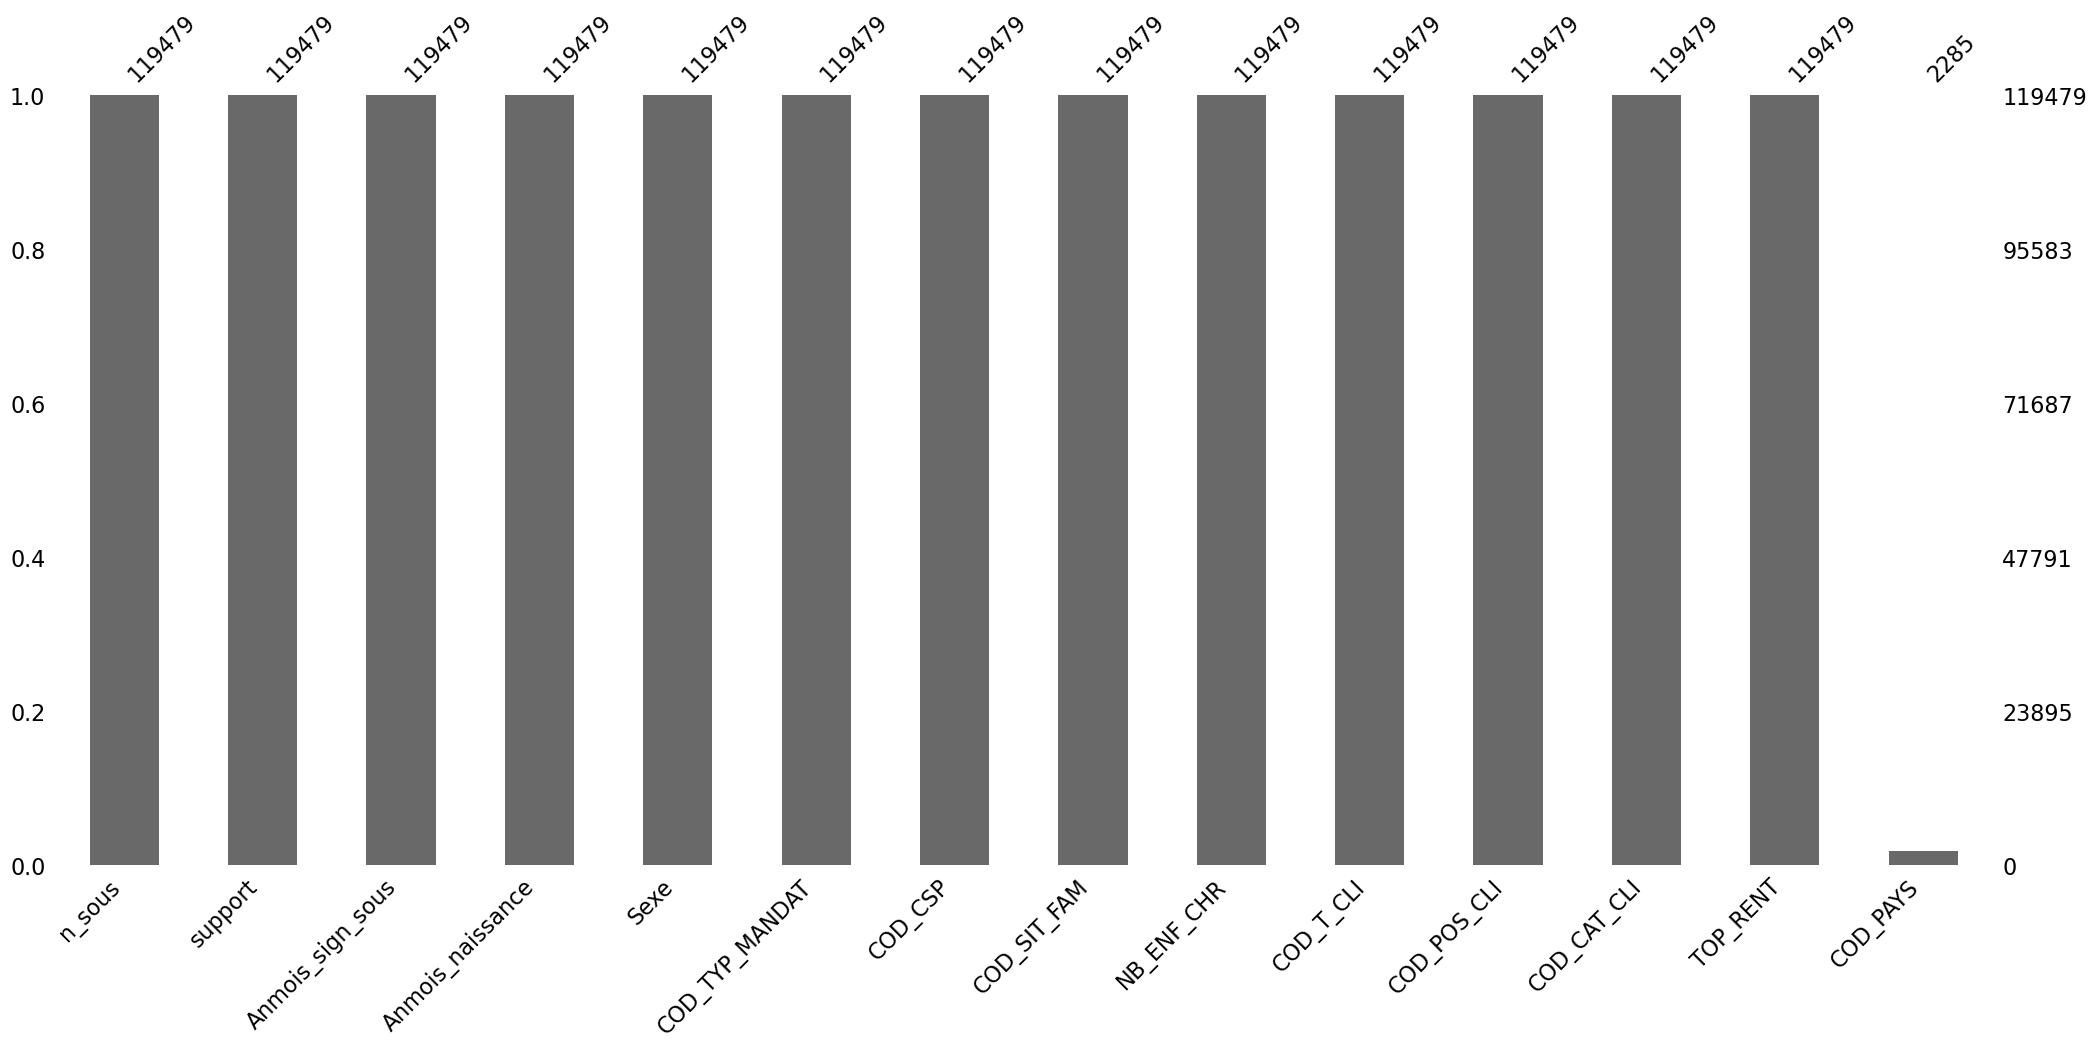

In [34]:
mso.bar(base[Variables_retenues])

Ce pendant nous avons le nombre de contrats différents suivant :

In [35]:
N=len(base['n_sous'].unique())
N

9507

#### Répartition du portefeuille suivant le type de support

Nous nous intéressons qu'aux contrats multisupports et nous avons la répartion suivant selon le type de support :

In [36]:
base_support=base[['n_sous','support']]
p=base_support.drop_duplicates(subset="n_sous")
p.groupby(by="support").count()

n_sous
support                       
FG pur                    3254
Multi-supports avec FG    4629
UC pures                  1624

Sur les 9507 contrats de la base de données nous allons nous restreindre aux 4629 contrats Multisupports définis comme suit :

In [37]:
#Base qui recense tous contrats multi-suppots
base_multisupport = base_updte.dropna(subset = ['support'])[base_updte.dropna(subset = ['support'])['support'].str.contains('Multi-supports avec FG')]
#base_multisupport['r_FG_a'] = base_multisupport['r_FG_a'].fillna(0)

# Définition des variables de durées (âge et ancienneté)
base_multisupport['annee_sign_sous'] =  base_multisupport['Anmois_sign_sous'].astype(str).str.slice(0, 4)
base_multisupport['mois_sign_sous'] =  base_multisupport['Anmois_sign_sous'].astype(str).str.slice(4, 6)
base_multisupport['annee_sign_sous'] = base_multisupport['annee_sign_sous'].astype(int)
base_multisupport['mois_sign_sous'] = base_multisupport['mois_sign_sous'].astype(int)
base_multisupport['anciennete'] = 2021 - base_multisupport['annee_sign_sous']

base_multisupport['annee_nais'] =  base_multisupport['Anmois_naissance'].astype(str).str.slice(0, 4)
base_multisupport['annee_nais'] = base_multisupport['annee_nais'].astype(int)
base_multisupport['age'] = 2021 - base_multisupport['annee_nais']

En se restreignant uniquement aux contrats ayant fait l'objet d'arbitrage, nous avons :

In [38]:
base_multisupport_arbitrage=base_multisupport.dropna(subset = ['operation'])[base_multisupport.dropna(subset = ['operation'])['operation'].str.contains('Arbitrages')]

In [39]:
base_multisupport_arbitrage["TX_FRS_ARB"].nunique()

9

### Nombre de contrats arbitrant par mois

In [40]:
comptage=base_multisupport_arbitrage[['n_sous','support','Anmois_operation','operation','CD_TYPE_SUP','montant_corr','anciennete','age']]

In [41]:
comptage_NU=base_multisupport_arbitrage[['n_sous','Anmois_operation']]
contrat_arbitre = comptage_NU.groupby(by=['Anmois_operation'], as_index=False).nunique()
contrat_arbitre.rename(columns={'n_sous': 'Nombre de contrats arbitrants'}, inplace=True)
contrat_arbitre

Anmois_operation  Nombre de contrats arbitrants
0           202101.0                            427
1           202102.0                            449
2           202103.0                            740
3           202104.0                            480
4           202105.0                            422
5           202106.0                            564
6           202107.0                            299
7           202108.0                            238
8           202109.0                            551
9           202110.0                            344
10          202111.0                            271
11          202112.0                            705

Au total sur notre portefeuille le nombre de contrats qui ont arbitré est de :

In [42]:
N5=len(np.unique(comptage_NU['n_sous']))
print(N5)
print("\nSoit un pourcentage de",round(100*N5/N,2),"% sur l'ensemble des contrats multisupport.") 

1733

Soit un pourcentage de 18.23 % sur l'ensemble des contrats multisupport.


#### Nombre de contrats qui ont effectué 1, 2, 3 ou plus 4 arbitrages suivant les mois

In [43]:
# On détermine de prime à bord le nombre de d'opérations d'arbitrage (EU vers UC, UC vers EU, UC vers UC) 
# par mois de chaque contrat 
contrat_mois = comptage.groupby(by=['n_sous','Anmois_operation'], as_index=False).count()
contrat_mois['operation']=(contrat_mois['operation']/2).apply(lambda x: math.ceil(x))
# Chaque contrat arbitre chaque mois 1, 2, 3 ou 4 fois 
contrat_mois['operation'].unique()

array([1, 2, 3, 4])

In [44]:
# Utiliser pour évaluer le nombre de contrats total arbitrant 1, 2, 3 ou plus de 4 fois sur l'année
p=contrat_mois.groupby(by=['n_sous'], as_index=False).sum()

Ainsi le nombre de contrats arbitrants 1,2,3 ou plus de 4 fois suivant les mois est donné par la suite

#### Pour les contrats arbitrant une seul fois :

In [45]:
contrat_mois_1=contrat_mois[contrat_mois['operation']==1]
contrat_arbitre_1 = contrat_mois_1.groupby(by=['Anmois_operation'], as_index=False).nunique()
contrat_arbitre_1=contrat_arbitre_1[['Anmois_operation','n_sous']]
contrat_arbitre_1.rename(columns={'n_sous': 'Nombre de contrats arbitrants 1 fois'}, inplace=True)
contrat_arbitre_1

Anmois_operation  Nombre de contrats arbitrants 1 fois
0           202101.0                                   360
1           202102.0                                   342
2           202103.0                                   215
3           202104.0                                   337
4           202105.0                                   291
5           202106.0                                   308
6           202107.0                                   238
7           202108.0                                   211
8           202109.0                                   481
9           202110.0                                   273
10          202111.0                                   209
11          202112.0                                   639

#### Total des contrats qui arbitrent 1 fois sur l'année :

Dans le portefeuille le nombre de contrats ayant arbitré 1 fois aucours de l'année est de :

In [46]:
N1= (p[p['operation']==1])['n_sous'].count()
N1

495

#### Pour les contrats arbitrants deux fois :

In [47]:
contrat_mois_2=contrat_mois[contrat_mois['operation']==2]
contrat_arbitre_2 = contrat_mois_2.groupby(by=['Anmois_operation'], as_index=False).nunique()
contrat_arbitre_2=contrat_arbitre_2[['Anmois_operation','n_sous']]
contrat_arbitre_2.rename(columns={'n_sous': 'Nombre de contrats arbitrants 2 fois'}, inplace=True)
contrat_arbitre_2

Anmois_operation  Nombre de contrats arbitrants 2 fois
0           202101.0                                    66
1           202102.0                                    95
2           202103.0                                   504
3           202104.0                                   137
4           202105.0                                   126
5           202106.0                                   102
6           202107.0                                    57
7           202108.0                                    25
8           202109.0                                    68
9           202110.0                                    68
10          202111.0                                    61
11          202112.0                                    60

Dans le portefeuille le nombre de contrats ayant arbitré 2 fois aucours de l'année est de :

In [48]:
N2= (p[p['operation']==2])['n_sous'].count()
N2

312

#### Pour les contrats arbitrant trois fois :

In [49]:
contrat_mois_3=contrat_mois[contrat_mois['operation']==3]
contrat_arbitre_3 = contrat_mois_3.groupby(by=['Anmois_operation'], as_index=False).nunique()
contrat_arbitre_3=contrat_arbitre_3[['Anmois_operation','n_sous']]
contrat_arbitre_3.rename(columns={'n_sous': 'Nombre de contrats arbitrants 3 fois'}, inplace=True)
contrat_arbitre_3

Anmois_operation  Nombre de contrats arbitrants 3 fois
0           202101.0                                     1
1           202102.0                                    11
2           202103.0                                    21
3           202104.0                                     6
4           202105.0                                     5
5           202106.0                                   154
6           202107.0                                     4
7           202108.0                                     2
8           202109.0                                     2
9           202110.0                                     3
10          202111.0                                     1
11          202112.0                                     6

Dans le portefeuille le nombre de contrats ayant arbitré 3 fois aucours de l'année est de : 

In [50]:
N3= (p[p['operation']==3])['n_sous'].count()
N3

150

#### Pour les contrats arbitrant plus de quatre fois :

In [51]:
contrat_mois_4=contrat_mois[contrat_mois['operation']>=4]
contrat_arbitre_4 = contrat_mois_4.groupby(by=['Anmois_operation'], as_index=False).nunique()
contrat_arbitre_4=contrat_arbitre_4[['Anmois_operation','n_sous']]
contrat_arbitre_4.rename(columns={'n_sous': 'Nombre de contrats arbitrants 4 fois'}, inplace=True)
contrat_arbitre_4

Anmois_operation  Nombre de contrats arbitrants 4 fois
0          202102.0                                     1

Dans le portefeuille le nombre de contrats ayant arbitré plus de 4 fois aucours de l'année est de : (Notons qu'il y'a des contrats qui ont arbitré plus de 20 fois)

In [52]:
N4=(p[p['operation']>=4])['n_sous'].count()
N4

776

### Pour ce qui est du nombre Total d'opérations d'arbitrages par mois nous avons :

In [53]:
Nb_contrat =contrat_mois.groupby(by=['Anmois_operation'], as_index=False).sum()
Nb_contrat=Nb_contrat[['Anmois_operation','operation']]
Nb_contrat.rename(columns={'operation': 'Nombre d arbitrages'}, inplace=True)
Nb_contrat

Anmois_operation  Nombre d arbitrages
0           202101.0                  495
1           202102.0                  569
2           202103.0                 1286
3           202104.0                  629
4           202105.0                  558
5           202106.0                  974
6           202107.0                  364
7           202108.0                  267
8           202109.0                  623
9           202110.0                  418
10          202111.0                  334
11          202112.0                  777

Nombre Total d'opérations arbitrages sur l'année :

In [54]:
N6=Nb_contrat['Nombre d arbitrages'].sum()
N6

7294

### Maintenant nous avons les statitiques du portefeuille en nombre de contrats arbitrants et nombre d'arbitrages suivants : 

In [55]:
dataframes=[contrat_arbitre_1,contrat_arbitre_2,contrat_arbitre_3,contrat_arbitre_4,contrat_arbitre,Nb_contrat]
stat = dataframes[0]
for df in dataframes[1:]:
    stat = pd.merge(stat, df, on='Anmois_operation', how='outer')
stat.fillna(0, inplace=True)
stat =stat.astype(int)
#Convertir la colonne Anmois_opération
stat['Anmois_operation'] = pd.to_datetime(stat['Anmois_operation'], format='%Y%m')
stat['Anmois_operation'] = stat['Anmois_operation'].dt.strftime('%B %Y')
stat['Anmois_operation'] = stat['Anmois_operation'].astype(str)
stat.loc[len(stat)] = ['ENSEMBLE',N1,N2,N3,N4,N5,N6]
stat = stat.set_index('Anmois_operation')
stat

Nombre de contrats arbitrants 1 fois  \
Anmois_operation                                         
January 2021                                       360   
February 2021                                      342   
March 2021                                         215   
April 2021                                         337   
May 2021                                           291   
June 2021                                          308   
July 2021                                          238   
August 2021                                        211   
September 2021                                     481   
October 2021                                       273   
November 2021                                      209   
December 2021                                      639   
ENSEMBLE                                           495   

                  Nombre de contrats arbitrants 2 fois  \
Anmois_operation                                         
January 2021                                        66   
February 2021                                       95   
March 2021                                         504   
April 2021                                         137   
May 2021                                           126   
June 2021                                          102   
July 2021                                           57   
August 2021                                         25   
September 2021                                      68   
October 2021                                        68   
November 2021                                       61   
December 2021                                       60   
ENSEMBLE                                           312   

                  Nombre de contrats arbitrants 3 fois  \
Anmois_operation                                         
January 2021                                         1   
February 2021                                       11   
March 2021                                          21   
April 2021                                           6   
May 2021                                             5   
June 2021                                          154   
July 2021                                            4   
August 2021                                          2   
September 2021                                       2   
October 2021                                         3   
November 2021                                        1   
December 2021                                        6   
ENSEMBLE                                           150   

                  Nombre de contrats arbitrants 4 fois  \
Anmois_operation                                         
January 2021                                         0   
February 2021                                        1   
March 2021                                           0   
April 2021                                           0   
May 2021                                             0   
June 2021                                            0   
July 2021                                            0   
August 2021                                          0   
September 2021                                       0   
October 2021                                         0   
November 2021                                        0   
December 2021                                        0   
ENSEMBLE                                           776   

                  Nombre de contrats arbitrants  Nombre d arbitrages  
Anmois_operation                                                      
January 2021                                427                  495  
February 2021                               449                  569  
March 2021                                  740                 1286  
April 2021                                  480                  629  
May 2021                                    422                  558  
June 2021                            

Ce tableau présente les contrats par nombre d’arbitrages effectués. Ainsi, 1734 contrats ont été à l’origine des 7297 mouvements d’arbitrages enregistrés, et sur l'année 2021 seuls 495 contrats du portefeuille n’ont effectué qu’un seul arbitrage. Ainsi, de nombreux clients effectuent plusieurs arbitrages lors de la durée de vie des contrats, ce qui permet de supposer que des clients qui ont déjà effectués des arbitrages sont plus susceptibles d’en faire à nouveau que des clients n’ayant jamais arbitré.

### Mouvement d'arbitrage de EU vers UC

#### Nombre d'arbitrages par EU -> UC

In [56]:
#arbitrage_EU=comptage[comptage['operation']=='Arbitrages sortants du FG']
#Nb_contrat_mois_EU = arbitrage_EU.groupby('Anmois_operation')['operation'].count()
#Nb_contrat_mois_EU

In [57]:
arbitrage_EU=comptage[comptage['operation']=='Arbitrages sortants du FG']
contrat_mois_EU =arbitrage_EU.groupby(by=['n_sous','Anmois_operation'], as_index=False).count()
Nb_contrat_mois_EU=contrat_mois_EU.groupby(by=['Anmois_operation'], as_index=False).sum()
Nb_contrat_mois_EU=Nb_contrat_mois_EU[['Anmois_operation','operation']]
Nb_contrat_mois_EU.rename(columns={'operation': 'Nombre d arbitrages EU->UC'}, inplace=True)
Nb_contrat_mois_EU

Anmois_operation  Nombre d arbitrages EU->UC
0           202101.0                          91
1           202102.0                         224
2           202103.0                         118
3           202104.0                          90
4           202105.0                          65
5           202106.0                         266
6           202107.0                          68
7           202108.0                          46
8           202109.0                          46
9           202110.0                          63
10          202111.0                          67
11          202112.0                          43

### Mouvement d'arbitrage de UC vers EU

#### Nombre d'arbitrages par EU -> UC

In [58]:
arbitrage_UC=comptage[comptage['operation']=='Arbitrages entrants du FG']
contrat_mois_UC =arbitrage_UC.groupby(by=['n_sous','Anmois_operation'], as_index=False).count()
Nb_contrat_mois_UC=contrat_mois_UC.groupby(by=['Anmois_operation'], as_index=False).sum()
Nb_contrat_mois_UC=Nb_contrat_mois_UC[['Anmois_operation','operation']]
Nb_contrat_mois_UC.rename(columns={'operation': 'Nombre d arbitrages UC->EU'}, inplace=True)
Nb_contrat_mois_UC

Anmois_operation  Nombre d arbitrages UC->EU
0           202101.0                          27
1           202102.0                         110
2           202103.0                         314
3           202104.0                          98
4           202105.0                         171
5           202106.0                          78
6           202107.0                          40
7           202108.0                          26
8           202109.0                         227
9           202110.0                          51
10          202111.0                          33
11          202112.0                         552

## RESUME

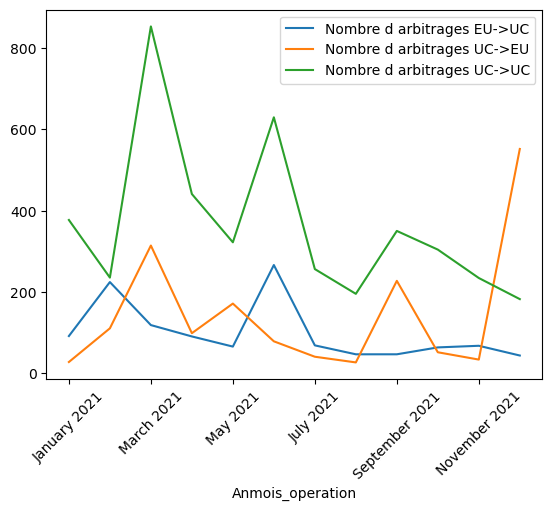

Nombre d arbitrages EU->UC  Nombre d arbitrages UC->EU  \
Anmois_operation                                                           
January 2021                              91                          27   
February 2021                            224                         110   
March 2021                               118                         314   
April 2021                                90                          98   
May 2021                                  65                         171   
June 2021                                266                          78   
July 2021                                 68                          40   
August 2021                               46                          26   
September 2021                            46                         227   
October 2021                              63                          51   
November 2021                             67                          33   
December 2021                             43                         552   
TOTAL                                   1187                        1727   

                  Nombre d arbitrages UC->UC  Nombre d arbitrages  
Anmois_operation                                                   
January 2021                             377                  495  
February 2021                            235                  569  
March 2021                               854                 1286  
April 2021                               441                  629  
May 2021                                 322                  558  
June 2021                                630                  974  
July 2021                                256                  364  
August 2021                              195                  267  
September 2021                           350                  623  
October 2021                             304                  418  
November 2021                            234                  334  
December 2021                            182                  777  
TOTAL                                   4380                 7294

In [59]:
df=[Nb_contrat_mois_EU,Nb_contrat_mois_UC,Nb_contrat]
stat1 = df[0]
for df in df[1:]:
    stat1 = pd.merge(stat1, df, on='Anmois_operation', how='outer')
#Convertir la colonne Anmois_opération
stat1['Anmois_operation'] = pd.to_datetime(stat1['Anmois_operation'], format='%Y%m')
stat1['Anmois_operation'] = stat1['Anmois_operation'].dt.strftime('%B %Y')
stat1['Anmois_operation'] = stat1['Anmois_operation'].astype(str)


stat1['Nombre d arbitrages UC->UC']=stat1['Nombre d arbitrages']-stat1['Nombre d arbitrages EU->UC']-stat1['Nombre d arbitrages UC->EU']

#Réorganisation des colonnes
stat1 = stat1[['Anmois_operation', 'Nombre d arbitrages EU->UC', 'Nombre d arbitrages UC->EU','Nombre d arbitrages UC->UC','Nombre d arbitrages']]
stat1= stat1.set_index('Anmois_operation')

M=stat1[['Nombre d arbitrages EU->UC','Nombre d arbitrages UC->EU','Nombre d arbitrages UC->UC']]
ax=M.plot()
plt.xticks(rotation=45)
#for col in M.columns:
#    for x, y in enumerate(M[col]):
#        ax.text(x, y, str(y), color='blue', fontsize=8, verticalalignment='bottom')
plt.show()

stat1.loc['TOTAL'] = stat1.sum()
stat2=stat1
stat1

 STATISTIQUES DU PORTEFEUILLE EN FONCTION DU MOUVEMENT SUR LES SUPPORTS

In [60]:
(224+266+118)/1187

0.5122156697556866

### répartition en pourcentage

In [61]:
stat2['% EU->UC']=100*(stat2['Nombre d arbitrages EU->UC']/stat2['Nombre d arbitrages'])
stat2['% UC->EU']=100*(stat2['Nombre d arbitrages UC->EU']/stat2['Nombre d arbitrages'])
stat2['% UC->UC']=100*(stat2['Nombre d arbitrages UC->UC']/stat2['Nombre d arbitrages'])
stat2[['% EU->UC','% UC->EU','% UC->UC']].round(2) 

% EU->UC  % UC->EU  % UC->UC
Anmois_operation                              
January 2021         18.38      5.45     76.16
February 2021        39.37     19.33     41.30
March 2021            9.18     24.42     66.41
April 2021           14.31     15.58     70.11
May 2021             11.65     30.65     57.71
June 2021            27.31      8.01     64.68
July 2021            18.68     10.99     70.33
August 2021          17.23      9.74     73.03
September 2021        7.38     36.44     56.18
October 2021         15.07     12.20     72.73
November 2021        20.06      9.88     70.06
December 2021         5.53     71.04     23.42
TOTAL                16.27     23.68     60.05

A l'observation de ce tableau il est important de remarquer que sur la totalité des mouvements d’arbitrages étudiés en 2021 sur notre portefeuille, plus de la moitié des mouvements d'arbitrages soit 60,04% se font du support UC vers UC. Par ailleurs, seulement 16,27% des mouvements d'arbitrages enregistrés au total sont des arbitrages EU vers UC et donc environ 52 % de ces derniers ont été réalisés les seuls mois de février, mars et juin qui sont des mois où on note un nombre important de sortie en sur le fond en euro. Il est également important de joindre à cette analyse les montants présents et ou transférés sur chaque support à la fin de chaque mois.

## EVOLUTION DE L'ENCOURS SUR LES DIFFERENTS SUPPORTS

In [62]:
encours=base_multisupport[['n_sous','Anmois_operation','PM_UC','PM_FG','anciennete','age']]
contrat_encours=encours.groupby(by=['n_sous','Anmois_operation','PM_FG','PM_UC'], as_index=False).nunique()
contrat_encours=contrat_encours[['Anmois_operation','PM_FG','PM_UC']]
contrat_encours.rename(columns={'PM_FG': 'Encours support EU','PM_UC': 'Encours support UC'}, inplace=True)
#Convertir les données en valeur numériques 
contrat_encours[['Encours support EU', 'Encours support UC']] = contrat_encours[['Encours support EU', 'Encours support UC']].astype(float)
#Il est à noter que le contrat 9504 a des valeurs de PM_UC et PM_EU anormalement nulles

### Evolution de l'encours d'épargne sur chaque support

In [63]:
contrat_encours_moy=contrat_encours.groupby(by=['Anmois_operation'], as_index=False).mean()
#covertion de la variable Anmois en format date
contrat_encours_moy['Anmois_operation'] =pd.to_datetime(contrat_encours_moy['Anmois_operation'], format='%Y%m')
contrat_encours_moy.sort_values(by='Anmois_operation')
contrat_encours_moy['Anmois_operation'] = contrat_encours_moy['Anmois_operation'].dt.strftime('%B %Y')
contrat_encours_moy['Anmois_operation'] = contrat_encours_moy['Anmois_operation'].astype(str)
contrat_encours_moy=contrat_encours_moy.set_index('Anmois_operation')

# calcul de l'encours moyen annuel sur chaque support
contrat_encours_moy.loc['ENSEMBLE']=contrat_encours_moy.mean()
X=contrat_encours_moy.round(2)
X

Encours support EU  Encours support UC
Anmois_operation                                        
January 2021               209912.97           215665.70
February 2021              197107.13           222539.11
March 2021                 247137.42           222244.27
April 2021                 227178.61           197246.66
May 2021                   216289.41           232139.65
June 2021                  209207.37           198938.06
July 2021                  223336.54           252014.20
August 2021                172648.87           205237.37
September 2021             211884.62           214772.93
October 2021               205407.94           264560.57
November 2021              172125.57           302035.39
December 2021              249815.93           218567.81
ENSEMBLE                   211837.70           228830.14

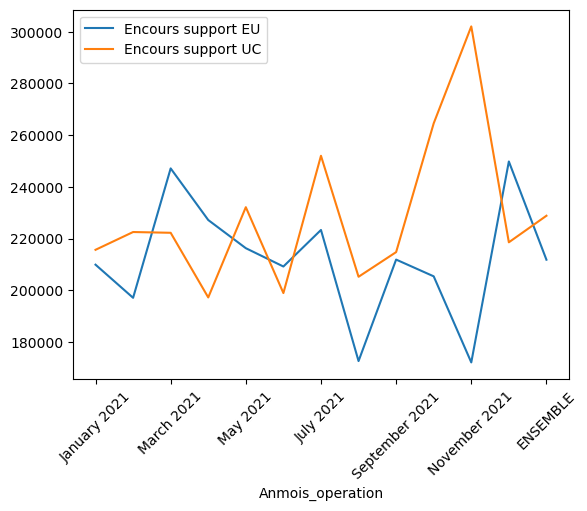

In [64]:
X[['Encours support EU','Encours support UC']].plot()
plt.xticks(rotation=45)
plt.show()

### Répartition en pourcentage

In [65]:
X['TOTAL']=X['Encours support EU']+X['Encours support UC']
X['% Encours support EU']=100*(X['Encours support EU']/X['TOTAL'])
X['% Encours support UC']=100*(X['Encours support UC']/X['TOTAL'])
Z=X[['% Encours support EU','% Encours support UC']].round(2)
Z

% Encours support EU  % Encours support UC
Anmois_operation                                            
January 2021                     49.32                 50.68
February 2021                    46.97                 53.03
March 2021                       52.65                 47.35
April 2021                       53.53                 46.47
May 2021                         48.23                 51.77
June 2021                        51.26                 48.74
July 2021                        46.98                 53.02
August 2021                      45.69                 54.31
September 2021                   49.66                 50.34
October 2021                     43.71                 56.29
November 2021                    36.30                 63.70
December 2021                    53.34                 46.66
ENSEMBLE                         48.07                 51.93

Là il s'agit de la répartition de l'épargne des clients à la fin de chaque mois sur différents supports UC ou EU. Nous constatons 
qu'en moyenne, de juin à decemebre la Provision mathématique sur le support UC est presque relativement plus élévée que le provision 
mathématique sur le support EU. Il serait certainement plus intéressant d'évaluer les montants totals mensuels transférés d'un support à un autre pour également mésurer l'ampleur des arbitrages, c'est ce qui est fait par la suite.

## Evolution des montants entrants et des montants sortants sur le fond en euro

### Montant sortant du FG

In [66]:
montant=comptage.copy()

In [67]:
montant['Anmois_operation'] =pd.to_datetime(montant['Anmois_operation'], format='%Y%m')

<function matplotlib.pyplot.show(close=None, block=None)>

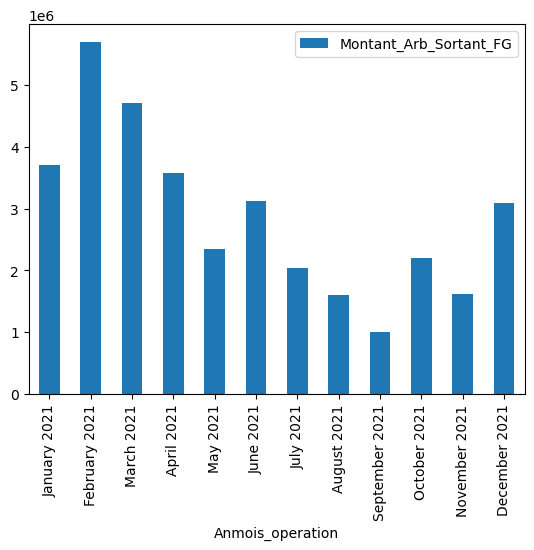

In [68]:
sortie_EU=montant[montant['operation']=='Arbitrages sortants du FG']
sortie_mois_EU = sortie_EU.groupby(by=['Anmois_operation'], as_index=False).sum()
sortie_mois_EU=sortie_mois_EU[['Anmois_operation','montant_corr']]
sortie_mois_EU['montant_corr']=-sortie_mois_EU['montant_corr']

sortie_mois_EU.sort_values(by='Anmois_operation')
sortie_mois_EU['Anmois_operation'] = sortie_mois_EU['Anmois_operation'].dt.strftime('%B %Y')
sortie_mois_EU['Anmois_operation'] = sortie_mois_EU['Anmois_operation'].astype(str)
sortie_mois_EU=sortie_mois_EU.set_index('Anmois_operation')
sortie_mois_EU.rename(columns={'montant_corr': 'Montant_Arb_Sortant_FG'}, inplace=True)
sortie_mois_EU.plot(kind='bar')
plt.show

### Montant entrants du FG

<function matplotlib.pyplot.show(close=None, block=None)>

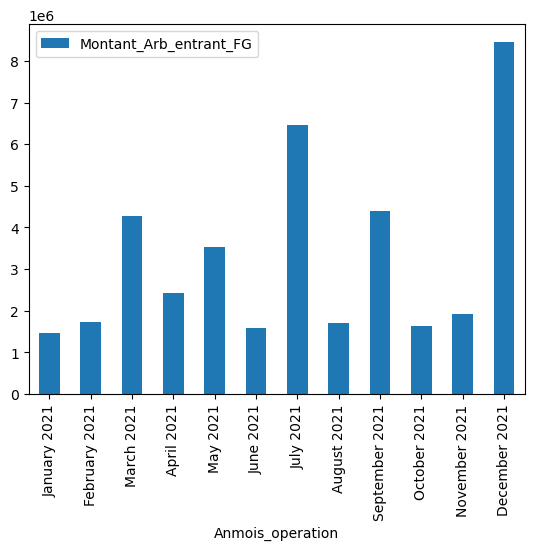

In [69]:
entrée_EU=montant[montant['operation']=='Arbitrages entrants du FG']
entrée_mois_EU = entrée_EU.groupby(by=['Anmois_operation'], as_index=False).sum()
entrée_mois_EU=entrée_mois_EU[['Anmois_operation','montant_corr']]

entrée_mois_EU.sort_values(by='Anmois_operation')
entrée_mois_EU['Anmois_operation'] = entrée_mois_EU['Anmois_operation'].dt.strftime('%B %Y')
entrée_mois_EU['Anmois_operation'] = entrée_mois_EU['Anmois_operation'].astype(str)
entrée_mois_EU=entrée_mois_EU.set_index('Anmois_operation')
entrée_mois_EU.rename(columns={'montant_corr':'Montant_Arb_entrant_FG'}, inplace=True)
entrée_mois_EU.plot(kind='bar')
plt.show

Montant_Arb_Sortant_FG  Montant_Arb_entrant_FG
Anmois_operation                                                
January 2021                  3710163.86              1471197.58
February 2021                 5698473.71              1725482.92
March 2021                    4713379.32              4275176.28
April 2021                    3576324.66              2423209.39
May 2021                      2348432.77              3539367.92
June 2021                     3123403.68              1582203.19
July 2021                     2039011.86              6463142.23
August 2021                   1608089.47              1711674.98
September 2021                 996488.66              4401315.91
October 2021                  2202704.45              1631824.14
November 2021                 1617298.16              1920286.03
December 2021                 3086238.80              8454506.64

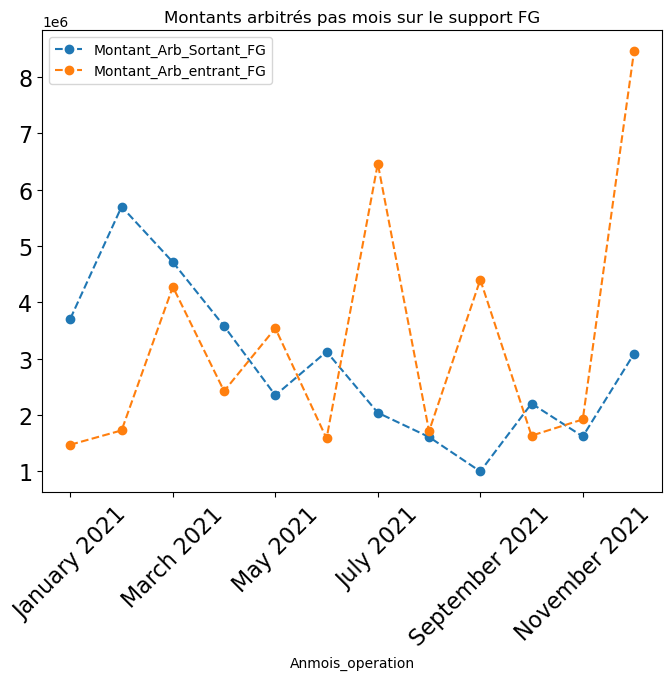

In [70]:
sortie_mois_EU['Montant_Arb_entrant_FG']=entrée_mois_EU['Montant_Arb_entrant_FG']
sortie_mois_EU.plot(marker="o",linestyle="dashed",title="Montants arbitrés pas mois sur le support FG",figsize=(8, 6),fontsize=16)
plt.xticks(rotation=45)
plt.show
sortie_mois_EU

Le flux d'arbitrage sur le suppport fond en euro est donné par le graphe suivant :

<function matplotlib.pyplot.show(close=None, block=None)>

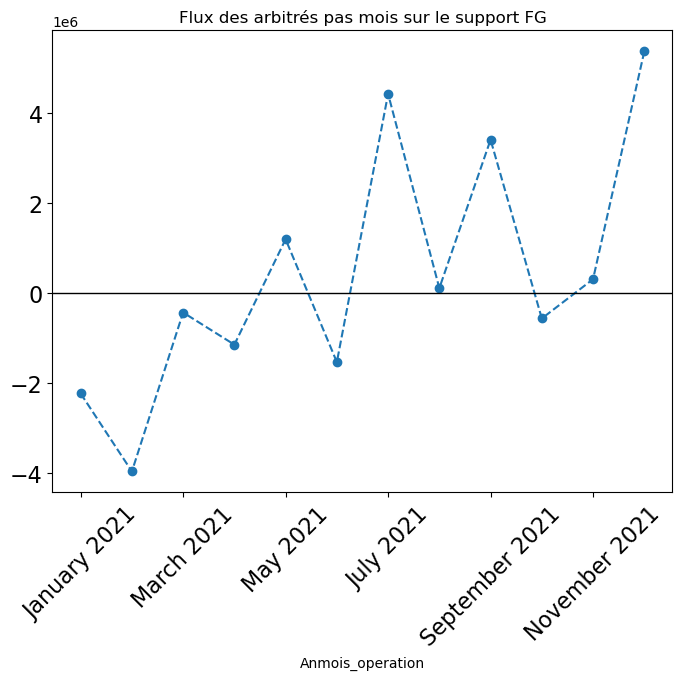

In [71]:
sortie_mois_EU['flux_Arb__FG']=sortie_mois_EU['Montant_Arb_entrant_FG']-sortie_mois_EU['Montant_Arb_Sortant_FG']
sortie_mois_EU['flux_Arb__FG'].plot(marker="o",linestyle="dashed",title="Flux des arbitrés pas mois sur le support FG",figsize=(8, 6),fontsize=16)
plt.axhline(y=0, color='black', linewidth=1)
plt.xticks(rotation=45)
plt.show

Le solde entrée-sotie sur le support fond en euro est négatif de janvier à juin excepté le mois de mai, ce resultat rejoint l'analyse 
faite précédemment où nous avons constaté que le nombre de mouvements d'arbitrages sortants du fond en euro était plus important 
au mois de février, mars et juin. Cela signifie qu’il y a plus de sortie du fonds euros que d’entrée. Cette période pourrait 
certainement coïncider avec une conjoncture financière haussière. Pour s'en assurer, nous allons croiser ce resultat avec celui 
de l'évolution des rendements du CAC 40 durant l'année 2021.

### Evolution du CAC 40 et du CAC All-Tradable 2021

In [72]:
#Données sur l'évolution du cours du CAC 40 en 2021
CAC_40_monthly_2021= get_data("^FCHI", start_date="01/01/2021", end_date="12/31/2021", index_as_date = True, interval="1mo")
CAC_40_monthly_2021

open         high          low        close     adjclose  \
2020-12-31  5614.040039  5721.890137  5379.220215  5399.209961  5399.209961   
2021-01-31  5441.430176  5834.359863  5429.779785  5703.220215  5703.220215   
2021-02-28  5770.890137  6097.740234  5755.600098  6067.229980  6067.229980   
2021-03-31  6079.669922  6352.359863  6063.859863  6269.479980  6269.479980   
2021-04-30  6285.509766  6496.319824  6150.430176  6447.169922  6447.169922   
2021-05-31  6470.419922  6687.290039  6464.709961  6507.830078  6507.830078   
2021-06-30  6549.819824  6671.120117  6253.250000  6612.759766  6612.759766   
2021-07-31  6657.950195  6913.669922  6560.740234  6680.180176  6680.180176   
2021-08-31  6736.439941  6784.660156  6389.620117  6520.009766  6520.009766   
2021-09-30  6421.100098  6830.339844  6412.700195  6830.339844  6830.339844   
2021-10-31  6870.279785  7183.080078  6655.859863  6721.160156  6721.160156   
2021-11-30  6774.799805  7201.649902  6730.629883  7153.029785  7153.029785   

                volume ticker  
2020-12-31  1890232300  ^FCHI  
2021-01-31  1653472600  ^FCHI  
2021-02-28  1790816900  ^FCHI  
2021-03-31  1131002300  ^FCHI  
2021-04-30  1406929000  ^FCHI  
2021-05-31  1498795900  ^FCHI  
2021-06-30  1235050200  ^FCHI  
2021-07-31  1307673500  ^FCHI  
2021-08-31  1895499000  ^FCHI  
2021-09-30  1580696700  ^FCHI  
2021-10-31  1852987900  ^FCHI  
2021-11-30  1611308500  ^FCHI

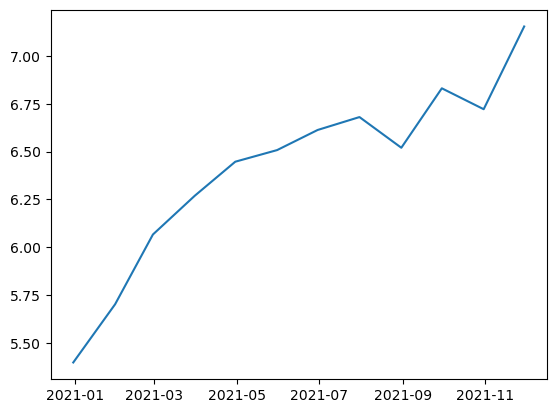

In [73]:
plt.plot(CAC_40_monthly_2021.index, CAC_40_monthly_2021['adjclose']/1000, label='valeur du CAC 40')

### Web scraping des données sur l'évolution du CAC All-Tradable sur le site web Investing.com
(l'indice le plus répresentatif de la santé de l'économie française)

In [74]:
## URL de la page
#url = 'https://fr.investing.com/indices/cac-all-tradable-historical-data'
#
## Envoi de la requête HTTP
#response = requests.get(url, headers=headers)
#
## Analyse du contenu HTML
#soup = BeautifulSoup(response.content, 'html.parser')
#table = soup.find('table', {'class': 'w-full text-xs leading-4 overflow-x-auto freeze-column-w-1'})
#
## Extraction des données du tableau
#rows = table.find_all('tr')
#data = []
#for row in rows:
#    cols = row.find_all('td')
#    cols = [ele.text.strip() for ele in cols]
#    data.append([ele for ele in cols if ele])  # Éliminer les données vides
#
## Convertir les données en DataFrame pandas pour un affichage plus lisible
#donnees_cac_all_tradable = pd.DataFrame(data, columns=['Date','Dernier','Ouv.', 'Plus Haut','Plus Bas','Vol.','Variation %']) 
#donnees_cac_all_tradable

In [75]:

## URL de la page
#url = 'https://fr.investing.com/indices/cac-all-tradable-historical-data'
#
## Envoi de la requête HTTP
#response = requests.get(url, headers=headers)
## Analyse du contenu HTML
#soup = BeautifulSoup(response.content, 'html.parser')
#table = soup.find('table', {'class':'w-full text-xs leading-4 overflow-x-auto freeze-column-w-1'})
#
## Extraction des données du tableau
#rows = table.find_all('tr')
#data = []
#for row in rows:
#    cols = row.find_all('td')
#    cols = [ele.text.strip() for ele in cols]
#    data.append([ele for ele in cols if ele])  # Éliminer les données vides
#
## Convertir les données en DataFrame pandas pour un affichage plus lisible
#donnees_cac_all_tradable = pd.DataFrame(data, columns=['Date','Dernier','Ouv.', 'Plus Haut','Plus Bas','Vol.','Variation %'])
#
## Convertir la colonne 'Date' en datetime
#donnees_cac_all_tradable['Date'] = pd.to_datetime(donnees_cac_all_tradable['Date'], format='%d/%m/%Y')
#
## Filtrer pour obtenir uniquement les données de 2021
#donnees_2021 = donnees_cac_all_tradable[donnees_cac_all_tradable['Date'].dt.year == 2021]
#
## Afficher le DataFrame filtré
#print(donnees_2021)

In [76]:
#!pip install investpy
#import investpy
#debut = '01/01/2020'
#fin = '31/12/2020'
#donnees_cac_all_tradable = investpy.indices.get_index_historical_data(index='CAC All-Tradable',country='france',from_date=debut,to_date=fin)
#print(donnees_cac_all_tradable)

In [77]:
#plt.plot(CAC_40_monthly_2021.index, CAC_40_monthly_2021['volume']/1000, label='valeur du CAC 40')
#plt.plot(sortie_mois_EU.index, sortie_mois_EU['flux_Arb__FG'], label='Flux entrée-sortie FG')
#plt.xlabel('Index')  
#plt.ylabel('Valeurs') 
#plt.title('Evolution du CAC 40 et du Flux entrée-sortie FG ') 
#plt.legend()
#plt.show()

Nous pouvons penser qu’il y a un lien entre les mouvements d’arbitrage et la fluctuation des cours du CAC 40, ou d’une manière
générale de la conjoncture financière et économique. En effet, 


   
    
Nous pouvons également par la suite éffectuer un test pour confirmer l'existente d'une corrélation négative entre le cours du CAC 40
et le solde entrée-sortie du fond en euro. Ce résultat confirmerait que lorsque le CAC40 augmente les épargnants ont tendance à
quitter le fonds euros au profit des unités de compte et ceci vice versa.

## ANALYSES DESCRIPTIVES BIVAREES

In [78]:
#Base dans laquelle un individu est un contrat multisupport
base_multisupport["TX_FRS_ARB"] = base_multisupport["TX_FRS_ARB"].fillna(-1)
base_multisupport["TX_FRS_ARB"] = base_multisupport["TX_FRS_ARB"].str.replace(',', '.').astype("float")
base_contrats = base_multisupport.drop_duplicates(subset=['n_sous'], keep='first')
base_arbitrage_FG_update = base_multisupport.dropna(subset = ['operation'])[base_multisupport.dropna(subset = ['operation'])['operation'].str.contains('Arbitrages sortants du FG')]
base_arbitrage_UC_FG = base_multisupport.loc[base_multisupport['r_UC_FG_a'] != 0]
base_arbitrage_UC_UC = base_multisupport.loc[base_multisupport['r_UC_UC_a'] != 0]

### Arbitrage et Ancienneté du Contrat

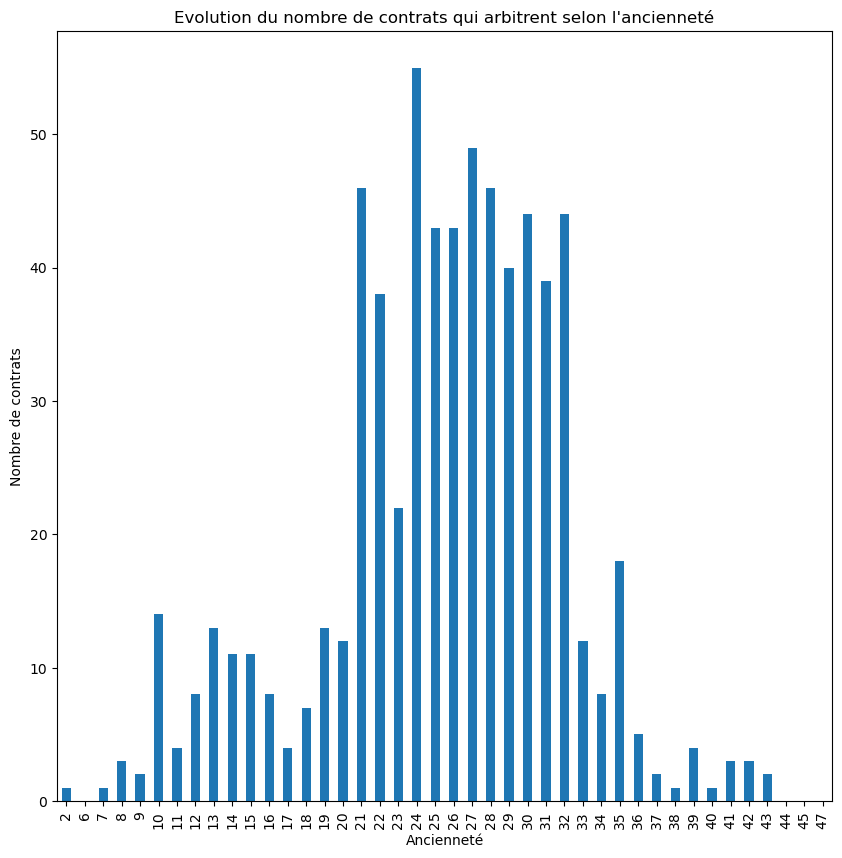

In [79]:
# Grouper par année et compter le nombre de contrats par année
arbitrages_par_annee = base_contrats.groupby('anciennete')['operation'].count()

#Graphique
plt.figure(figsize=(10, 10))
arbitrages_par_annee.plot(kind='bar', xlabel='Ancienneté', ylabel='Nombre de contrats' , title="Evolution du nombre de contrats qui arbitrent selon l'ancienneté")
plt.savefig('anciennete_arbitrage.png')
plt.show()

La majorité des contrats qui ont arbitré au moins une fois (peu importe le mouvement), ont une ancienneté comprise entre 20 et 30 ans.

In [80]:
def anciennete_arbitrage(base, col, titre, titre_graph):
    #Regroupement de l'ancienneté en classes
    bins = [4, 8, 12, 16, 20, 24, 28, 32, 36, 100]
    
    
    # Création des classes
    base['anciennete2'] = pd.cut(base['anciennete'], bins=bins, labels=['[4; 8]', '[8; 12]','[12; 16]', '[16; 20]', '[20; 24]', '[24; 28]', '[28; 32]', '[32; 36]', '[36; 100]'])
    counts = base['anciennete2'].value_counts()
    plt.figure(figsize=(10, 10))
    sns.boxplot(x='anciennete2', y=col, data=base, showfliers = False, width= counts/len(base))
    means = base.groupby('anciennete2')[col].apply(gmean)
    for i, mean in enumerate(means):
        plt.text(i, mean, f'{mean:.2f}', ha='center', va='bottom', color='red')
    plt.xlabel("Classes d'ancienneté")
    plt.ylabel("taux d'arbitrage annualisé")
    plt.title(f"Boxplot des {titre} en fonction des classes d'ancienneté \n (La largeur des boîtes est proportionnelle aux mouvements d'arbitrage concernés par la boîte)")
    plt.savefig('titre_graph')
    plt.show()

Ancienneté et arbitrage UC_FG

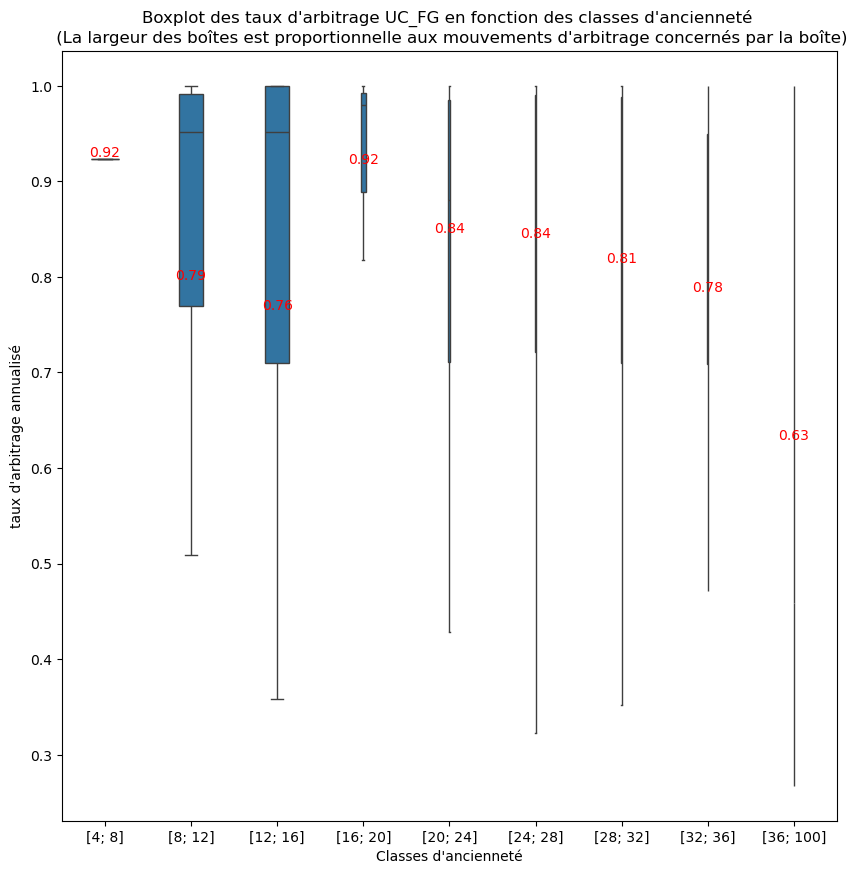

In [81]:
anciennete_arbitrage(base_arbitrage_UC_FG, 'r_UC_FG_a', "taux d'arbitrage UC_FG" , 'ancienneté_taux_UC_UC.png' )

Ancienneté et arbitrage UC_UC

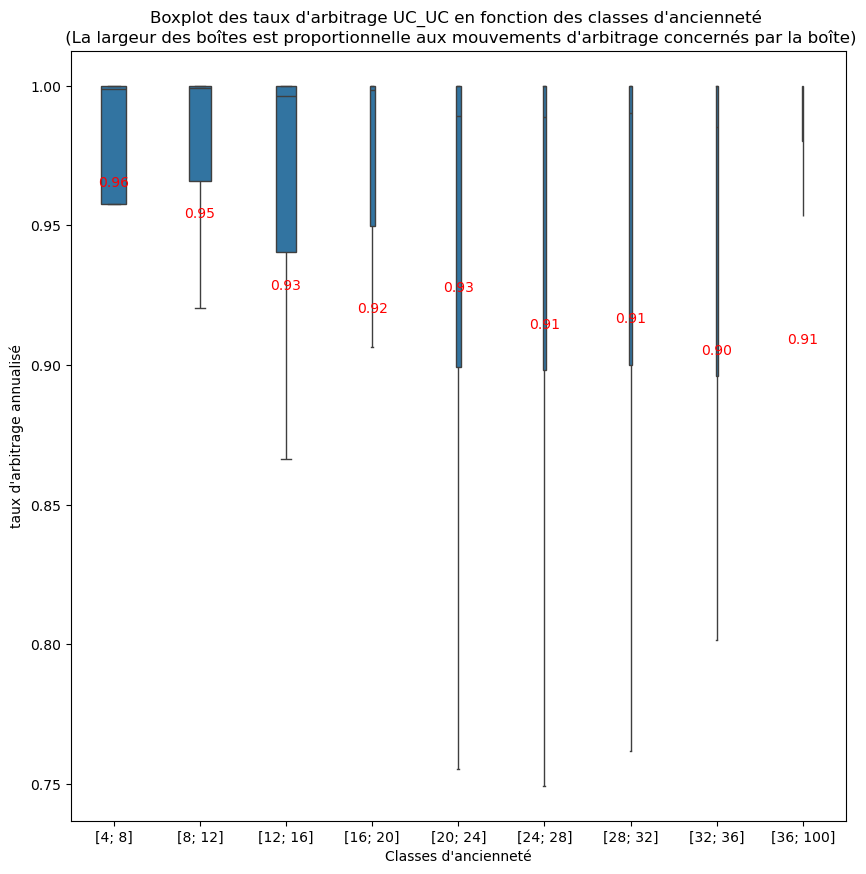

In [82]:
anciennete_arbitrage(base_arbitrage_UC_UC, 'r_UC_UC_a', "taux d'arbitrage UC_UC" , 'ancienneté_taux_UC_UC.png' )
warnings.filterwarnings('ignore', message='posx and posy should be finite values')

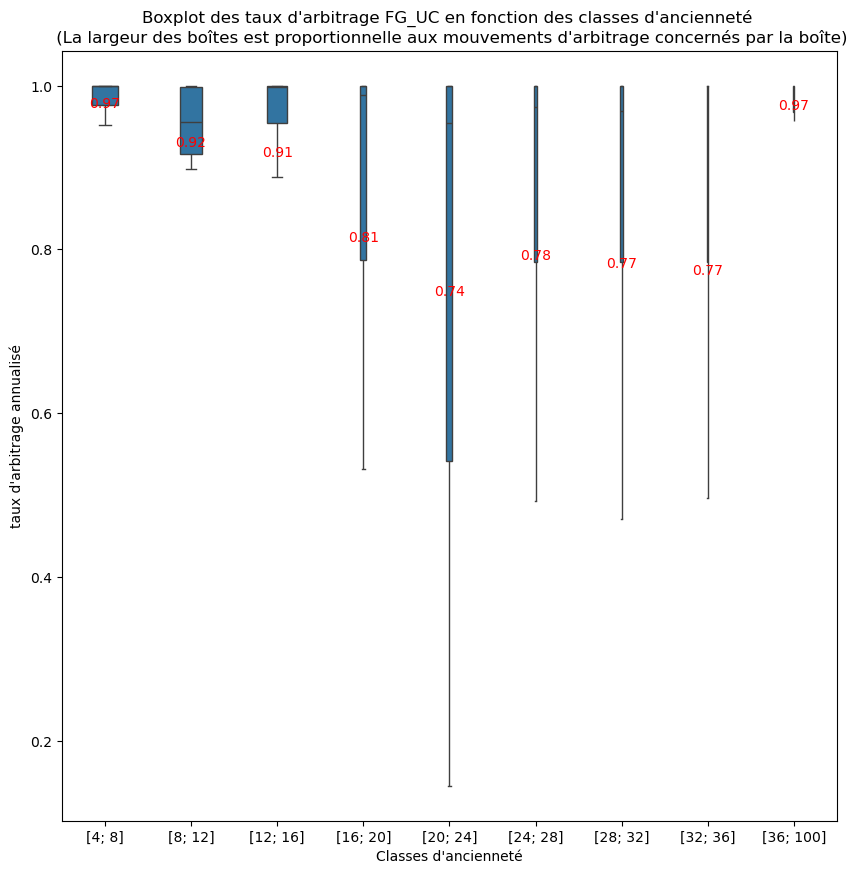

In [83]:
anciennete_arbitrage(base_arbitrage_FG_update, 'r_FG_a', "taux d'arbitrage FG_UC" , 'ancienneté_taux_FG_UC.png' )

Graphiquement, on peut constater que ces contrats qui sont majoritaires dans la base (entre 20 et 30 années d'ancienneté), souscrits entre 1991 et 2001, arbitrent des proportions de leur PM moindres, comparé aux contrats souscrits après 2005. De plus, ces derniers effectuent le plus de mouvements d'arbitrages

In fine, concernant l'ancienneté, on retient les points suivants :
- La base est constituée en majorité des contrats souscrits entre 1991 et 2001;
- Ces derniers par contre n'effectuent pas énormément de mouvement d'arbitrages;
- Et Bien même, lorsqu'ils arbitrent, ils arbitrent des proportions de leur Provision Mathématique inférieure à celle arbitrée par les contrats souscrits après 2005.

In [84]:
#sns.kdeplot(data=base_contrats, x='r_FG_a', palette='Set2')
#plt.hist(base_contrats['r_FG_a'], bins=10, edgecolor='black')

### Arbitrage et âge

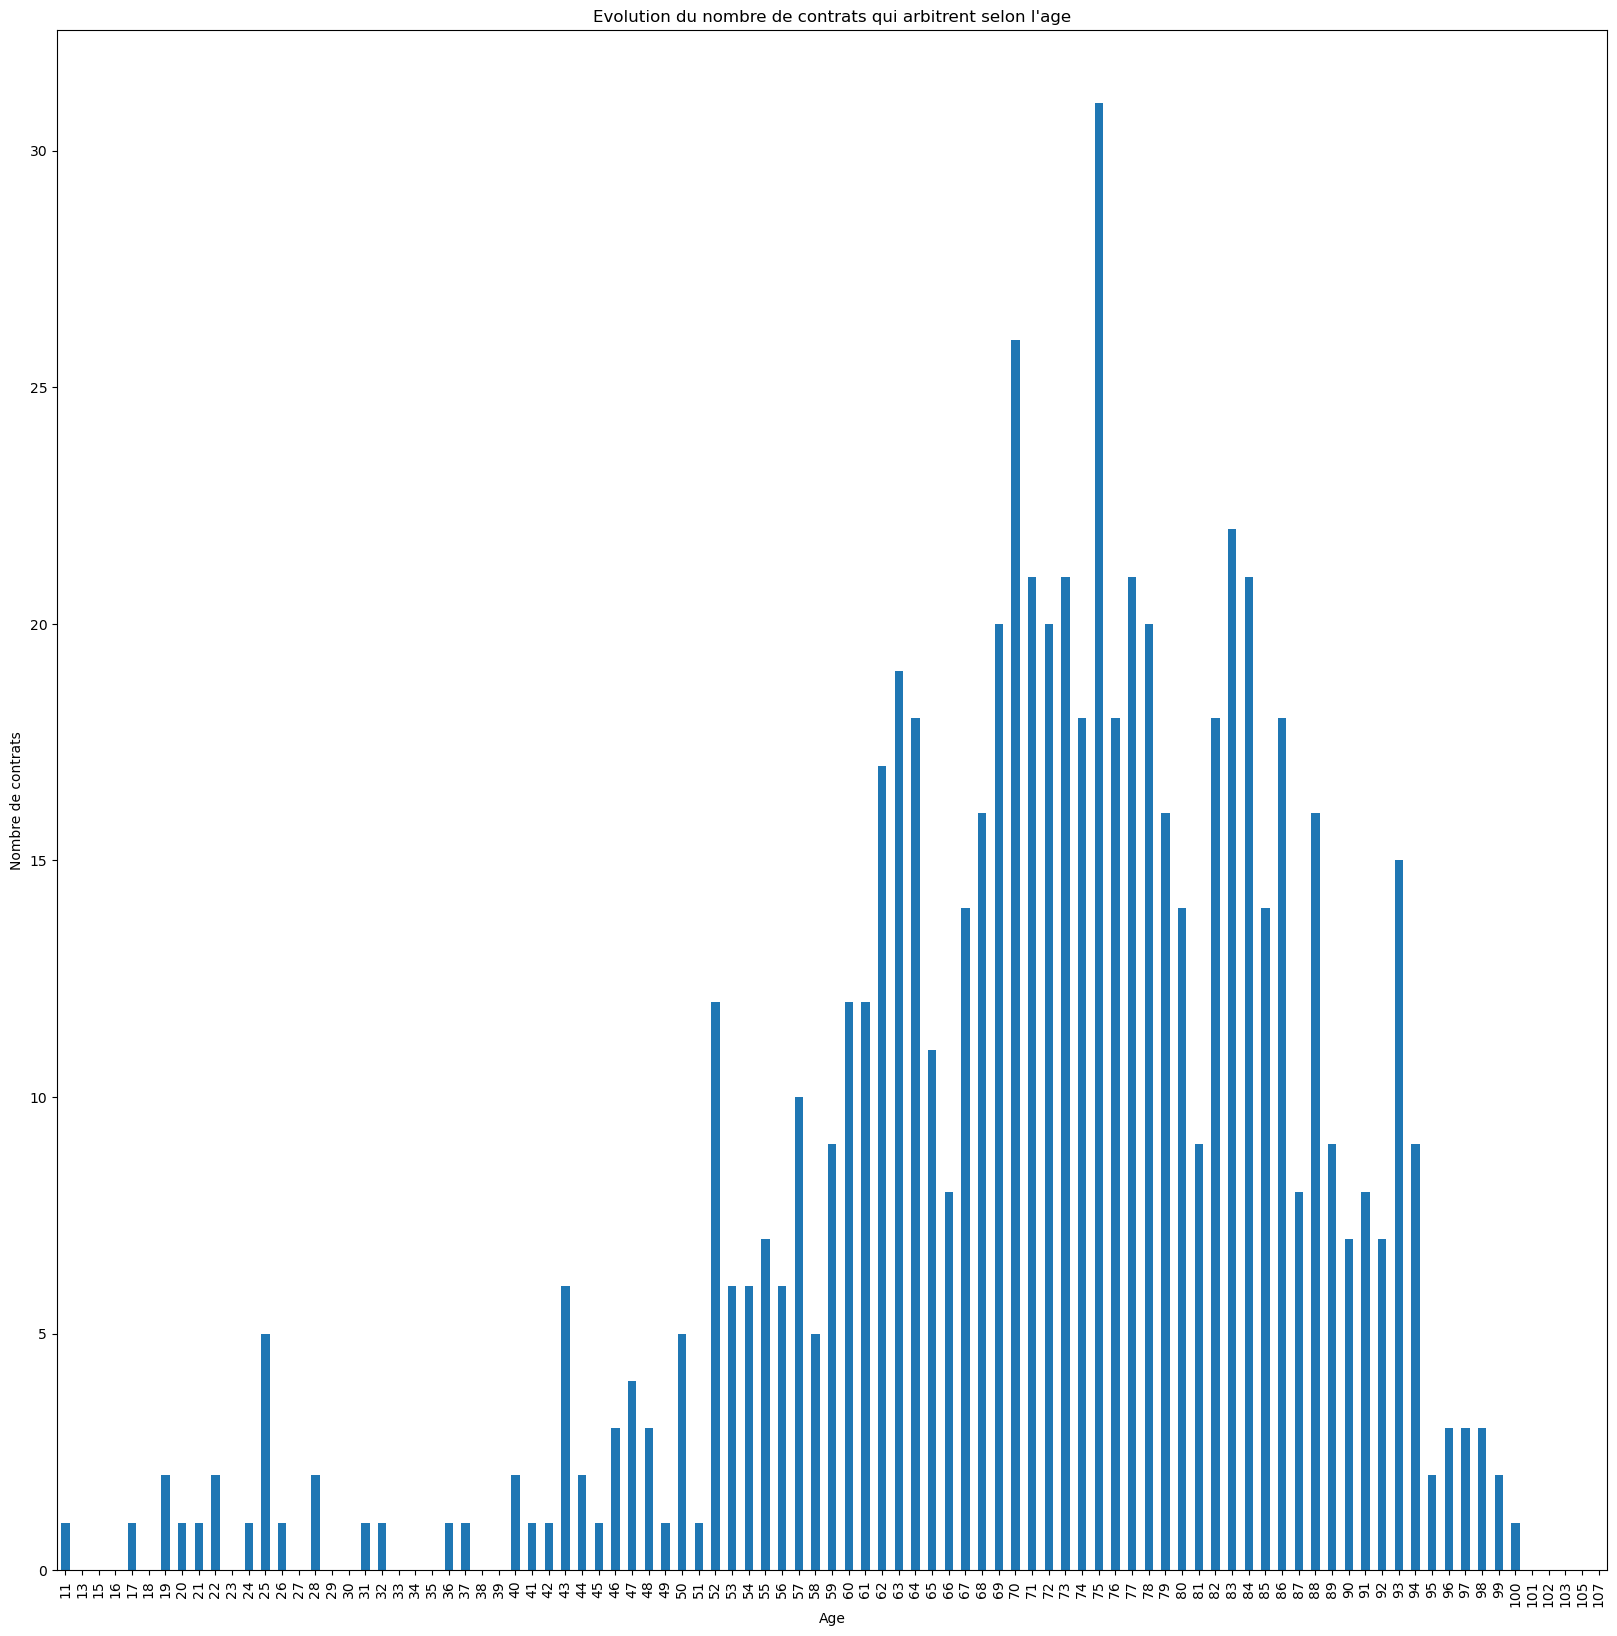

In [85]:
#Graphique
plt.figure(figsize=(20, 20))
base_contrats.groupby('age')['operation'].count().plot(kind='bar', xlabel='Age', ylabel='Nombre de contrats' , title="Evolution du nombre de contrats qui arbitrent selon l'age")
plt.savefig('age_taux_FG_UC1.png')
plt.show()

La majorité des contrats qui ont effectué au moins un arbitrage (peu importe lequel) a entre 60 et 90 ans.

In [86]:
def age_arbitrage(base, col, titre, titre_graph):
    #Regroupement de l'age en classes
    bins = list(range(20, 101,10))
    
    # Création des classes
    base['age2'] = pd.cut(base['age'], bins=bins, labels=['[20; 30]', '[30; 40]', '[40; 50]','[50; 60]', '[60; 70]', '[70; 80]', '[80; 90]', '[90; 100]'])
    
    counts = base['age2'].value_counts()
    plt.figure(figsize=(10, 10))
    sns.boxplot(x='age2', y=col, data=base, showfliers=False, width= 0.5 * counts/len(base))
    means = base.groupby('age2')[col].apply(gmean)
    for i, mean in enumerate(means):
        plt.text(i, mean, f'{mean:.2f}', ha='center', va='bottom', color='black')
        plt.text(i, mean, f'{round(100 * counts.iloc[i]/len(base),2)}%', ha='center', va='top', color='red')
    plt.xlabel("Age")
    plt.ylabel("taux d'arbitrage annualisé")
    #plt.yticks(np.arange(0, 100, 5))
    plt.title(f"Boxplot des {titre} en fonction des classes d'age \n (La largeur des boîtes est proportionnelle aux mouvements d'arbitrage concernés par la boîte)")
    plt.savefig(titre_graph)
    plt.show()

Age et arbitrage FG sortant

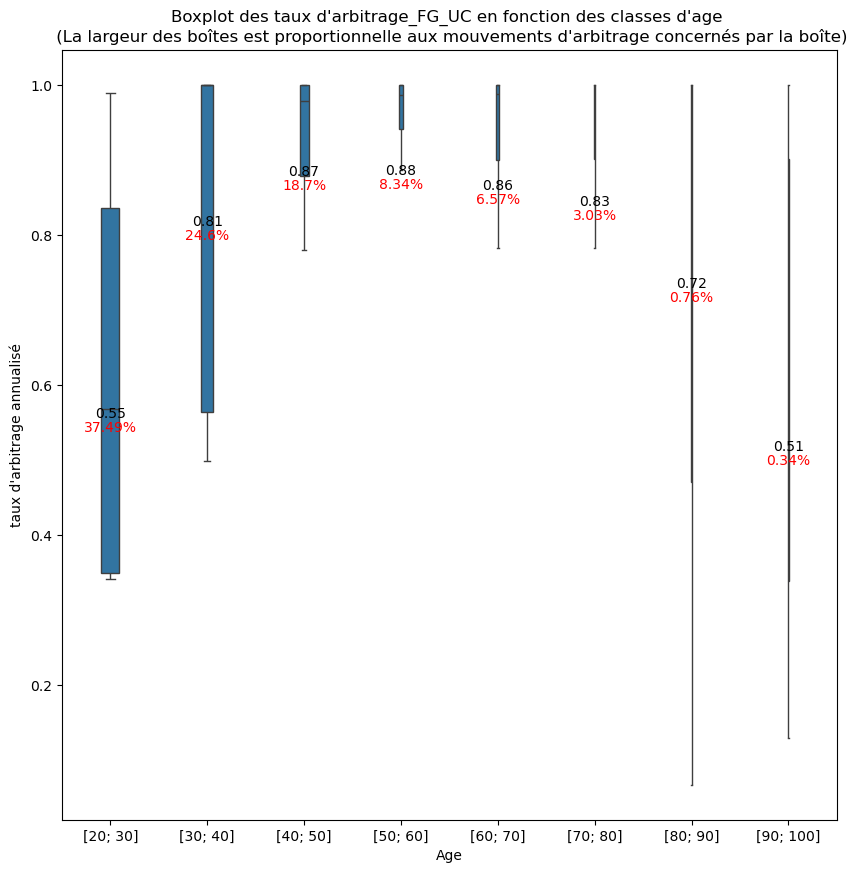

In [87]:
age_arbitrage(base_arbitrage_FG_update, 'r_FG_a', "taux d'arbitrage_FG_UC", 'age_taux_FG_UC.png')

La proportion de la Provision Mathématique FG arbitrée est croissante avec l'âge, jusqu'à un certain seuil, environ 55 ans à partir duquel cette proportion devient décroissante. Après la retraite, les taux d'arbitrages sont donc les plus bas.
--> Ceci nous fait penser à un effet quadratique de l'âge sur le taux d'arbitrage.

De plus, plus on est jeune, ce sont les plus jeunes, âgés de moins de 45 ans qui effectuent le plus les mouvements d'arbitrages FG.



Age et Arbitrage UC_FG

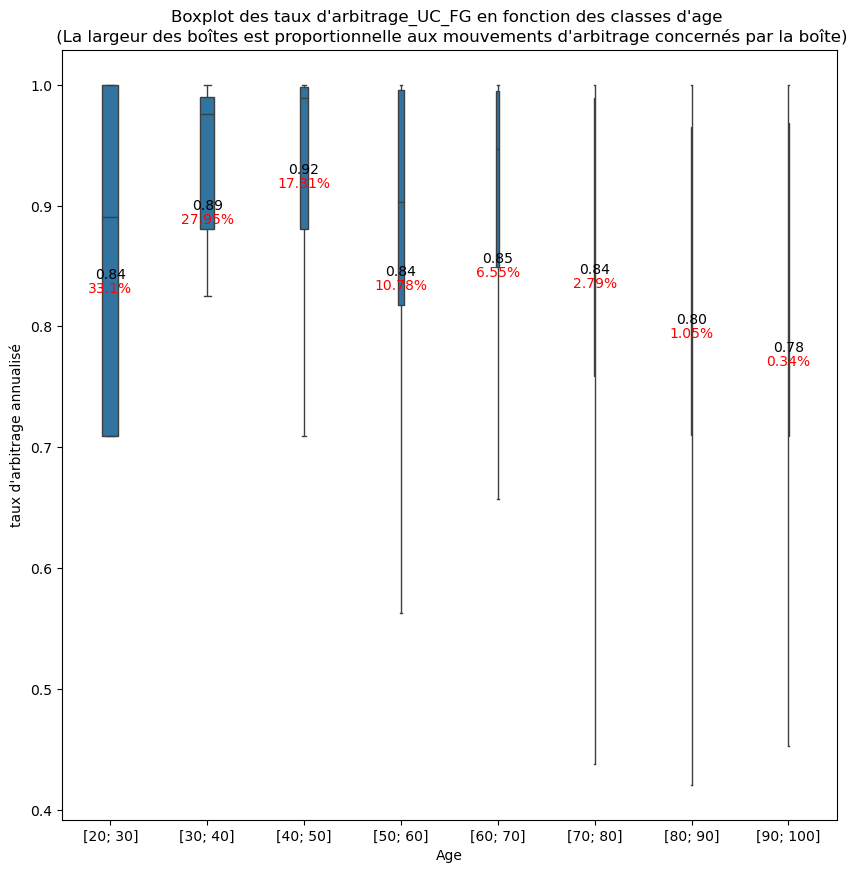

In [88]:
age_arbitrage(base_arbitrage_UC_FG, 'r_UC_FG_a', "taux d'arbitrage_UC_FG", 'age_taux_UC_FG.png')

Les contrats associés auc jeunes sont ceux sur lesquels il y'a le plus de mouvements d'arbitrage; On observe aussi une sorte d'effet quadratique de l'âge sur les taux d'arbitrage

Age et Arbitrage UC_UC

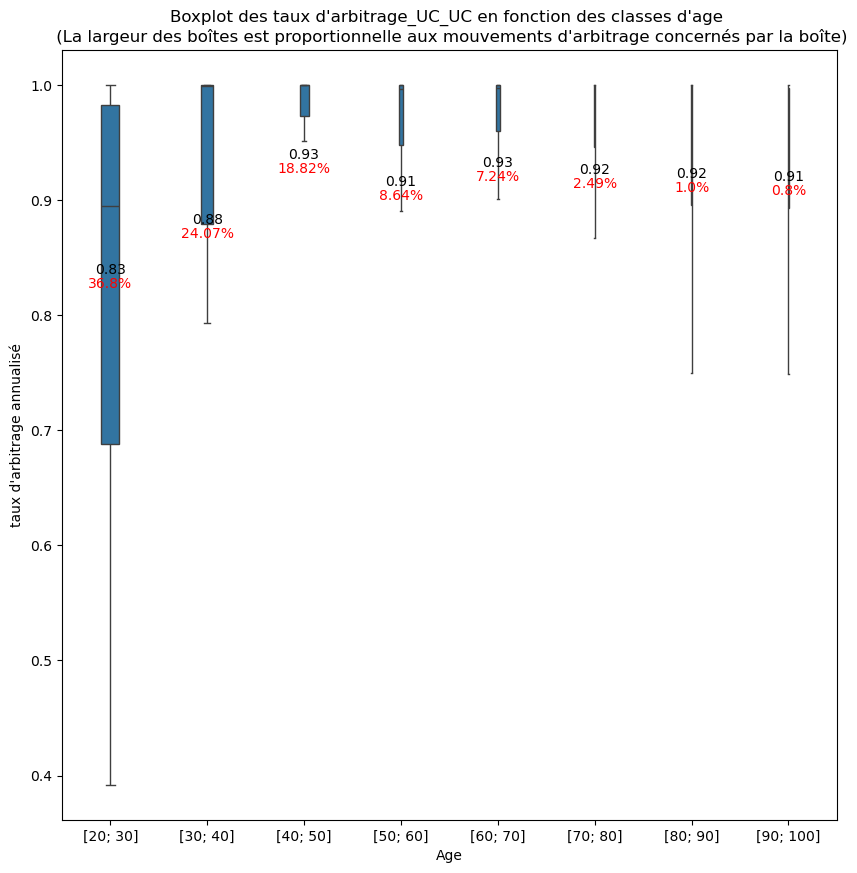

In [89]:
age_arbitrage(base_arbitrage_UC_UC, 'r_UC_UC_a', "taux d'arbitrage_UC_UC", 'age_taux_UC_UC.png')

### Arbitrage et Sexe

In [90]:
def sexe_arbitrage(base, col, titre ,titre_graph):
    counts = base['Sexe'].value_counts()
    plt.figure(figsize=(8, 8))
    sns.boxplot(x='Sexe', y=col, data=base, showfliers=False, width= 0.5 * counts/len(base))
    means = base.groupby('Sexe')[col].apply(gmean)
    #for i, mean in enumerate(means):
    #    plt.text(i, mean, f'{mean:.2f}', ha='center', va='bottom', color='black')
    #    plt.text(i, mean, f'{round(100 * counts.iloc[i]/len(base),2)}%', ha='center', va='top', color='red')
    plt.xlabel("Sexe")
    plt.ylabel("taux d'arbitrage")
    plt.title(f"Taux d'{titre} en fonction du sexe")
    plt.savefig(titre_graph)
    plt.show()
    

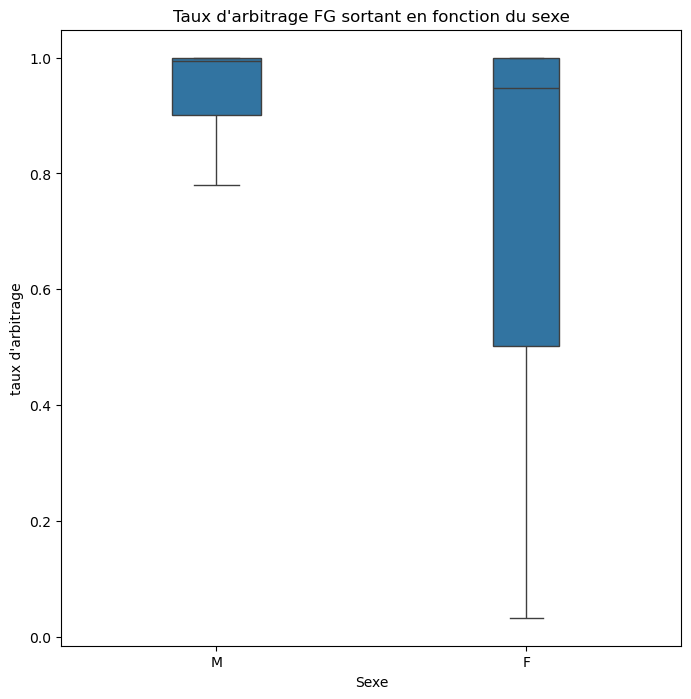

In [91]:
sexe_arbitrage(base_arbitrage_FG_update, 'r_FG_a', "arbitrage FG sortant", "Taux d'arbitrage en fonction du sexe")

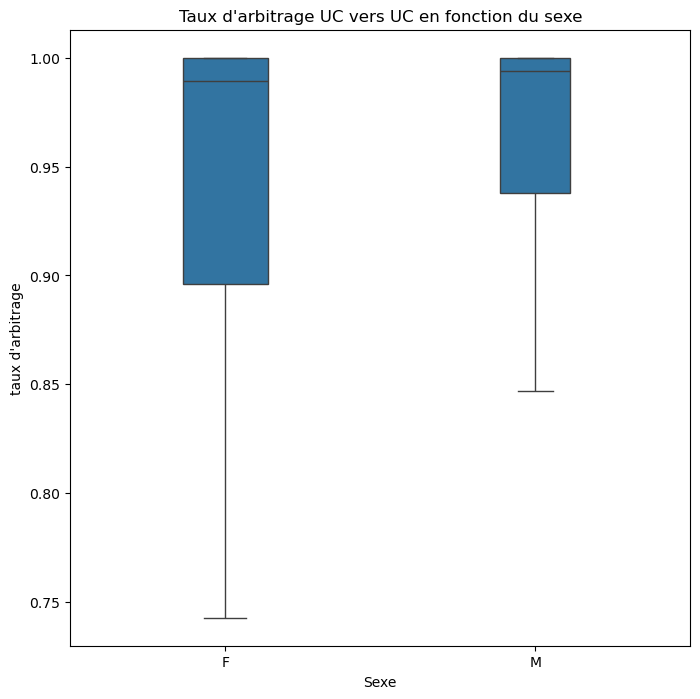

In [92]:
sexe_arbitrage(base_arbitrage_UC_UC, 'r_UC_UC_a', "arbitrage UC vers UC", "Taux d'arbitrage_UC_UC en fonction du sexe")

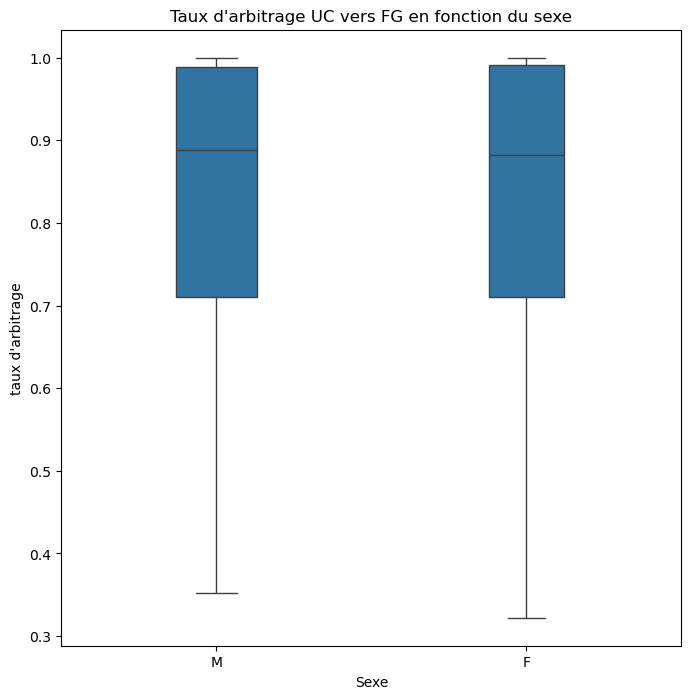

In [93]:
sexe_arbitrage(base_arbitrage_UC_FG, 'r_UC_FG_a', "arbitrage UC vers FG", "Taux d'arbitrage_UC_FG en fonction du sexe")

Quant au sexe, les hommes effectuent un peu plus de mouvements d'arbitrages sortant FG que les femmes, et leurs taux sont un peu plus bas que ceux des femmes.

Taux de frais d'arbitrage et arbitrage

In [94]:
base_arbitrage_UC_UC["TX_FRS_ARB"].nunique()

9

In [95]:
def taux_frais_arbitrage(base, col, titre, titre_graph):
    counts = base['TX_FRS_ARB'].value_counts()
    plt.figure(figsize=(10, 10))
    sns.boxplot(x='TX_FRS_ARB', y=col, data=base, showfliers=False, width= 0.5 * counts/len(base))
    means = base.groupby('TX_FRS_ARB')[col].apply(gmean)
    for i, mean in enumerate(means):
        plt.text(i, mean, f'{mean:.2f}', ha='center', va='bottom', color='black')
        plt.text(i, mean, f'{round(100 * counts.iloc[i]/len(base),2)}%', ha='center', va='top', color='red')
    plt.xlabel("Taux frais d'arbitrage")
    plt.ylabel("taux d'arbitrage annualisé")
    #plt.yticks(np.arange(0, 100, 5))
    plt.title(f"Boxplot des {titre} en fonction des taux de frais d'arbitrage \n (La largeur des boîtes est proportionnelle aux mouvements d'arbitrage concernés par la boîte)")
    plt.savefig(titre_graph)
    plt.show()

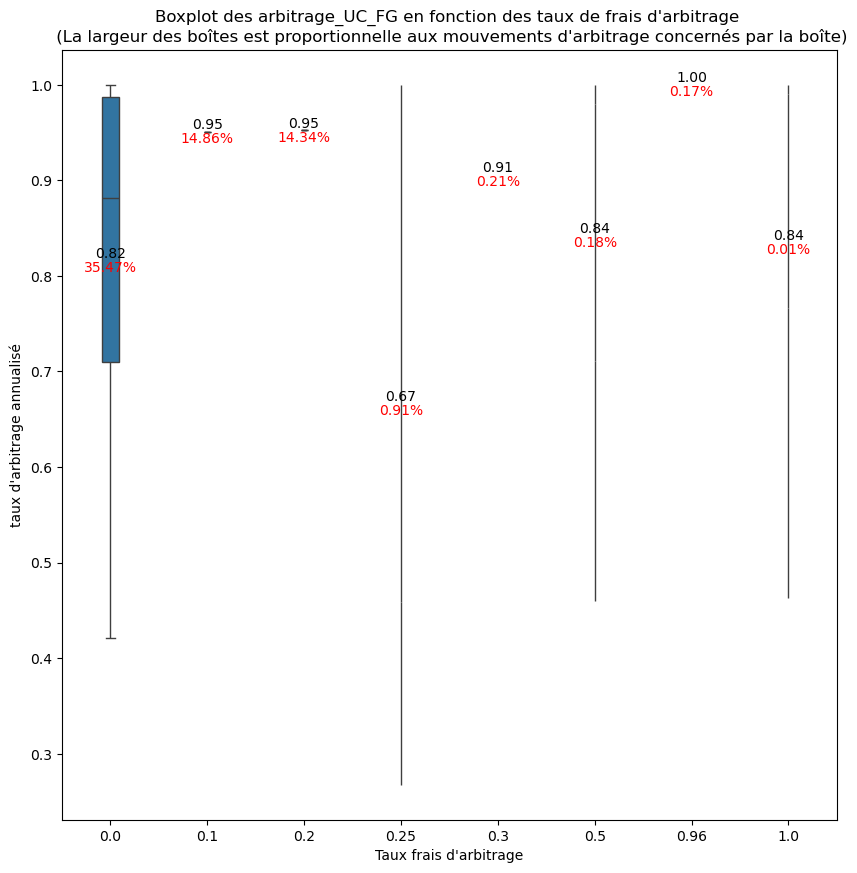

In [96]:
taux_frais_arbitrage(base_arbitrage_UC_FG, 'r_UC_FG_a', "arbitrage_UC_FG", "Taux d'arbitrage_UC_FG en fonction du taux de frais d'arbitrage")

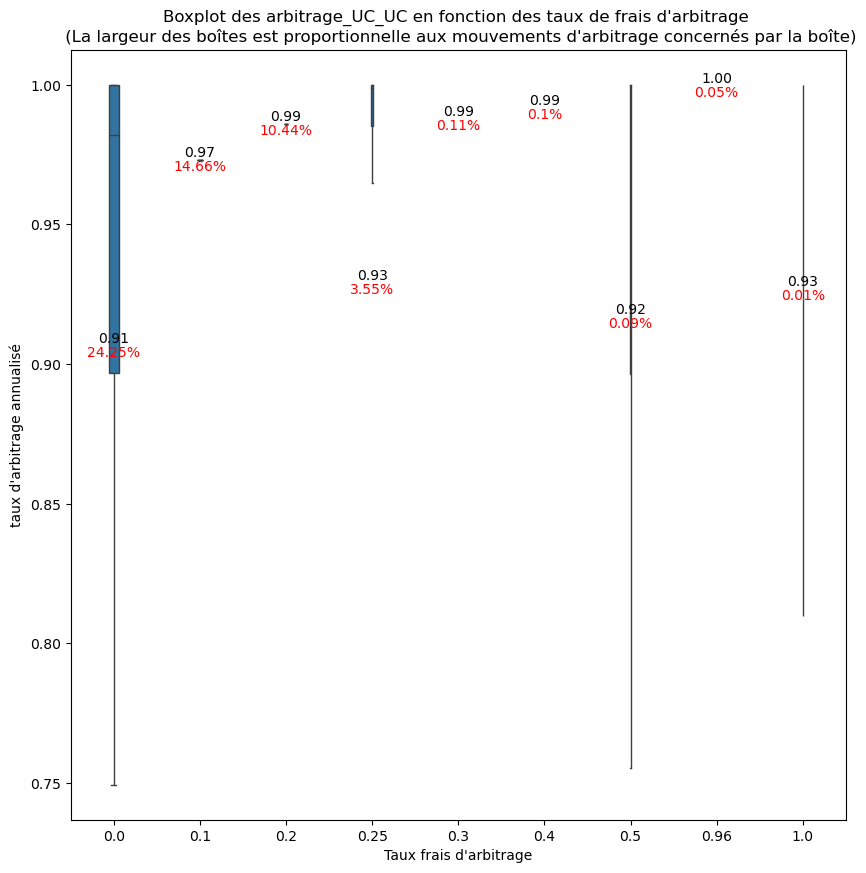

In [97]:
taux_frais_arbitrage(base_arbitrage_UC_UC, 'r_UC_UC_a', "arbitrage_UC_UC", "Taux d'arbitrage_UC_UC en fonction du taux de frais d'arbitrage")

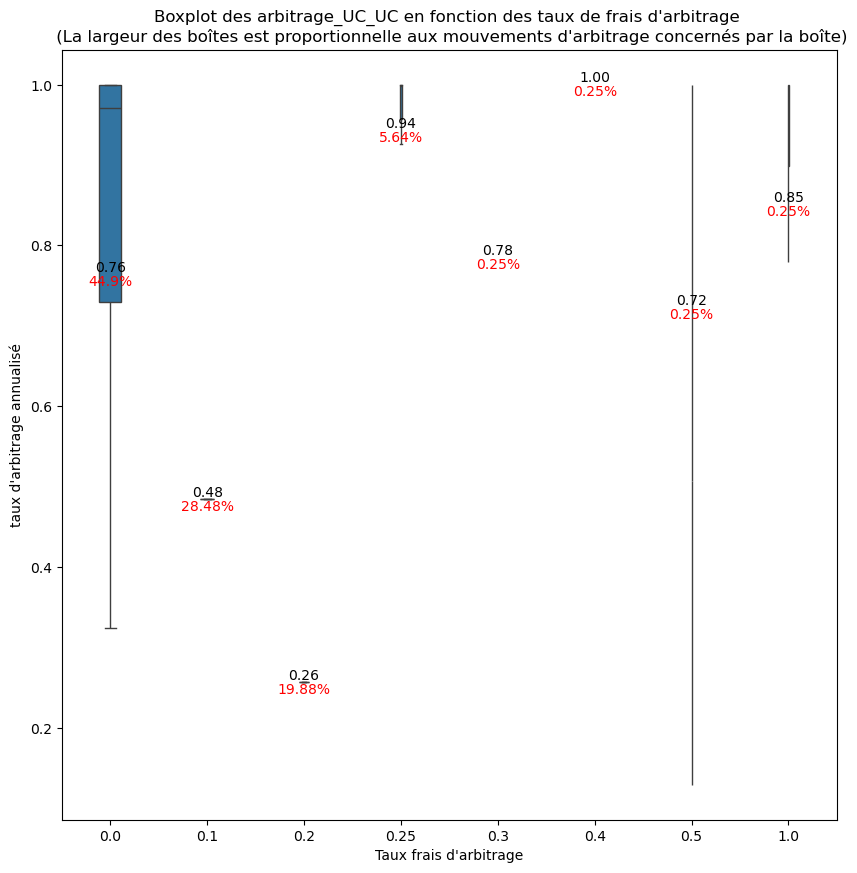

In [98]:
taux_frais_arbitrage(base_arbitrage_FG_update, "r_FG_a", "arbitrage_UC_UC", "Taux d'arbitrage_UC_FG")

In [99]:
tableau_TxFrsArb = 100 * base_multisupport_arbitrage.groupby("TX_FRS_ARB").count()/len(base_multisupport_arbitrage)
tableau_TxFrsArb[["n_sous"]]

n_sous
TX_FRS_ARB           
0,000       46.480655
0,100        0.200893
0,200        0.186012
0,250        5.245536
0,300        0.230655
0,400        0.096726
0,500       20.595238
0,960        0.014881
1,000       26.547619

In [100]:
#tableau_TxFrsArb = 100 * base_multisupport_arbitrage.groupby("TX_FRS_ARB").count()/len(base_multisupport_arbitrage)

In [101]:
#tableau_TxFrsArb_UC1 = base_multisupport_arbitrage[base_multisupport_arbitrage["r_UC_UC_a"]!=0]
#tableau_TxFrsArb_UC2 = base_multisupport_arbitrage[base_multisupport_arbitrage["r_UC_FG_a"]!=0]
#tableau_TxFrsArb_FG = base_multisupport_arbitrage[base_multisupport_arbitrage["r_FG_a"]!=0]

In [102]:
#taux_frais_arbitrage(tableau_TxFrsArb_FG, "r_FG_a", "arbitrage_UC_UC", "Taux d'arbitrage_UC_FG")

Nantissement du contrat et arbitrage

In [103]:
def nantissement_arbitrage(base, col, titre ,titre_graph):
    counts = base['TOP_MEG'].value_counts()
    plt.figure(figsize=(10, 10))
    sns.boxplot(x='TOP_MEG', y=col, data=base, showfliers=False, width= 0.5 * counts/len(base))
    means = base.groupby('TOP_MEG')[col].apply(gmean)
    for i, mean in enumerate(means):
        plt.text(i, mean, f'{mean:.2f}', ha='center', va='bottom', color='black')
        plt.text(i, mean, f'{round(100 * counts.iloc[i]/len(base),2)}%', ha='center', va='top', color='red')
    plt.xlabel("Nantissement")
    plt.ylabel("taux d'arbitrage")
    plt.title(f"Taux d'{titre} en fonction de la mise en gage du contrat")
    plt.savefig(titre_graph)
    plt.show()

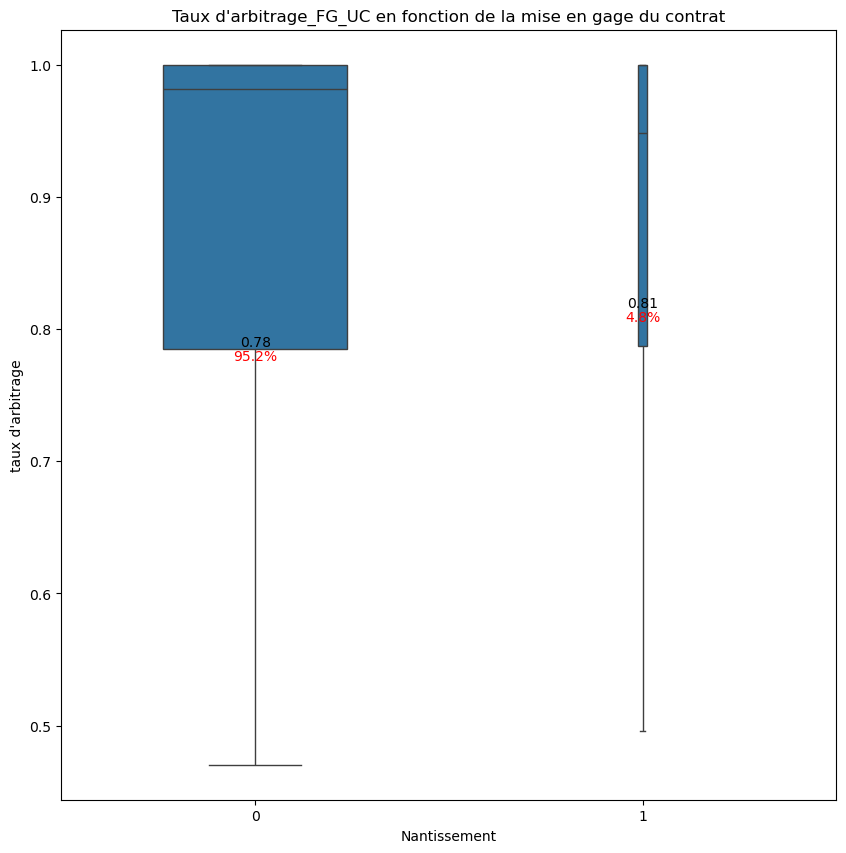

In [104]:
nantissement_arbitrage(base_arbitrage_FG_update, "r_FG_a", "arbitrage_FG_UC", "Taux d'arbitrage_FG")

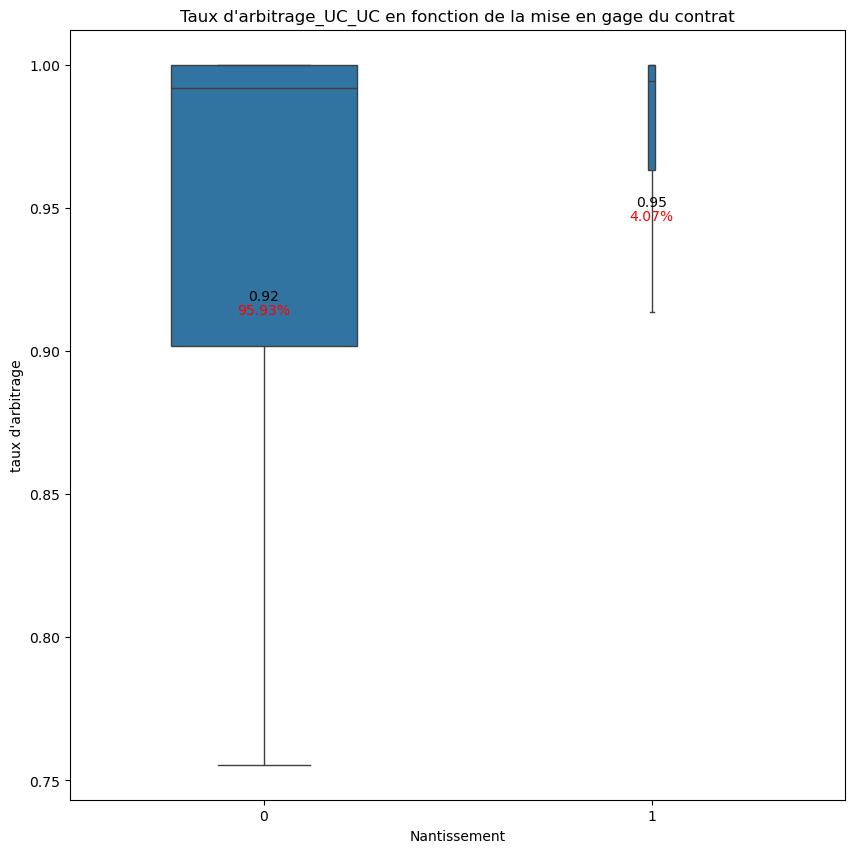

In [105]:
nantissement_arbitrage(base_arbitrage_UC_UC, 'r_UC_UC_a', "arbitrage_UC_UC", "Taux d'arbitrage_UC_UC")

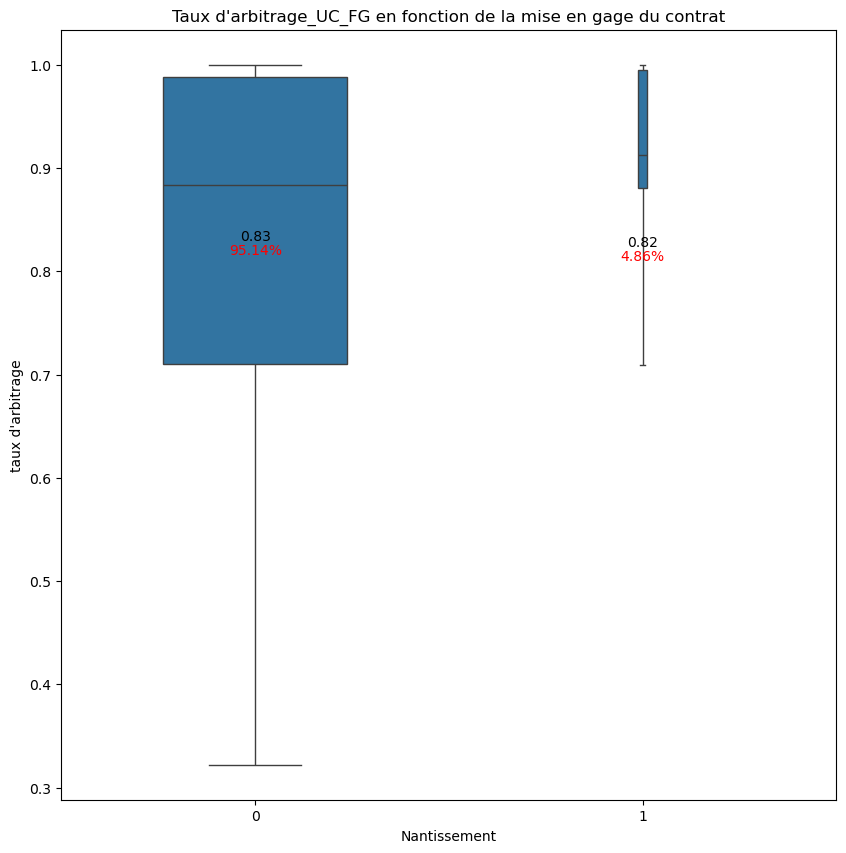

In [106]:
nantissement_arbitrage(base_arbitrage_UC_FG, 'r_UC_FG_a', "arbitrage_UC_FG", "Taux d'arbitrage_UC_FG")

In [107]:
base_multisupport_TOP_MEG = 100 * base_multisupport.groupby("TOP_MEG").count()/len(base_multisupport)
base_multisupport_TOP_MEG[['n_sous']]

n_sous
TOP_MEG           
0        96.360044
1         3.639956

In [108]:
taux_moyen

Anmois_operation  r_FG_moy  r_UC_UC_moy  r_UC_FG_moy
0          January  0.986462     0.845016     0.174717
0         February  0.958376     0.903020     0.209307
0            March  0.947861     0.783109     0.224811
0            April  0.971211     0.823694     0.245793
0              May  0.962266     0.703948     0.354396
0             June  0.712214     0.735281     0.125867
0             July  0.873615     0.858861     0.561854
0           August  0.993835     0.670240     0.266239
0        September  0.942817     0.657692     0.374071
0          October  0.985143     0.764158     0.157640
0         November  0.939808     0.992366     0.159553
0         December  0.997158     0.463485     0.582862

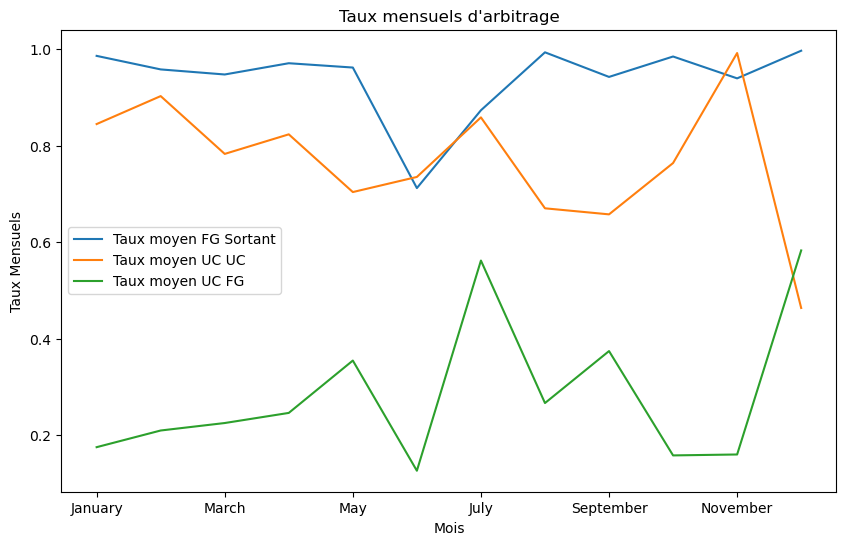

In [109]:
fig, ax = plt.subplots(figsize=(10, 6))

taux_moyen.plot(x='Anmois_operation', y='r_FG_moy', ax=ax, label='Taux moyen FG Sortant')
taux_moyen.plot(x='Anmois_operation', y='r_UC_UC_moy', ax=ax, label='Taux moyen UC UC')
taux_moyen.plot(x='Anmois_operation', y='r_UC_FG_moy', ax=ax, label='Taux moyen UC FG')

plt.title("Taux mensuels d'arbitrage")
plt.xlabel('Mois')
plt.ylabel('Taux Mensuels')
plt.legend()
plt.savefig("Evolution Mensuelle des différents taux")
plt.show()

In [110]:
base_taux = base_updte[["n_sous", "r_UC_FG_a", "r_UC_UC_a", "r_FG_a"]]

<Axes: xlabel='r_UC_UC_a', ylabel='Density'>

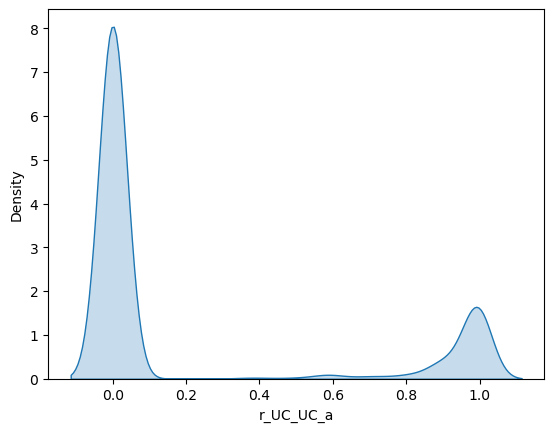

In [111]:
sns.kdeplot(data = base_taux["r_UC_UC_a"], fill = True)

# Description de la durée minimum et maximum des contrats 

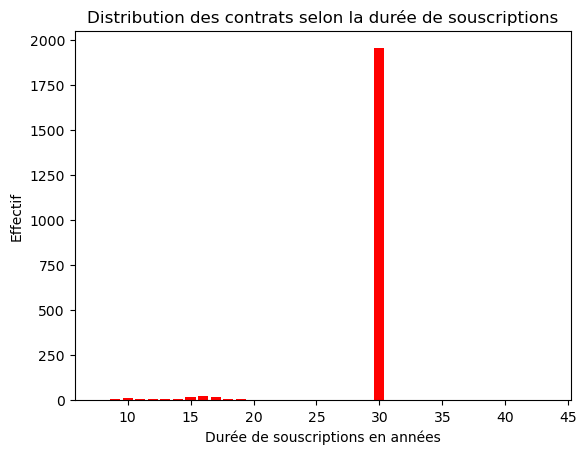

In [112]:
duree=base_multisupport[["n_sous","DUR_MIN_SOUS","DUR_MAX_SOUS","r_FG_a","DUR_SOUS"]]
duree=duree.drop_duplicates()
duree.set_index('n_sous', inplace=True)
values=duree['DUR_SOUS'].value_counts()
# Plot a bar chart
plt.bar(values.index, values, color='red')
# Add labels and title
plt.xlabel('Durée de souscriptions en années')
plt.ylabel('Effectif')
plt.title('Distribution des contrats selon la durée de souscriptions')
# Show the plot
plt.show()



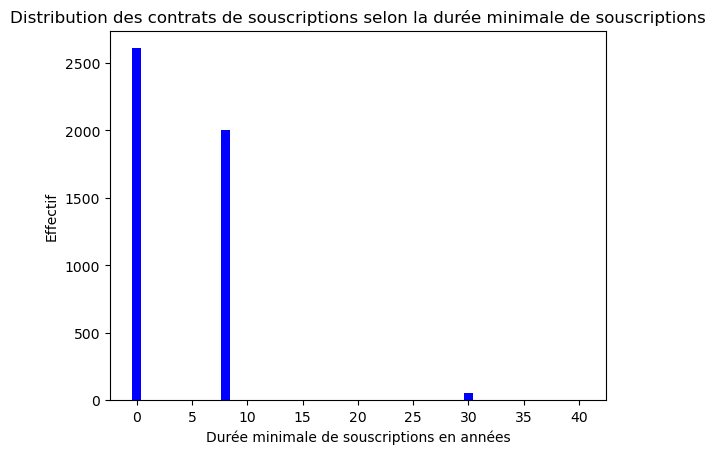

In [113]:
values=duree['DUR_MIN_SOUS'].value_counts()
# Plot a bar chart
plt.bar(values.index, values, color='blue')
# Add labels and title
plt.xlabel('Durée minimale de souscriptions en années')
plt.ylabel('Effectif')
plt.title('Distribution des contrats de souscriptions selon la durée minimale de souscriptions')

# Show the plot
plt.show()

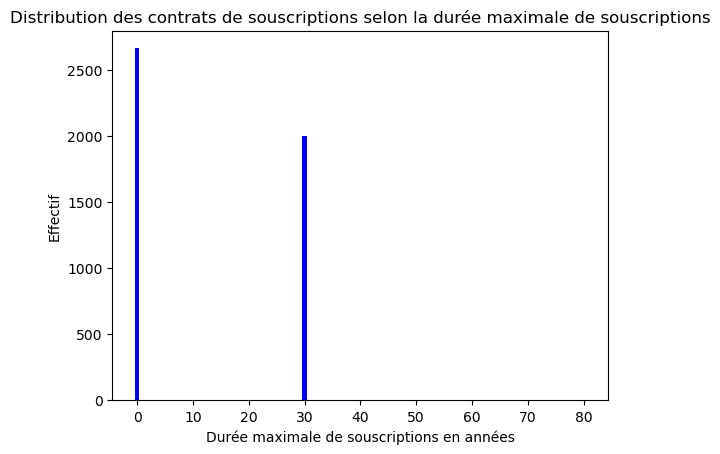

In [114]:
values=duree['DUR_MAX_SOUS'].value_counts()
# Plot a bar chart
plt.bar(values.index, values, color='blue')
# Add labels and title
plt.xlabel('Durée maximale de souscriptions en années')
plt.ylabel('Effectif')
plt.title('Distribution des contrats de souscriptions selon la durée maximale de souscriptions')

# Show the plot
plt.show()

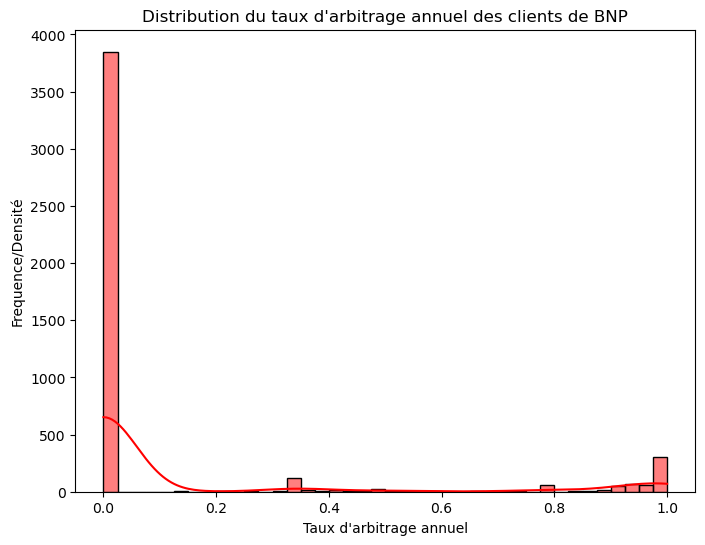

In [115]:
plt.figure(figsize=(8, 6))
sns.histplot(duree['r_FG_a'], bins=40, color='red', kde=True)
plt.title("Distribution du taux d'arbitrage annuel des clients de BNP")
plt.xlabel("Taux d'arbitrage annuel")
plt.ylabel('Frequence/Densité')
plt.show()

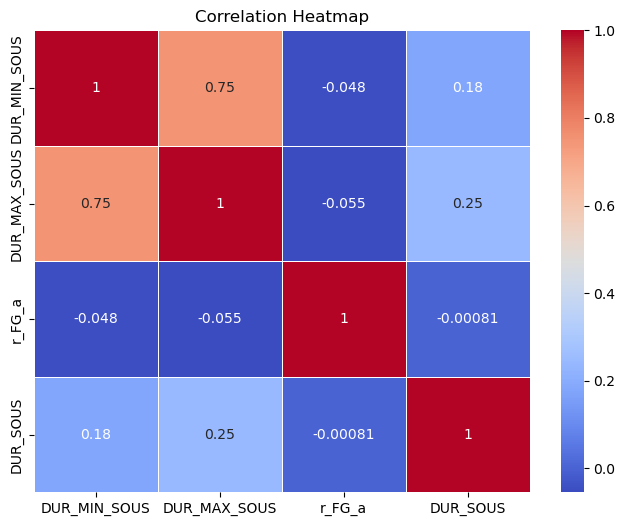

In [116]:
# Calculate the correlation matrix
correlation_matrix = duree[['DUR_MIN_SOUS','DUR_MAX_SOUS','r_FG_a','DUR_SOUS']].corr()

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=.5)

# Set plot title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

Text(0, 0.5, 'Durée minimale de souscription')

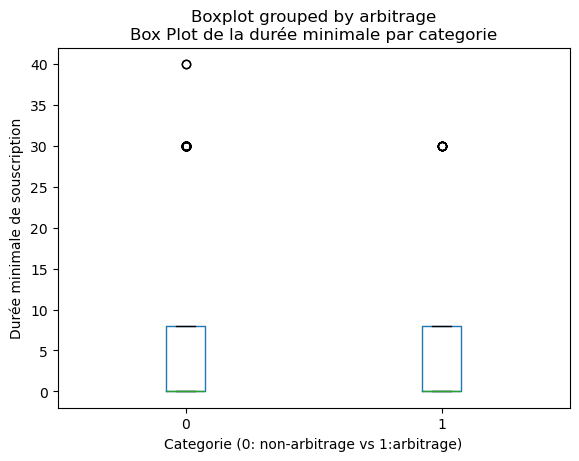

In [117]:
def custom_function(row):
    if (row['r_FG_a'] == 0):
        return 0
    else:
        return 1
duree['arbitrage']=duree.apply(custom_function,axis=1)
duree.boxplot(column='DUR_MIN_SOUS', by='arbitrage',grid=False)
# Set plot labels and title
plt.title('Box Plot de la durée minimale par categorie')
plt.xlabel('Categorie (0: non-arbitrage vs 1:arbitrage)')
plt.ylabel('Durée minimale de souscription')

# Mandat d’arbitrage, Taux minimale garantie

In [118]:
mandat=base_multisupport[['TOP_GAR','COD_TYP_MANDAT','r_FG_a']]

Text(0, 0.5, "Taux d'arbitrage annuel")

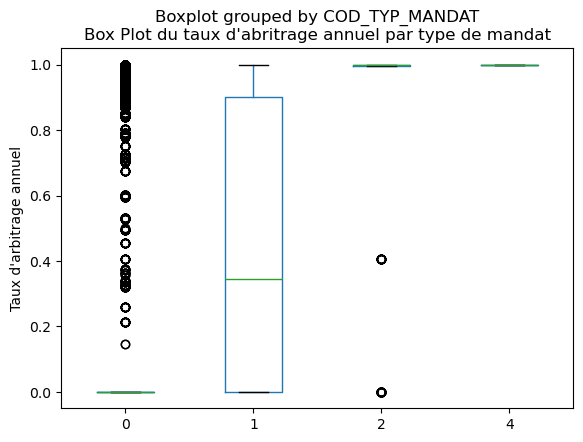

In [119]:
mandat.boxplot(column='r_FG_a', by='COD_TYP_MANDAT',grid=False)
# Set plot labels and title
plt.title("Box Plot du taux d'abritrage annuel par type de mandat")
plt.xlabel('')
plt.ylabel("Taux d'arbitrage annuel")

Text(0, 0.5, "Taux d'arbitrage annuel")

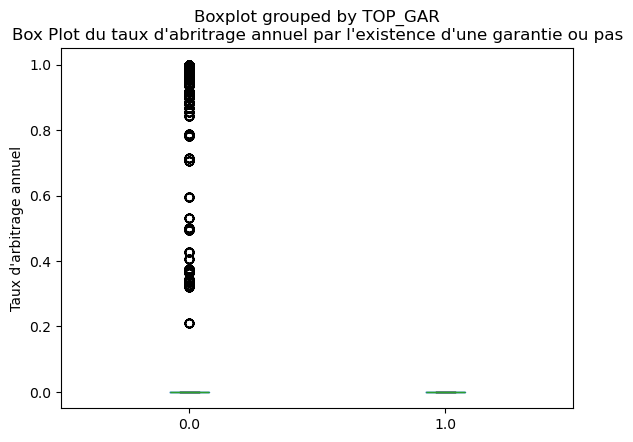

In [120]:
mandat.boxplot(column='r_FG_a', by='TOP_GAR',grid=False)
# Set plot labels and title
plt.title("Box Plot du taux d'abritrage annuel par l'existence d'une garantie ou pas")
plt.xlabel('')
plt.ylabel("Taux d'arbitrage annuel")

In [121]:
from scipy.stats import f_oneway,ttest_ind
# Statistical Test (ANOVA)
category_1_values = mandat[mandat['TOP_GAR'] == 0.0]['r_FG_a']
category_2_values = mandat[mandat['TOP_GAR'] == 1.0]['r_FG_a']

t_statistic, p_value = ttest_ind(category_1_values, category_2_values)
print(f'T-statistic: {t_statistic}, p-value: {p_value}')

if p_value < 0.05:
    print("Il y a une difference significative entre les deux categories. Donc une relation de dépendance")
else:
    print("Il y a pas de difference significative entre les deux categories. Donc une relation d'indépendance")

T-statistic: 4.329551307283237, p-value: 1.505128392598638e-05
Il y a une difference significative entre les deux categories. Donc une relation de dépendance


In [122]:
from scipy.stats import f_oneway
# Statistical Test (ANOVA)
category_0_values = mandat[mandat['COD_TYP_MANDAT'] == 0]['r_FG_a']
category_1_values = mandat[mandat['COD_TYP_MANDAT'] == 1]['r_FG_a']
category_2_values = mandat[mandat['COD_TYP_MANDAT'] == 2]['r_FG_a']
category_4_values = mandat[mandat['COD_TYP_MANDAT'] == 4]['r_FG_a']

f_statistic, p_value = f_oneway(category_0_values, category_1_values, category_2_values, category_4_values )
print(f'F-statistic: {f_statistic}, p-value: {p_value}')

if p_value < 0.05:
    print("Il y a une difference significative entre les quatre categories. Donc une relation de dépendance")
else:
    print("Il y a pas de difference significative entre les quatre categories. Donc une relation d'indépendance")

F-statistic: 3371.46166733466, p-value: 0.0
Il y a une difference significative entre les quatre categories. Donc une relation de dépendance


# Analyse suivant le code fiscal 

In [123]:
fisc=base_multisupport[["Anmois_arrete","n_sous","Anmois_eff_fisc","MTTC_PRI_FISC98","MT_VAC_FISC98","COD_FIS","r_FG_a","r_FG_m"]]
fisc['Anmois_eff_fisc'] = pd.to_datetime(fisc['Anmois_eff_fisc'], format='%Y%m')
fisc['Anmois_arrete'] = pd.to_datetime(fisc['Anmois_arrete'], format='%Y%m')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


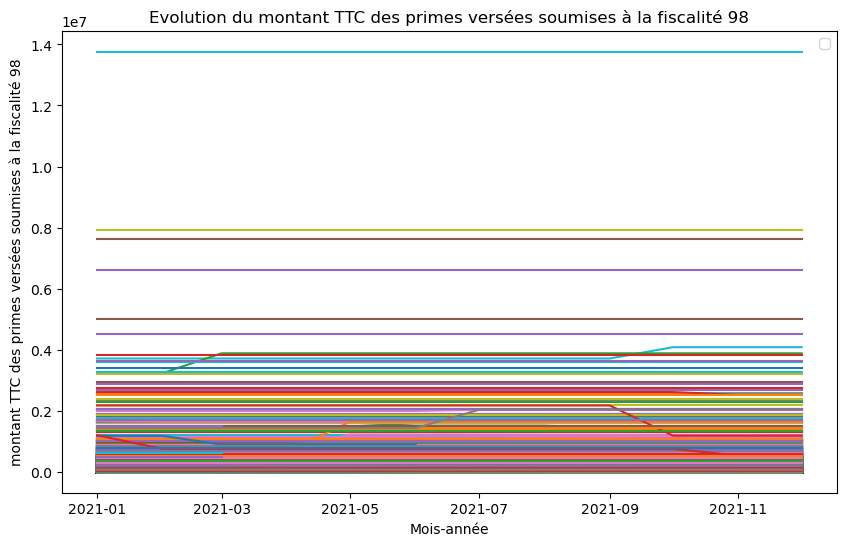

In [124]:
liste=fisc['n_sous'].unique().tolist()
plt.figure(figsize=(10, 6))
for i in liste:
    data=fisc[fisc['n_sous']==i]
    plt.plot(data['Anmois_arrete'], data["MTTC_PRI_FISC98"])
plt.title('Evolution du montant TTC des primes versées soumises à la fiscalité 98')
plt.xlabel('Mois-année')
plt.ylabel('montant TTC des primes versées soumises à la fiscalité 98')
plt.legend()
plt.show() 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


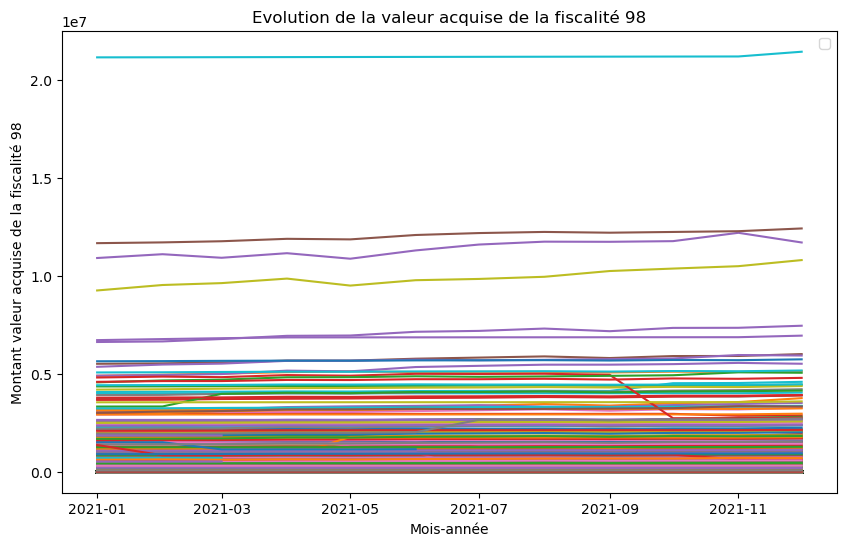

In [125]:
liste=fisc['n_sous'].unique().tolist()
plt.figure(figsize=(10, 6))
for i in liste:
    data=fisc[fisc['n_sous']==i]
    plt.plot(data['Anmois_arrete'], data["MT_VAC_FISC98"])
plt.title('Evolution de la valeur acquise de la fiscalité 98')
plt.xlabel('Mois-année')
plt.ylabel('Montant valeur acquise de la fiscalité 98')
plt.legend()
plt.show()

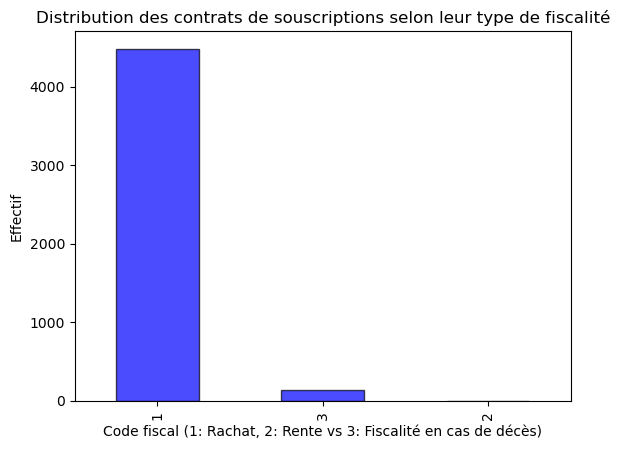

In [126]:
l=fisc[['COD_FIS','n_sous']].drop_duplicates().set_index("n_sous")
codfisc=pd.Series(l.value_counts()).reset_index()
codfisc.set_index('COD_FIS', inplace=True)
# Plot a bar chart
codfisc.plot(kind='bar', color='blue', edgecolor='black', alpha=0.7, legend=False)
# Add labels and title
plt.xlabel('Code fiscal (1: Rachat, 2: Rente vs 3: Fiscalité en cas de décès)')
plt.ylabel('Effectif')
plt.title('Distribution des contrats de souscriptions selon leur type de fiscalité')

# Show the plot
plt.show()

Text(0, 0.5, "Taux d'arbitrage annuel")

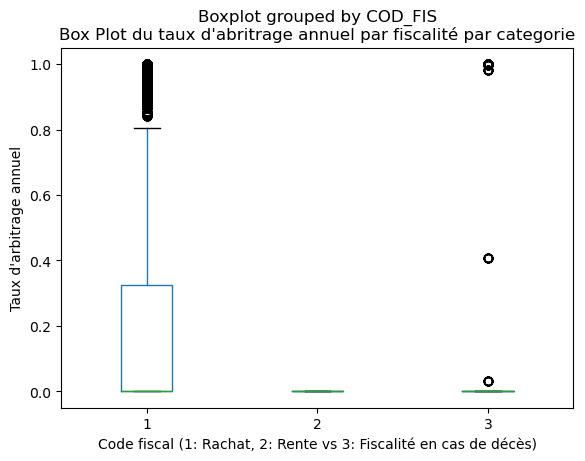

In [127]:
fisc.boxplot(column='r_FG_a', by='COD_FIS',grid=False)
# Set plot labels and title
plt.title("Box Plot du taux d'abritrage annuel par fiscalité par categorie")
plt.xlabel('Code fiscal (1: Rachat, 2: Rente vs 3: Fiscalité en cas de décès)')
plt.ylabel("Taux d'arbitrage annuel")

In [128]:
# Statistical Test (ANOVA)
category_1_values = fisc[fisc['COD_FIS'] == 1]['r_FG_a']
category_2_values = fisc[fisc['COD_FIS'] == 2]['r_FG_a']
category_3_values = fisc[fisc['COD_FIS'] == 3]['r_FG_a']

f_statistic, p_value = f_oneway(category_1_values, category_2_values, category_3_values)
print(f'F-statistic: {f_statistic}, p-value: {p_value}')

if p_value < 0.05:
    print("Il y a une difference significative entre les trois categories. Donc une relation de dépendance")
else:
    print("Il y a pas de difference significative entre les trois categories. Donc une relation d'indépendance")

F-statistic: 63.21312690130075, p-value: 3.752157422932929e-28
Il y a une difference significative entre les trois categories. Donc une relation de dépendance


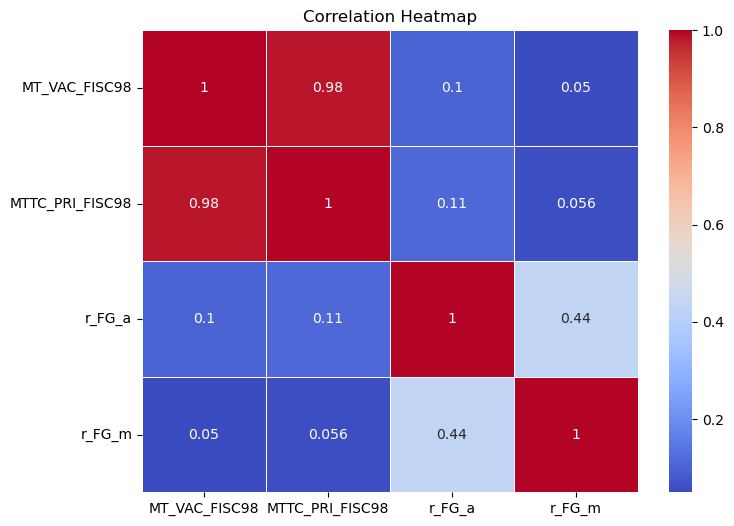

In [129]:
# Calculate the correlation matrix
correlation_matrix = fisc[['MT_VAC_FISC98','MTTC_PRI_FISC98','r_FG_a','r_FG_m']].corr()

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=.5)

# Set plot title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

# Modélisation: regression Linéaire

### 1- Conversion de variables

In [130]:
base_multisupport.columns.tolist()

['n_sous',
 'Anmois_eff_sous',
 'Anmois_eff_fisc',
 'TOP_2TETE',
 'COD_BEN_DC',
 'COD_BEN_VIE',
 'TOP_BEN_ACPT',
 'MTTC_PRI_REG_ORIG',
 'MT_PRS_VRS_ORIG',
 'MTTC_PRI_INV_ANN',
 'MTTC_PRI_INV_AP',
 'MTTC_PRI_ECH_NRAC',
 'MT_VRAC_SOUS',
 'COD_POS_SOUS',
 'COD_VRS',
 'Anmois_eff_mvt',
 'Anmois_ter_sous',
 'MTTC_PP_ACTU',
 'MBRUT_MVT',
 'COD_MVT_SC',
 'ID_PRD',
 'TOP_MEG',
 'TOP_NUPROP',
 'TOP_COSOUS',
 'TOP_K_DEMBRT',
 'TOP_PROCU',
 'MTTC_PRI_FISC98',
 'MT_VAC_FISC98',
 'DUR_SOUS',
 'Anmois_sign_sous',
 'TOP_DEROG_FRAIS_ARB',
 'TOP_CONTRAT_DIVERSIFIE',
 'MT_CGT_REEL',
 'COD_TYP_MANDAT',
 'TOP_HANDICAP',
 'reseau_fin',
 'Anmois_arrete',
 'CODPTT',
 'COD_CSP',
 'COD_FIS',
 'COD_SIT_FAM',
 'NB_ENF_CHR',
 'Anmois_DC',
 'COD_POS_CLI',
 'COD_T_CLI',
 'COD_CAT_CLI',
 'TOP_2ASS',
 'BDIS',
 'TOP_GES_PAR',
 'TOP_RENT',
 'TOP_SICAV',
 'TOP_GAR',
 'TOP_ASSU',
 'TOP_ASSU_OTO',
 'TOP_CPT_OPT',
 'TOP_ISF',
 'TOP_DIVS',
 'COD_PAYS',
 'TOP_VIE_ENT',
 'L_VIL_NAIS',
 'COD_INSEE',
 'COD_PTT_COUR',
 'COD_PAYS

In [131]:
base_multisupport.head()

n_sous  Anmois_eff_sous  Anmois_eff_fisc  TOP_2TETE  COD_BEN_DC  \
0       1           197406           197404          0           1   
1       1           197406           197404          0           1   
2       1           197406           197404          0           1   
3       1           197406           197404          0           1   
4       1           197406           197404          0           1   

   COD_BEN_VIE  TOP_BEN_ACPT  MTTC_PRI_REG_ORIG  MT_PRS_VRS_ORIG  \
0            1             0         1281038.83        382235.16   
1            1             0         1281038.83        382235.16   
2            1             0         1281038.83        382235.16   
3            1             0         1281038.83        382235.16   
4            1             0         1281038.83        382235.16   

   MTTC_PRI_INV_ANN  ...  r_UC_UC_m  r_UC_FG_m  r_FG_a  r_UC_UC_a  r_UC_FG_a  \
0               0.0  ...        0.0        0.0     0.0        0.0        0.0   
1               0.0  ...        0.0        0.0     0.0        0.0        0.0   
2               0.0  ...        0.0        0.0     0.0        0.0        0.0   
3               0.0  ...        0.0        0.0     0.0        0.0        0.0   
4               0.0  ...        0.0        0.0     0.0        0.0        0.0   

   annee_sign_sous  mois_sign_sous  anciennete  annee_nais  age  
0             1974               4          47        1948   73  
1             1974               4          47        1948   73  
2             1974               4          47        1948   73  
3             1974               4          47        1948   73  
4             1974               4          47        1948   73  

[5 rows x 115 columns]

In [132]:
cols = [col for col in base_multisupport.columns if col.startswith('TOP')]

In [133]:
base_multisupport[cols]

TOP_2TETE  TOP_BEN_ACPT  TOP_MEG  TOP_NUPROP  TOP_COSOUS  \
0               0             0        0           0           0   
1               0             0        0           0           0   
2               0             0        0           0           0   
3               0             0        0           0           0   
4               0             0        0           0           0   
...           ...           ...      ...         ...         ...   
119474          0             0        0           0           0   
119475          0             0        0           0           0   
119476          0             0        0           0           0   
119477          0             0        0           0           0   
119478          0             0        0           0           0   

        TOP_K_DEMBRT  TOP_PROCU  TOP_DEROG_FRAIS_ARB  TOP_CONTRAT_DIVERSIFIE  \
0                  0          0                    0                       0   
1                  0          0                    0                       0   
2                  0          0                    0                       0   
3                  0          0                    0                       0   
4                  0          0                    0                       0   
...              ...        ...                  ...                     ...   
119474             0          0                    0                       0   
119475             0          0                    0                       0   
119476             0          0                    0                       0   
119477             0          0                    0                       0   
119478             0          0                    0                       0   

        TOP_HANDICAP  ...  TOP_ASSU_OTO  TOP_CPT_OPT  TOP_ISF  TOP_DIVS  \
0                  0  ...           0.0            0      0.0       0.0   
1                  0  ...           0.0            0      0.0       0.0   
2                  0  ...           0.0            0      0.0       0.0   
3                  0  ...           0.0            0      0.0       0.0   
4                  0  ...           0.0            0      0.0       0.0   
...              ...  ...           ...          ...      ...       ...   
119474             0  ...           0.0            0      0.0       0.0   
119475             0  ...           0.0            0      0.0       0.0   
119476             0  ...           0.0            0      0.0       0.0   
119477             0  ...           0.0            0      0.0       0.0   
119478             0  ...           0.0            0      0.0       0.0   

        TOP_VIE_ENT  TOP_SENSIBLE  TOP_NPAI_COUR  TOP_CONTRAT_GPE  \
0               0.0             0            0.0                1   
1               0.0             0            0.0                1   
2               0.0             0            0.0                1   
3               0.0             0            0.0                1   
4               0.0             0            0.0                1   
...             ...           ...            ...              ...   
119474          0.0             0            0.0                1   
119475          0.0             0            0.0                1   
119476          0.0             0            0.0                1   
119477          0.0             0            0.0                1   
119478          0.0             0            0.0                1   

        TOP_EP_PROG  TOP_VRS_COMPL  
0               1.0            1.0  
1               1.0            1.0  
2               1.0            1.0  
3               1.0            1.0  
4               1.0            1.0  
...             ...            ...  
119474          1.0            1.0  
119475          1.0            1.0  
119476          1.0            1.0  
119477          1.0            1.0  
119478          1.0            1.0  

[63270 rows x 26 columns]

In [134]:
base_updte1=base_multisupport[['n_sous','Sexe','TOP_2TETE','TOP_BEN_ACPT','COD_POS_SOUS','COD_VRS','TOP_MEG','TOP_NUPROP','TOP_COSOUS','TOP_K_DEMBRT','TOP_PROCU','TOP_DEROG_FRAIS_ARB','TOP_CONTRAT_DIVERSIFIE','TOP_HANDICAP','NB_ENF_CHR','anciennete','age','r_UC_UC_a',
 'r_UC_FG_a',
 'COD_CAT_CLI','TOP_2ASS','TOP_GES_PAR',
 'TOP_RENT',
 'TOP_SICAV',
 'TOP_ASSU',
 'TOP_ASSU_OTO',                              
 'TOP_CPT_OPT',
 'TOP_ISF',
 'TOP_DIVS',
 'TOP_SENSIBLE',
 'COD_T_PRI',
 'TOP_CONTRAT_GPE',
 'DUR_MIN_SOUS',
 'DUR_MAX_SOUS','COD_CAT_CCA_FRC','r_FG_a']].drop_duplicates()

In [135]:
base_updte1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4738 entries, 0 to 119467
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   n_sous                  4738 non-null   int64  
 1   Sexe                    4738 non-null   object 
 2   TOP_2TETE               4738 non-null   int64  
 3   TOP_BEN_ACPT            4738 non-null   int64  
 4   COD_POS_SOUS            4738 non-null   int64  
 5   COD_VRS                 4738 non-null   int64  
 6   TOP_MEG                 4738 non-null   int64  
 7   TOP_NUPROP              4738 non-null   int64  
 8   TOP_COSOUS              4738 non-null   int64  
 9   TOP_K_DEMBRT            4738 non-null   int64  
 10  TOP_PROCU               4738 non-null   int64  
 11  TOP_DEROG_FRAIS_ARB     4738 non-null   int64  
 12  TOP_CONTRAT_DIVERSIFIE  4738 non-null   int64  
 13  TOP_HANDICAP            4738 non-null   int64  
 14  NB_ENF_CHR              4738 non-null   int

In [136]:
base_updte1=base_updte1.set_index('n_sous')
#columns_with_nan = [column for column in base_test.columns if base_test[column].astype(str).str.contains('nan').any()]

In [137]:
col=[]
for column in base_updte1.columns:
    if column.startswith('TOP'):
        col.append(column)
        base_updte1[column] = base_updte1[column].replace({"Oui": "Oui" + column, "Non": "Non" + column})
        base_updte1[column] = base_updte1[column].replace({"1": "Oui" + column, "0": "Non" + column})
        base_updte1[column] = base_updte1[column].replace({"1.0": "Oui" + column, "0.0": "Non" + column})
        base_updte1[column] = base_updte1[column].replace({1: "Oui" + column, 0: "Non" + column})
        base_updte1[column] = base_updte1[column].replace({1.0: "Oui" + column, 0.0: "Non" + column})
        base_updte1[column] = base_updte1[column].astype(str)

In [138]:
base_updte1['TOP_CONTRAT_GPE'].value_counts()

TOP_CONTRAT_GPE
OuiTOP_CONTRAT_GPE    2958
NonTOP_CONTRAT_GPE    1780
Name: count, dtype: int64

In [139]:
base_updte1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4738 entries, 1 to 9507
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sexe                    4738 non-null   object 
 1   TOP_2TETE               4738 non-null   object 
 2   TOP_BEN_ACPT            4738 non-null   object 
 3   COD_POS_SOUS            4738 non-null   int64  
 4   COD_VRS                 4738 non-null   int64  
 5   TOP_MEG                 4738 non-null   object 
 6   TOP_NUPROP              4738 non-null   object 
 7   TOP_COSOUS              4738 non-null   object 
 8   TOP_K_DEMBRT            4738 non-null   object 
 9   TOP_PROCU               4738 non-null   object 
 10  TOP_DEROG_FRAIS_ARB     4738 non-null   object 
 11  TOP_CONTRAT_DIVERSIFIE  4738 non-null   object 
 12  TOP_HANDICAP            4738 non-null   object 
 13  NB_ENF_CHR              4738 non-null   int64  
 14  anciennete              4738 non-null   int64

In [140]:
base_test=base_updte1.copy()

In [141]:
values={1:'Contrats de capitalisation en euros à prime unique ou versements libres',2:'Contrats de capitalisation en euros à primes périodiques',42:'Autres contrats individuels dassurance vie à prime unique ou versements libres',52:'Autres contrats individuels dassurance vie à primes périodiques',72:'Autres contrats collectifs en cas de vie',111:'Contrats PERP -partie FG'}
base_test['COD_CAT_CCA_FRC']=base_test['COD_CAT_CCA_FRC'].replace(values).astype('str')
#value1={1:'bénéficiaire désigné sans clause par défaut',2:'au conjoint à la date de décès, ou à défaut à mes enfants vivants ou représentés, ou à défaut mes héritiers',3:'à ses héritiers',4:'ou à défaut aux héritiers du souscripteur',6:'à son conjoint, ou à défaut, à ses enfants ou ses héritiers',7:'conformément aux souhaits que vous avez exprimés',8:' à ses enfants ou à défaut ses héritiers',11:'à mes enfants vivants ou représentés, ou à défaut mes héritiers'}
#base_test['COD_BEN_DC']=base_test['COD_BEN_DC'].replace(value1)
#value2={1:'pas de bénéficiaire',2:'au souscripteur',5:'au conjoint à la date de décès, ou à défaut à mes enfants vivants ou représentés, ou à défaut mes héritiers',6:'à des bénéficiaires selon une liste'}
#base_test['COD_BEN_VIE']=base_test['COD_BEN_VIE'].replace(value2).astype('str')
value3={5:'En cours, lassuré paie',6:'En cours, lassuré ne paie plus'}
base_test['COD_POS_SOUS']=base_test['COD_POS_SOUS'].replace(value3).astype('str')
value4={1:'chèque, espèce, mandat, titre',2:'PO sponsor',3:'Carte de crédit',6:'PO banque',7:'PO banque',8:'en attente', 9:'inconnu'}
base_test['COD_VRS']=base_test['COD_VRS'].replace(value4).astype('str')
#value5={0:'présouscription',1:'souscription',2:'modification épargne programmée',3:'changement de produit',4:'rachat partiel',5:'arbitrage', 6:'rachat total', 7:'changement caractéristiques contrat',8:'Versement exceptionnel',9:'Fin de contrat',10:'mouvements combinés',11:'changement/renouvellement de TMG',12:'remboursement sur fin de contrats',13:'décès',14:'création/modification/suppression indexation',15:'tombée prime programmée'}
#base_test['COD_MVT_SC']=base_test['COD_MVT_SC'].replace(value5)
#value6={0:'non renseigné',1:'célibataire',2:'marié',3:'veuf',4:'Divorcé',5:'vie maritale', 9:'Inconnu'}
#base_test['COD_SIT_FAM']=base_test['COD_SIT_FAM'].replace(value6)
#value7={1:'actif',2:'prospect',3:'décédé',4:'annulé'}
#base_test['COD_POS_CLI']=base_test['COD_POS_CLI'].replace(value7).astype('str')
#value8={1:'Anonyme',2:'Personne physique',3:'Personne morale',4:'Mineur',5:'Incapable majeur',6:'Individsion',7:'Incapable majeur'}
#base_test['COD_T_CLI']=base_test['COD_T_CLI'].replace(value8).astype('str')
value9={0:'Externe',1:'Externe',2:'Groupe',7:'famille',8:'entreprise'}
base_test['COD_CAT_CLI']=base_test['COD_CAT_CLI'].replace(value9).astype('str')

In [142]:
base_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4738 entries, 1 to 9507
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sexe                    4738 non-null   object 
 1   TOP_2TETE               4738 non-null   object 
 2   TOP_BEN_ACPT            4738 non-null   object 
 3   COD_POS_SOUS            4738 non-null   object 
 4   COD_VRS                 4738 non-null   object 
 5   TOP_MEG                 4738 non-null   object 
 6   TOP_NUPROP              4738 non-null   object 
 7   TOP_COSOUS              4738 non-null   object 
 8   TOP_K_DEMBRT            4738 non-null   object 
 9   TOP_PROCU               4738 non-null   object 
 10  TOP_DEROG_FRAIS_ARB     4738 non-null   object 
 11  TOP_CONTRAT_DIVERSIFIE  4738 non-null   object 
 12  TOP_HANDICAP            4738 non-null   object 
 13  NB_ENF_CHR              4738 non-null   int64  
 14  anciennete              4738 non-null   int64

In [143]:
base_test.isnull().sum()

Sexe                      0
TOP_2TETE                 0
TOP_BEN_ACPT              0
COD_POS_SOUS              0
COD_VRS                   0
TOP_MEG                   0
TOP_NUPROP                0
TOP_COSOUS                0
TOP_K_DEMBRT              0
TOP_PROCU                 0
TOP_DEROG_FRAIS_ARB       0
TOP_CONTRAT_DIVERSIFIE    0
TOP_HANDICAP              0
NB_ENF_CHR                0
anciennete                0
age                       0
r_UC_UC_a                 0
r_UC_FG_a                 0
COD_CAT_CLI               0
TOP_2ASS                  0
TOP_GES_PAR               0
TOP_RENT                  0
TOP_SICAV                 0
TOP_ASSU                  0
TOP_ASSU_OTO              0
TOP_CPT_OPT               0
TOP_ISF                   0
TOP_DIVS                  0
TOP_SENSIBLE              0
COD_T_PRI                 0
TOP_CONTRAT_GPE           0
DUR_MIN_SOUS              0
DUR_MAX_SOUS              0
COD_CAT_CCA_FRC           0
r_FG_a                    0
dtype: int64

In [144]:
mode_top_assu=base_test['TOP_ASSU'].mode()[0]
base_test['TOP_ASSU'].fillna(mode_top_assu, inplace=True)

mode2=base_test['TOP_ASSU_OTO'].mode()[0]
base_test['TOP_ASSU_OTO'].fillna(mode2, inplace=True)

mode_top_assu=base_test['TOP_ISF'].mode()[0]
base_test['TOP_ISF'].fillna(mode_top_assu, inplace=True)

mode_top_assu=base_test['TOP_DIVS'].mode()[0]
base_test['TOP_DIVS'].fillna(mode_top_assu, inplace=True)

#mode_top_assu=base_test['TOP_VIE_ENT'].mode()[0]
#base_test['TOP_VIE_ENT'].fillna(mode_top_assu, inplace=True)

#mode_top_assu=base_test['TOP_NPAI_COUR'].mode()[0]
#base_test['TOP_NPAI_COUR'].fillna(mode_top_assu, inplace=True)

#mode_top_assu=base_test['TOP_EP_PROG'].mode()[0]
#base_test['TOP_EP_PROG'].fillna(mode_top_assu, inplace=True)


In [145]:
base_test.isnull().sum()

Sexe                      0
TOP_2TETE                 0
TOP_BEN_ACPT              0
COD_POS_SOUS              0
COD_VRS                   0
TOP_MEG                   0
TOP_NUPROP                0
TOP_COSOUS                0
TOP_K_DEMBRT              0
TOP_PROCU                 0
TOP_DEROG_FRAIS_ARB       0
TOP_CONTRAT_DIVERSIFIE    0
TOP_HANDICAP              0
NB_ENF_CHR                0
anciennete                0
age                       0
r_UC_UC_a                 0
r_UC_FG_a                 0
COD_CAT_CLI               0
TOP_2ASS                  0
TOP_GES_PAR               0
TOP_RENT                  0
TOP_SICAV                 0
TOP_ASSU                  0
TOP_ASSU_OTO              0
TOP_CPT_OPT               0
TOP_ISF                   0
TOP_DIVS                  0
TOP_SENSIBLE              0
COD_T_PRI                 0
TOP_CONTRAT_GPE           0
DUR_MIN_SOUS              0
DUR_MAX_SOUS              0
COD_CAT_CCA_FRC           0
r_FG_a                    0
dtype: int64

In [146]:
base_test["TOP_ASSU_OTO"]=base_test["TOP_ASSU_OTO"].replace("nan","NonTOP_ASSU_OTO")
base_test["TOP_ASSU"]=base_test["TOP_ASSU"].replace("nan","OuiTOP_ASSU")
base_test["TOP_ISF"]=base_test["TOP_ISF"].replace("nan","NonTOP_ISF")
base_test["TOP_DIVS"]=base_test["TOP_DIVS"].replace("nan","NonTOP_DIVS")
base_test["COD_CAT_CLI"]=base_test["COD_CAT_CLI"].replace("0","Externe")

In [147]:
base_test["COD_CAT_CLI"].value_counts()

COD_CAT_CLI
Externe    3844
Groupe      818
famille      76
Name: count, dtype: int64

In [148]:
# Exporter le DataFrame vers un fichier CSV
base_test.to_csv('acp1.csv', index=True)

In [149]:
base_test.reset_index(drop=True, inplace=True)

# Création des catégories pour les classifications

In [150]:
# Create a new categorical column based on the condition
base_test['r_FG_a_cat'] = base_test['r_FG_a'].apply(lambda x: 'arbitrage' if (x > 0.0) else 'Noarbitrage')
base_test['r_UC_UC_cat'] = base_test['r_UC_UC_a'].apply(lambda x: 'arbitrage' if (x > 0.0) else 'Noarbitrage')
base_test['r_UC_FG_cat'] = base_test['r_UC_FG_a'].apply(lambda x: 'arbitrage' if (x > 0.0) else 'Noarbitrage')

In [151]:
#On recupere distingue les colonnes numériques des colonnes catégorielles
cat=[]
num=[]
for i in base_test.columns:
    if (base_test[i].dtypes=="object"):
        cat.append(i)
    else:
        num.append(i)

In [152]:
base_test[num].isna().sum().sort_values(ascending=False)
base_test[cat].isna().sum().sort_values(ascending=False)

Sexe                      0
TOP_2TETE                 0
TOP_BEN_ACPT              0
COD_POS_SOUS              0
COD_VRS                   0
TOP_MEG                   0
TOP_NUPROP                0
TOP_COSOUS                0
TOP_K_DEMBRT              0
TOP_PROCU                 0
TOP_DEROG_FRAIS_ARB       0
TOP_CONTRAT_DIVERSIFIE    0
TOP_HANDICAP              0
COD_CAT_CLI               0
TOP_2ASS                  0
TOP_GES_PAR               0
TOP_RENT                  0
TOP_SICAV                 0
TOP_ASSU                  0
TOP_ASSU_OTO              0
TOP_CPT_OPT               0
TOP_ISF                   0
TOP_DIVS                  0
TOP_SENSIBLE              0
COD_T_PRI                 0
TOP_CONTRAT_GPE           0
COD_CAT_CCA_FRC           0
r_FG_a_cat                0
r_UC_UC_cat               0
r_UC_FG_cat               0
dtype: int64

# Classification

In [153]:
import xgboost as xgb
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree, export_text
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from xgboost import plot_importance
from sklearn.linear_model import Lasso,LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [154]:
#On transforme éclate les variables catégorielles là par catégorie
one_hot_data = pd.get_dummies(base_test,drop_first=True)

In [155]:
one_hot_data.columns.tolist()

['NB_ENF_CHR',
 'anciennete',
 'age',
 'r_UC_UC_a',
 'r_UC_FG_a',
 'DUR_MIN_SOUS',
 'DUR_MAX_SOUS',
 'r_FG_a',
 'Sexe_M',
 'TOP_2TETE_OuiTOP_2TETE',
 'TOP_BEN_ACPT_OuiTOP_BEN_ACPT',
 'COD_POS_SOUS_En cours, lassuré paie',
 'COD_VRS_PO sponsor',
 'COD_VRS_chèque, espèce, mandat, titre',
 'COD_VRS_en attente',
 'COD_VRS_inconnu',
 'TOP_MEG_OuiTOP_MEG',
 'TOP_NUPROP_OuiTOP_NUPROP',
 'TOP_COSOUS_OuiTOP_COSOUS',
 'TOP_K_DEMBRT_OuiTOP_K_DEMBRT',
 'TOP_PROCU_OuiTOP_PROCU',
 'TOP_DEROG_FRAIS_ARB_OuiTOP_DEROG_FRAIS_ARB',
 'TOP_CONTRAT_DIVERSIFIE_OuiTOP_CONTRAT_DIVERSIFIE',
 'TOP_HANDICAP_OuiTOP_HANDICAP',
 'COD_CAT_CLI_Groupe',
 'COD_CAT_CLI_famille',
 'TOP_GES_PAR_OuiTOP_GES_PAR',
 'TOP_RENT_OuiTOP_RENT',
 'TOP_SICAV_OuiTOP_SICAV',
 'TOP_ASSU_OuiTOP_ASSU',
 'TOP_ASSU_OTO_OuiTOP_ASSU_OTO',
 'TOP_CPT_OPT_OuiTOP_CPT_OPT',
 'TOP_ISF_OuiTOP_ISF',
 'TOP_DIVS_OuiTOP_DIVS',
 'TOP_SENSIBLE_OuiTOP_SENSIBLE',
 'COD_T_PRI_PU',
 'TOP_CONTRAT_GPE_OuiTOP_CONTRAT_GPE',
 'r_FG_a_cat_arbitrage',
 'r_UC_UC_cat_a

# Classification taux d'arbitrage FG_UC

In [156]:
X=one_hot_data.drop(["r_UC_UC_a","r_UC_FG_a","r_FG_a","r_FG_a_cat_arbitrage",'r_UC_UC_cat_arbitrage','r_UC_FG_cat_arbitrage'], axis=1)
y=one_hot_data['r_FG_a_cat_arbitrage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [157]:
#On fait du oversampling pour réequilibrer la base de données.

# concatenate our training data back together
df = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
df_majority = df[df.r_FG_a_cat_arbitrage==0]
df_minority = df[df.r_FG_a_cat_arbitrage==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=1234) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.r_FG_a_cat_arbitrage.value_counts()

r_FG_a_cat_arbitrage
False    2731
True     2731
Name: count, dtype: int64

In [158]:
X_train_upsam=df_upsampled.drop(['r_FG_a_cat_arbitrage'],axis=1)
y_train_upsam=df_upsampled['r_FG_a_cat_arbitrage']

# Arbre de décision

[Text(0.5, 0.9, 'age <= 67.5\ngini = 0.5\nsamples = 5462\nvalue = [2731, 2731]'),
 Text(0.25, 0.7, 'age <= 35.5\ngini = 0.472\nsamples = 1569\nvalue = [969.0, 600.0]'),
 Text(0.125, 0.5, 'COD_CAT_CLI_Groupe <= 0.5\ngini = 0.192\nsamples = 121\nvalue = [108, 13]'),
 Text(0.0625, 0.3, 'anciennete <= 21.5\ngini = 0.118\nsamples = 111\nvalue = [104.0, 7.0]'),
 Text(0.03125, 0.1, '\n  (...)  \n'),
 Text(0.09375, 0.1, '\n  (...)  \n'),
 Text(0.1875, 0.3, 'age <= 21.5\ngini = 0.48\nsamples = 10\nvalue = [4, 6]'),
 Text(0.15625, 0.1, '\n  (...)  \n'),
 Text(0.21875, 0.1, '\n  (...)  \n'),
 Text(0.375, 0.5, 'TOP_K_DEMBRT_OuiTOP_K_DEMBRT <= 0.5\ngini = 0.482\nsamples = 1448\nvalue = [861, 587]'),
 Text(0.3125, 0.3, 'anciennete <= 26.5\ngini = 0.475\nsamples = 1366\nvalue = [836, 530]'),
 Text(0.28125, 0.1, '\n  (...)  \n'),
 Text(0.34375, 0.1, '\n  (...)  \n'),
 Text(0.4375, 0.3, 'age <= 60.5\ngini = 0.424\nsamples = 82\nvalue = [25.0, 57.0]'),
 Text(0.40625, 0.1, '\n  (...)  \n'),
 Text(0.46875

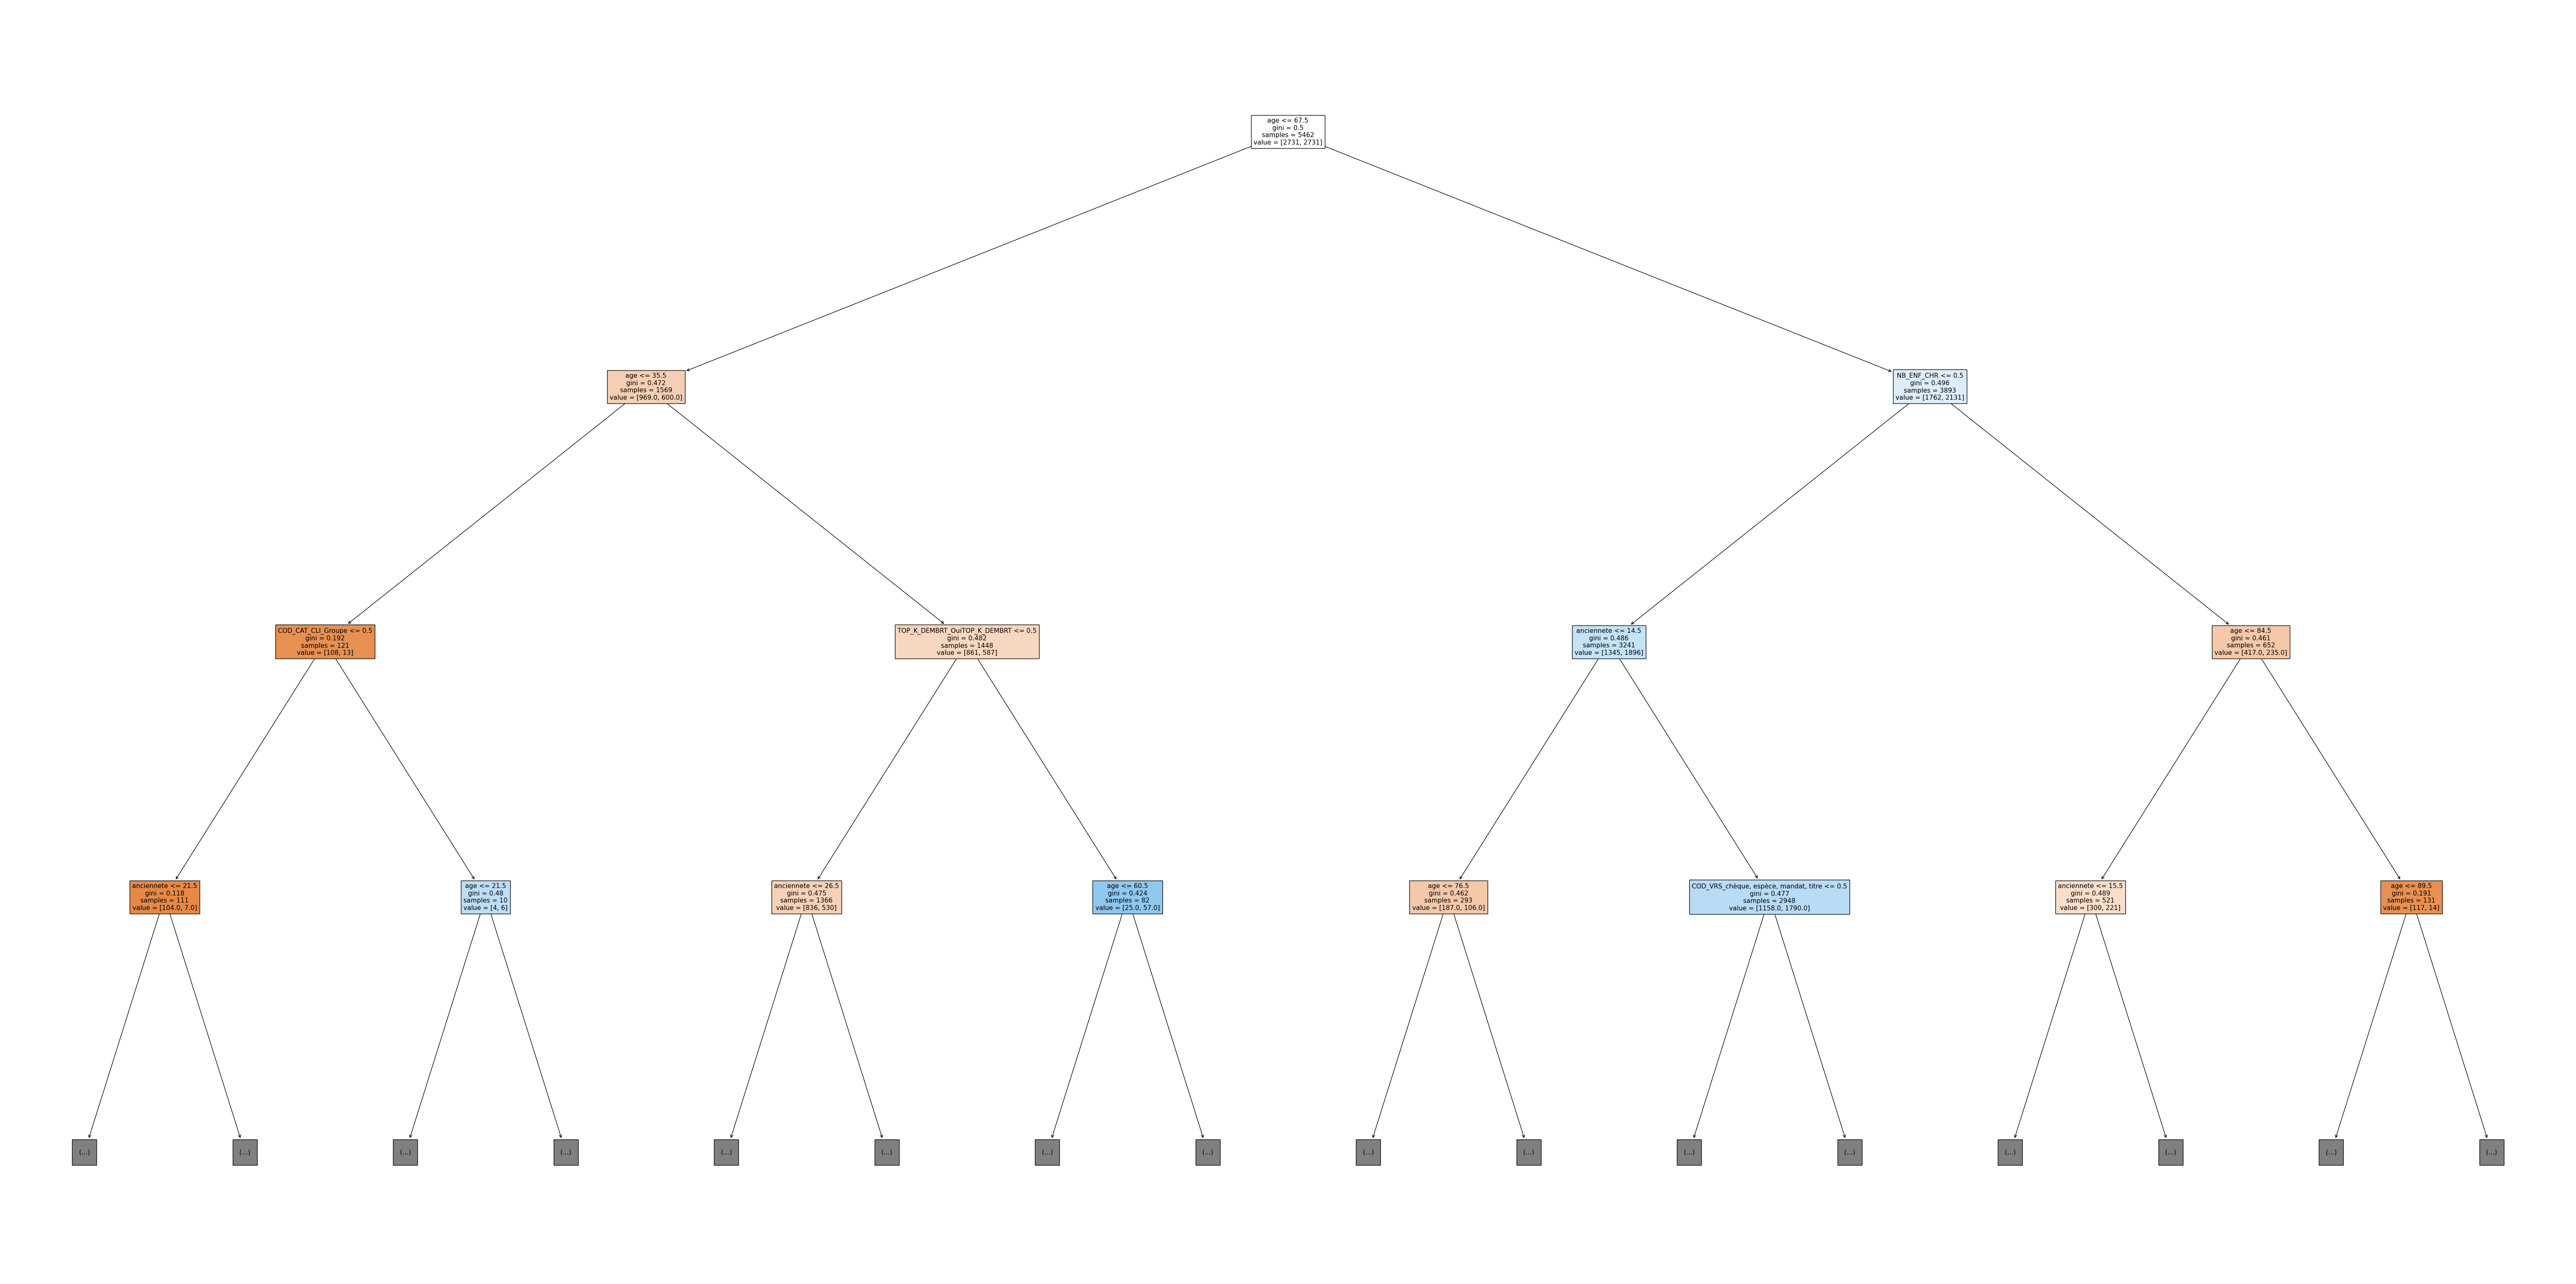

In [159]:
# Define the parameter grid for hyperparameter tuning
param_grid = {'max_depth': list(range(3, 16))}

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Perform Grid Search to find the best max_depth
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train_upsam, y_train_upsam)

# Get the best estimator
best_clf = grid_search.best_estimator_

# Train Decision Tree Classifer with the best max_depth
best_clf.fit(X_train_upsam, y_train_upsam)

# Predict the response for test dataset
y_pred = best_clf.predict(X_test)

# Plot the decision tree with the best max_depth
plt.figure(figsize=(80, 40))
plot_tree(best_clf, feature_names=X_train_upsam.columns.tolist(), max_depth=3, filled=True)



In [160]:
tree_text = export_text(best_clf, max_depth=10, feature_names=list(X_train_upsam.columns))
print(tree_text[:5000])

|--- age <= 67.50
|   |--- age <= 35.50
|   |   |--- COD_CAT_CLI_Groupe <= 0.50
|   |   |   |--- anciennete <= 21.50
|   |   |   |   |--- class: False
|   |   |   |--- anciennete >  21.50
|   |   |   |   |--- anciennete <= 22.50
|   |   |   |   |   |--- age <= 27.50
|   |   |   |   |   |   |--- Sexe_M <= 0.50
|   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |--- Sexe_M >  0.50
|   |   |   |   |   |   |   |--- age <= 24.50
|   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |   |--- age >  24.50
|   |   |   |   |   |   |   |   |--- age <= 25.50
|   |   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |   |   |--- age >  25.50
|   |   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |--- age >  27.50
|   |   |   |   |   |   |--- age <= 30.00
|   |   |   |   |   |   |   |--- Sexe_M <= 0.50
|   |   |   |   |   |   |   |   |--- age <= 28.50
|   |   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   | 

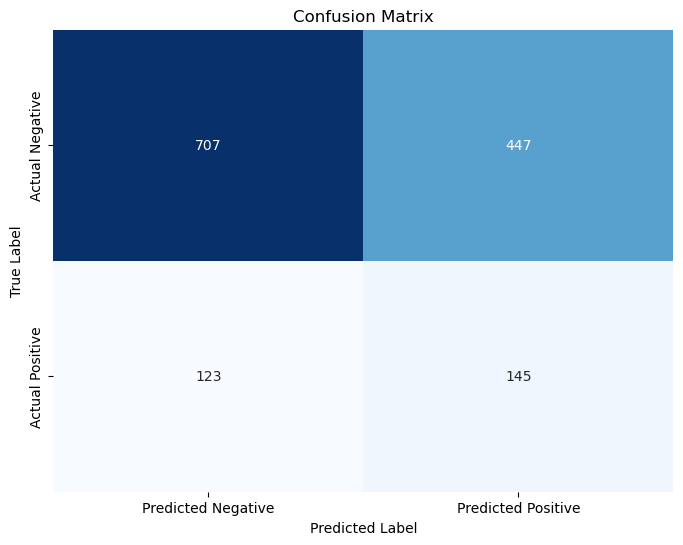

In [161]:
conf_matrix = confusion_matrix(y_test, y_pred)
# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Algorithme XGBOOST 

In [162]:
# Train XGBoost classifier
model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [163]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.83%


<Figure size 1000x600 with 0 Axes>

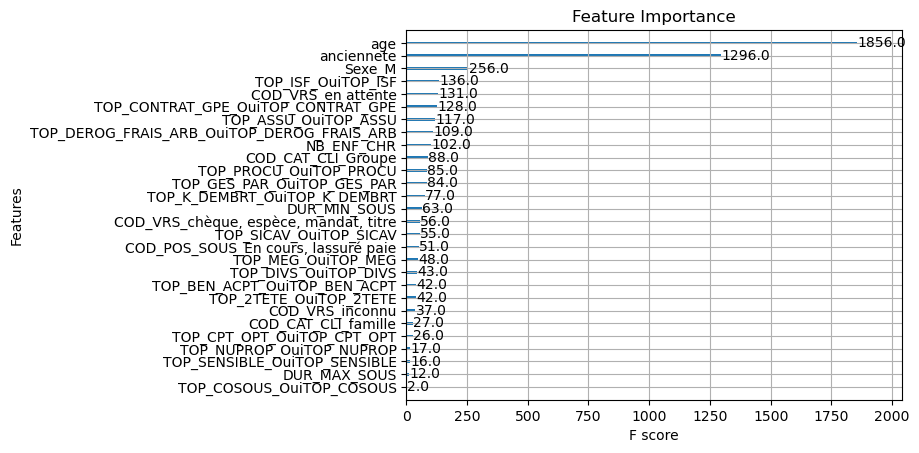

In [164]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(model)
plt.title("Feature Importance")
plt.show()

# Classification taux d'arbitrage UC_UC

In [165]:
X=one_hot_data.drop(["r_UC_UC_a","r_UC_FG_a","r_FG_a","r_FG_a_cat_arbitrage",'r_UC_UC_cat_arbitrage','r_UC_FG_cat_arbitrage'], axis=1)
y=one_hot_data['r_UC_UC_cat_arbitrage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [166]:
#On fait du oversampling pour réequilibrer la base de données.

# concatenate our training data back together
df = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
df_majority = df[df.r_UC_UC_cat_arbitrage==0]
df_minority = df[df.r_UC_UC_cat_arbitrage==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=1234) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.r_UC_UC_cat_arbitrage.value_counts()

r_UC_UC_cat_arbitrage
False    2189
True     2189
Name: count, dtype: int64

In [167]:
X_train_upsam=df_upsampled.drop(['r_UC_UC_cat_arbitrage'],axis=1)
y_train_upsam=df_upsampled['r_UC_UC_cat_arbitrage']

# Arbre de décision

[Text(0.4732142857142857, 0.9, 'age <= 57.5\ngini = 0.5\nsamples = 4378\nvalue = [2189, 2189]'),
 Text(0.23214285714285715, 0.7, 'anciennete <= 31.5\ngini = 0.433\nsamples = 658\nvalue = [449.0, 209.0]'),
 Text(0.14285714285714285, 0.5, 'TOP_MEG_OuiTOP_MEG <= 0.5\ngini = 0.425\nsamples = 642\nvalue = [445, 197]'),
 Text(0.07142857142857142, 0.3, 'anciennete <= 12.5\ngini = 0.413\nsamples = 610\nvalue = [432, 178]'),
 Text(0.03571428571428571, 0.1, '\n  (...)  \n'),
 Text(0.10714285714285714, 0.1, '\n  (...)  \n'),
 Text(0.21428571428571427, 0.3, 'age <= 56.5\ngini = 0.482\nsamples = 32\nvalue = [13, 19]'),
 Text(0.17857142857142858, 0.1, '\n  (...)  \n'),
 Text(0.25, 0.1, '\n  (...)  \n'),
 Text(0.32142857142857145, 0.5, 'TOP_GES_PAR_OuiTOP_GES_PAR <= 0.5\ngini = 0.375\nsamples = 16\nvalue = [4, 12]'),
 Text(0.2857142857142857, 0.3, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.35714285714285715, 0.3, 'anciennete <= 33.5\ngini = 0.245\nsamples = 14\nvalue = [2, 12]'),
 Text(0.321

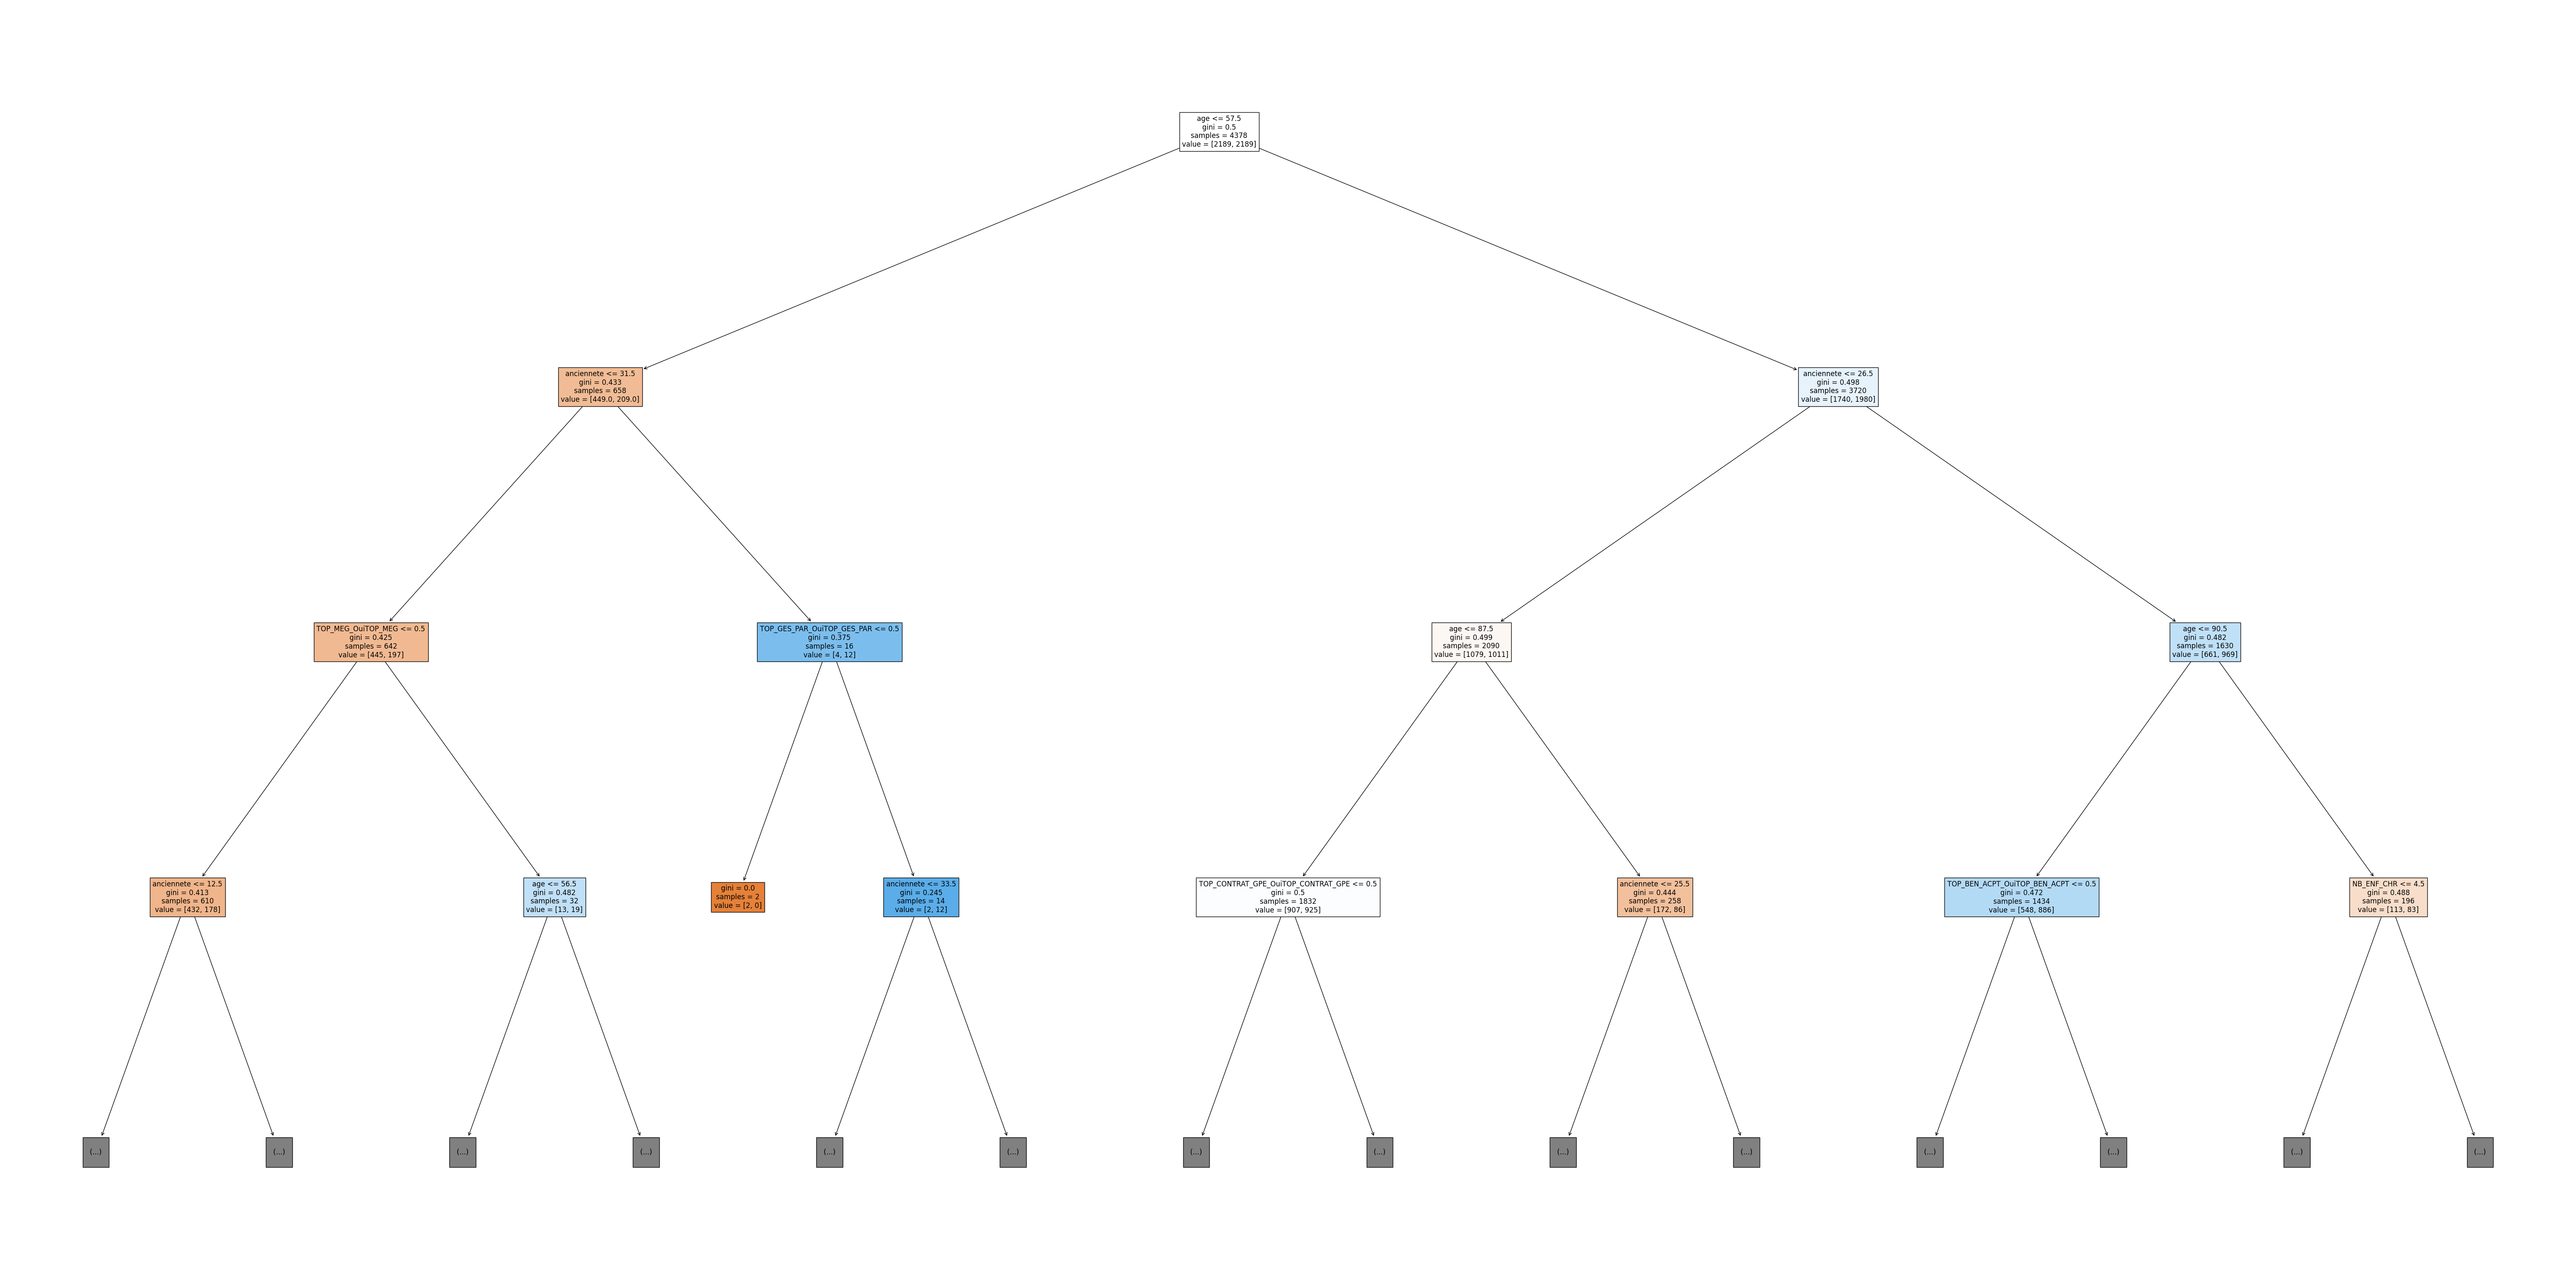

In [168]:
# Define the parameter grid for hyperparameter tuning
param_grid = {'max_depth': list(range(3, 16))}

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Perform Grid Search to find the best max_depth
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train_upsam, y_train_upsam)

# Get the best estimator
best_clf = grid_search.best_estimator_

# Train Decision Tree Classifer with the best max_depth
best_clf.fit(X_train_upsam, y_train_upsam)

# Predict the response for test dataset
y_pred = best_clf.predict(X_test)

# Plot the decision tree with the best max_depth
plt.figure(figsize=(80, 40))
plot_tree(best_clf, feature_names=X_train_upsam.columns.tolist(), max_depth=3, filled=True)

In [169]:
tree_text = export_text(best_clf, max_depth=10, feature_names=list(X_train_upsam.columns))
print(tree_text[:5000])

|--- age <= 57.50
|   |--- anciennete <= 31.50
|   |   |--- TOP_MEG_OuiTOP_MEG <= 0.50
|   |   |   |--- anciennete <= 12.50
|   |   |   |   |--- age <= 49.50
|   |   |   |   |   |--- anciennete <= 10.50
|   |   |   |   |   |   |--- Sexe_M <= 0.50
|   |   |   |   |   |   |   |--- anciennete <= 9.50
|   |   |   |   |   |   |   |   |--- age <= 45.00
|   |   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |   |   |--- age >  45.00
|   |   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |   |--- anciennete >  9.50
|   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |--- Sexe_M >  0.50
|   |   |   |   |   |   |   |--- age <= 30.00
|   |   |   |   |   |   |   |   |--- age <= 26.00
|   |   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |   |   |--- age >  26.00
|   |   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |   |--- age >  30.00
|   |   |   |   |   |   |   |   |--- class: False


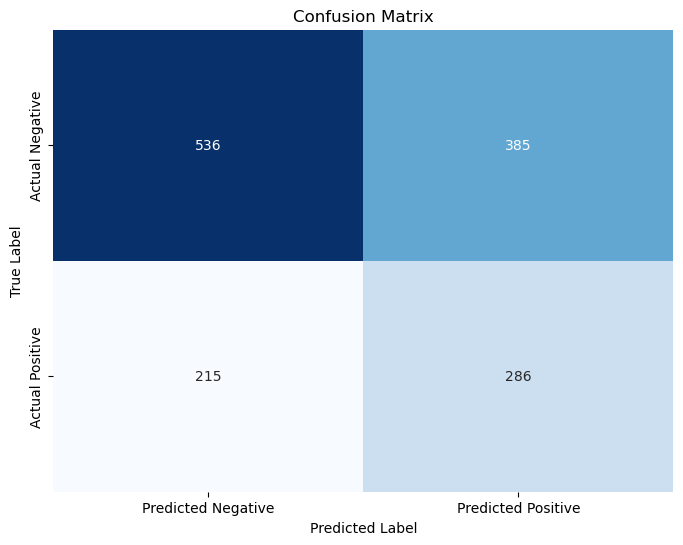

In [170]:
conf_matrix = confusion_matrix(y_test, y_pred)
# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Algorithme XGBOOST 

In [171]:
# Train XGBoost classifier
model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [172]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 63.85%


<Figure size 1000x600 with 0 Axes>

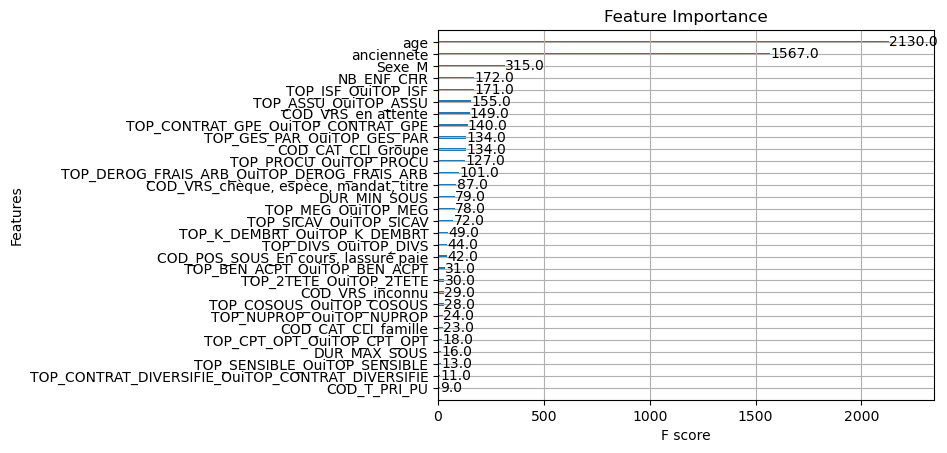

In [173]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(model)
plt.title("Feature Importance")
plt.show()

# Classification taux d'arbitrage UC_FG


In [174]:
X=one_hot_data.drop(["r_UC_UC_a","r_UC_FG_a","r_FG_a","r_FG_a_cat_arbitrage",'r_UC_UC_cat_arbitrage','r_UC_FG_cat_arbitrage'], axis=1)
y=one_hot_data['r_UC_FG_cat_arbitrage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [175]:
#On fait du oversampling pour réequilibrer la base de données.

# concatenate our training data back together
df = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
df_majority = df[df.r_UC_FG_cat_arbitrage==0]
df_minority = df[df.r_UC_FG_cat_arbitrage==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=1234) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.r_UC_FG_cat_arbitrage.value_counts()

X_train_upsam=df_upsampled.drop(['r_UC_FG_cat_arbitrage'],axis=1)
y_train_upsam=df_upsampled['r_UC_FG_cat_arbitrage']

# Arbre de décision

[Text(0.5, 0.9, 'NB_ENF_CHR <= 0.5\ngini = 0.5\nsamples = 5514\nvalue = [2757, 2757]'),
 Text(0.25, 0.7, 'anciennete <= 19.5\ngini = 0.494\nsamples = 4655\nvalue = [2082.0, 2573.0]'),
 Text(0.125, 0.5, 'TOP_2TETE_OuiTOP_2TETE <= 0.5\ngini = 0.332\nsamples = 561\nvalue = [443, 118]'),
 Text(0.0625, 0.3, 'TOP_MEG_OuiTOP_MEG <= 0.5\ngini = 0.308\nsamples = 532\nvalue = [431, 101]'),
 Text(0.03125, 0.1, '\n  (...)  \n'),
 Text(0.09375, 0.1, '\n  (...)  \n'),
 Text(0.1875, 0.3, 'anciennete <= 12.5\ngini = 0.485\nsamples = 29\nvalue = [12, 17]'),
 Text(0.15625, 0.1, '\n  (...)  \n'),
 Text(0.21875, 0.1, '\n  (...)  \n'),
 Text(0.375, 0.5, 'age <= 57.5\ngini = 0.48\nsamples = 4094\nvalue = [1639, 2455]'),
 Text(0.3125, 0.3, 'COD_CAT_CLI_Groupe <= 0.5\ngini = 0.472\nsamples = 465\nvalue = [288, 177]'),
 Text(0.28125, 0.1, '\n  (...)  \n'),
 Text(0.34375, 0.1, '\n  (...)  \n'),
 Text(0.4375, 0.3, 'COD_VRS_chèque, espèce, mandat, titre <= 0.5\ngini = 0.467\nsamples = 3629\nvalue = [1351, 2278]')

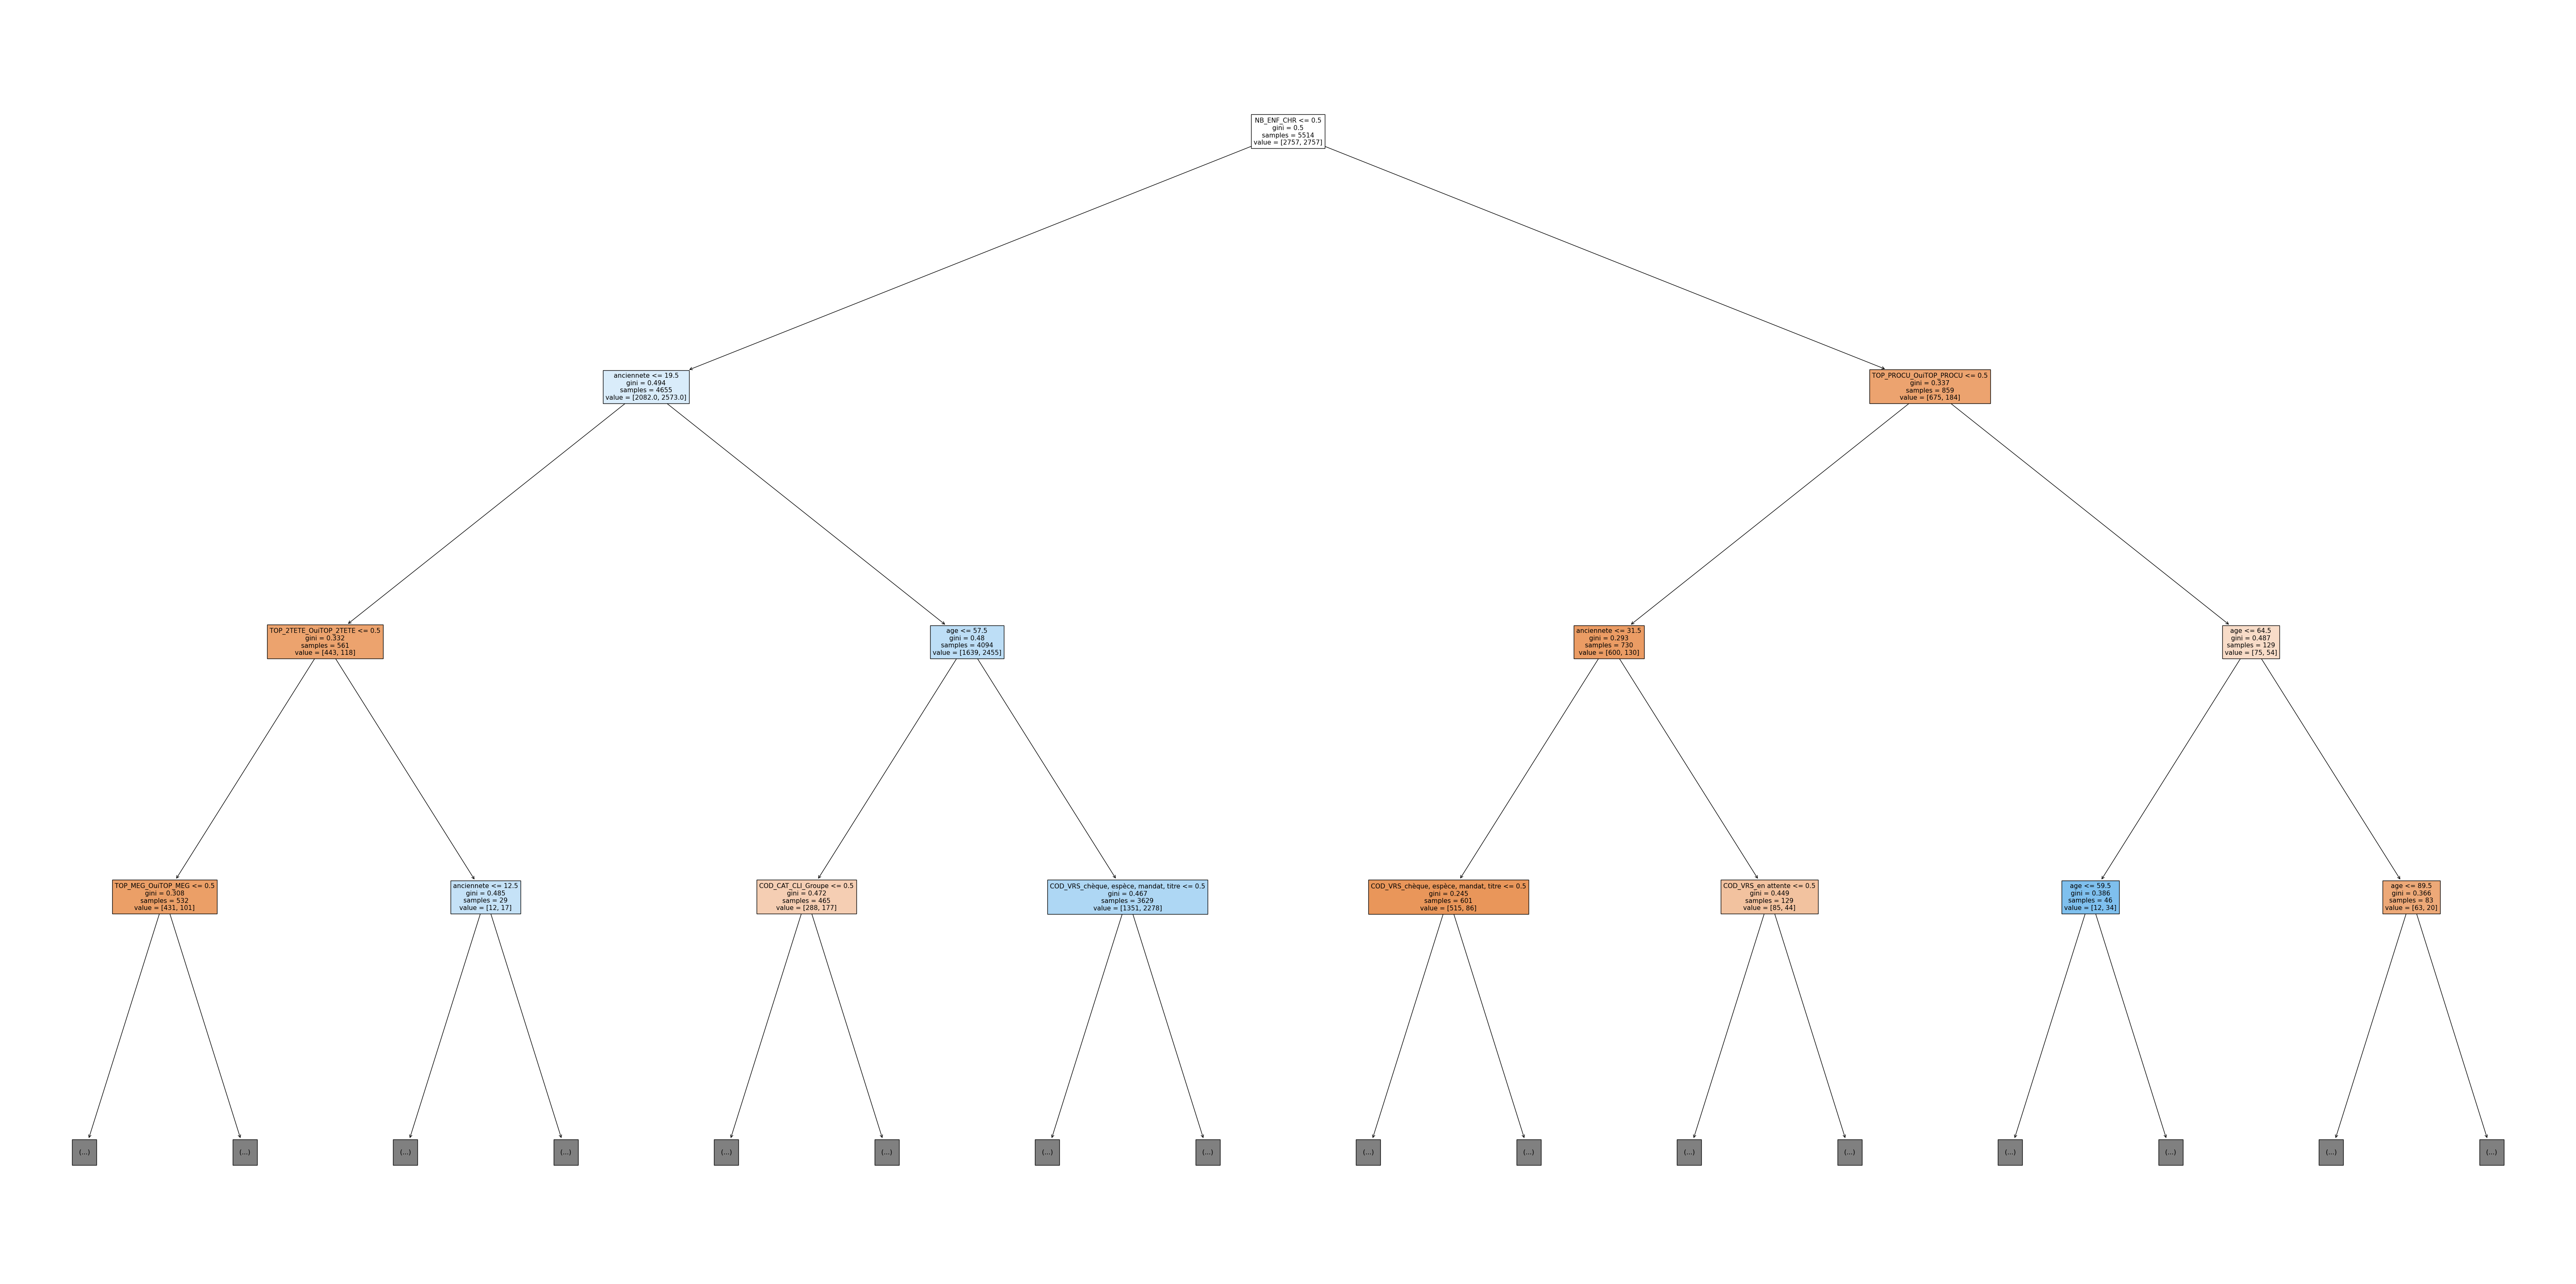

In [176]:
# Define the parameter grid for hyperparameter tuning
param_grid = {'max_depth': list(range(3, 16))}

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Perform Grid Search to find the best max_depth
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train_upsam, y_train_upsam)

# Get the best estimator
best_clf = grid_search.best_estimator_

# Train Decision Tree Classifer with the best max_depth
best_clf.fit(X_train_upsam, y_train_upsam)

# Predict the response for test dataset
y_pred = best_clf.predict(X_test)

# Plot the decision tree with the best max_depth
plt.figure(figsize=(80, 40))
plot_tree(best_clf, feature_names=X_train_upsam.columns.tolist(), max_depth=3, filled=True)

In [177]:
tree_text = export_text(best_clf, max_depth=10, feature_names=list(X_train_upsam.columns))
print(tree_text[:5000])

|--- NB_ENF_CHR <= 0.50
|   |--- anciennete <= 19.50
|   |   |--- TOP_2TETE_OuiTOP_2TETE <= 0.50
|   |   |   |--- TOP_MEG_OuiTOP_MEG <= 0.50
|   |   |   |   |--- TOP_ASSU_OuiTOP_ASSU <= 0.50
|   |   |   |   |   |--- age <= 63.50
|   |   |   |   |   |   |--- age <= 52.50
|   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |--- age >  52.50
|   |   |   |   |   |   |   |--- anciennete <= 13.50
|   |   |   |   |   |   |   |   |--- Sexe_M <= 0.50
|   |   |   |   |   |   |   |   |   |--- anciennete <= 12.50
|   |   |   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |   |   |   |--- anciennete >  12.50
|   |   |   |   |   |   |   |   |   |   |--- age <= 61.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- age >  61.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |   |   |--- Sexe_M >  0.50
|   |   |   |   |   |   |   |   |   |--- TOP_K_DE

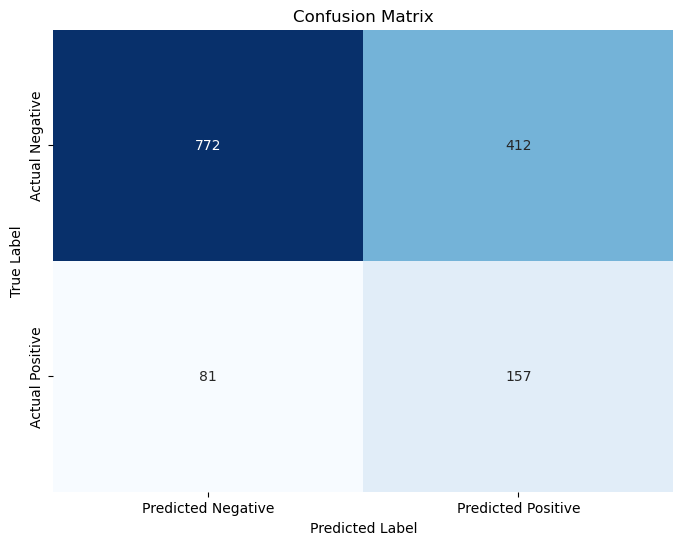

In [178]:
conf_matrix = confusion_matrix(y_test, y_pred)
# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Algorithme XGBOOST 

In [179]:
# Train XGBoost classifier
model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [180]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.79%


<Figure size 1000x600 with 0 Axes>

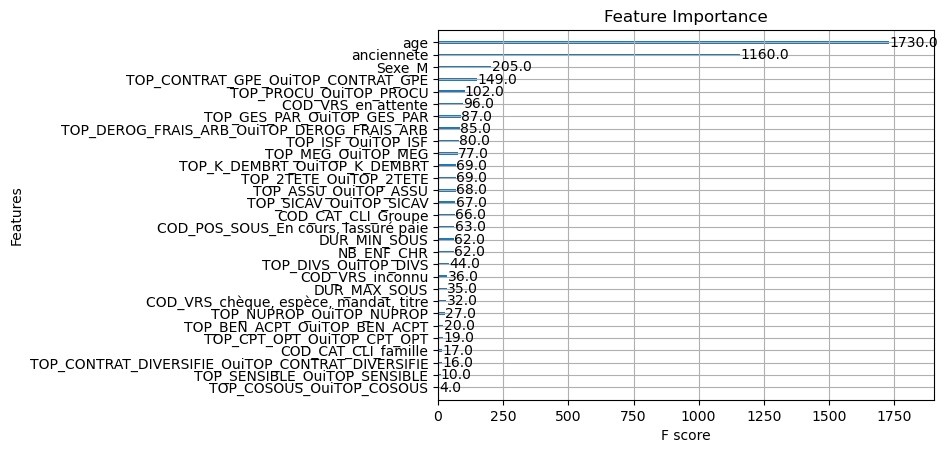

In [181]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(model)
plt.title("Feature Importance")
plt.show()

# Regression algorithm

# Taux d'arbitrage FG-UC

In [182]:
base_intermittent=base_test[base_test["r_FG_a"]!=0]

In [183]:
one_hot_data = pd.get_dummies(base_intermittent,drop_first=True)

X=one_hot_data.drop(["r_UC_UC_a","r_UC_FG_a","r_FG_a",'r_UC_UC_cat_arbitrage','r_UC_FG_cat_arbitrage'], axis=1)
y=one_hot_data["r_FG_a"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Regresseur XGBoost

In [184]:
# Train XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: %.2f" % rmse)

Root Mean Squared Error: 0.29


<Figure size 1000x600 with 0 Axes>

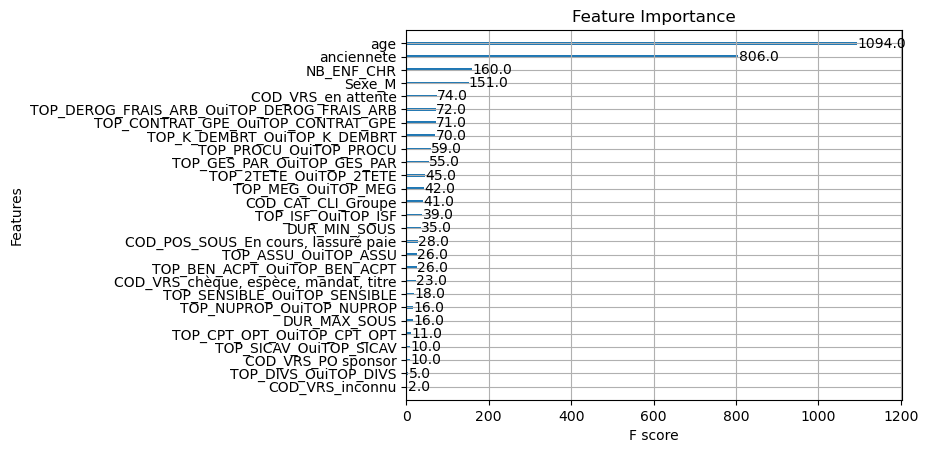

In [185]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(model)
plt.title("Feature Importance")
plt.show()

# Regresseur Lasso

In [186]:
# Set up the parameter grid for grid search
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0]  # Ajustez selon vos besoins
}

# Initialisez le modèle de régression Lasso
lasso = Lasso()

# Initialisez GridSearchCV
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Ajustez la recherche sur grille aux données
grid_search.fit(X_train, y_train)

# Obtenez le meilleur modèle et ses hyperparamètres
meilleur_lasso = grid_search.best_estimator_
meilleur_alpha = grid_search.best_params_['alpha']
# Obtenez les coefficients du modèle
coefficients = meilleur_lasso.coef_

print("Meilleur Alpha:", meilleur_alpha)

Meilleur Alpha: 0.01


<Figure size 1000x600 with 0 Axes>

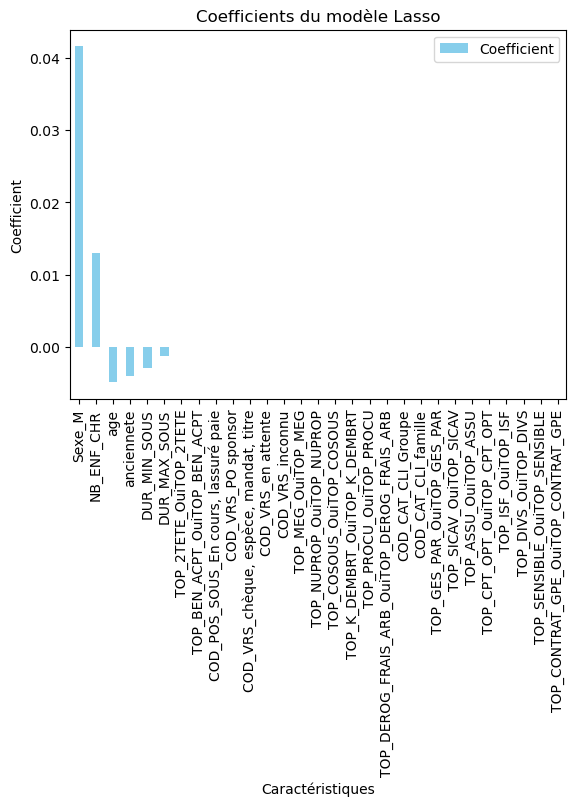

In [187]:
# Obtenez les noms des caractéristiques
noms_caracteristiques = X.columns

# Créez un DataFrame pour stocker les noms des caractéristiques et leurs coefficients correspondants
importance_des_caracteristiques = pd.DataFrame({'Caractéristique': noms_caracteristiques, 'Coefficient': coefficients})

# Triez le DataFrame par les valeurs absolues des coefficients pour identifier les caractéristiques les plus importantes
importance_des_caracteristiques['Coefficient Absolu'] = abs(importance_des_caracteristiques['Coefficient'])
importance_des_caracteristiques = importance_des_caracteristiques.sort_values(by='Coefficient Absolu', ascending=False)

# Affichez les coefficients
#print("Coefficients:")
#print(importance_des_caracteristiques)

# Tracez les importances des caractéristiques sur un graphique à barres
plt.figure(figsize=(10, 6))
importance_des_caracteristiques.plot(kind='bar', x='Caractéristique', y='Coefficient', color='skyblue')
plt.title("Coefficients du modèle Lasso")
plt.xlabel("Caractéristiques")
plt.ylabel("Coefficient")
plt.show()

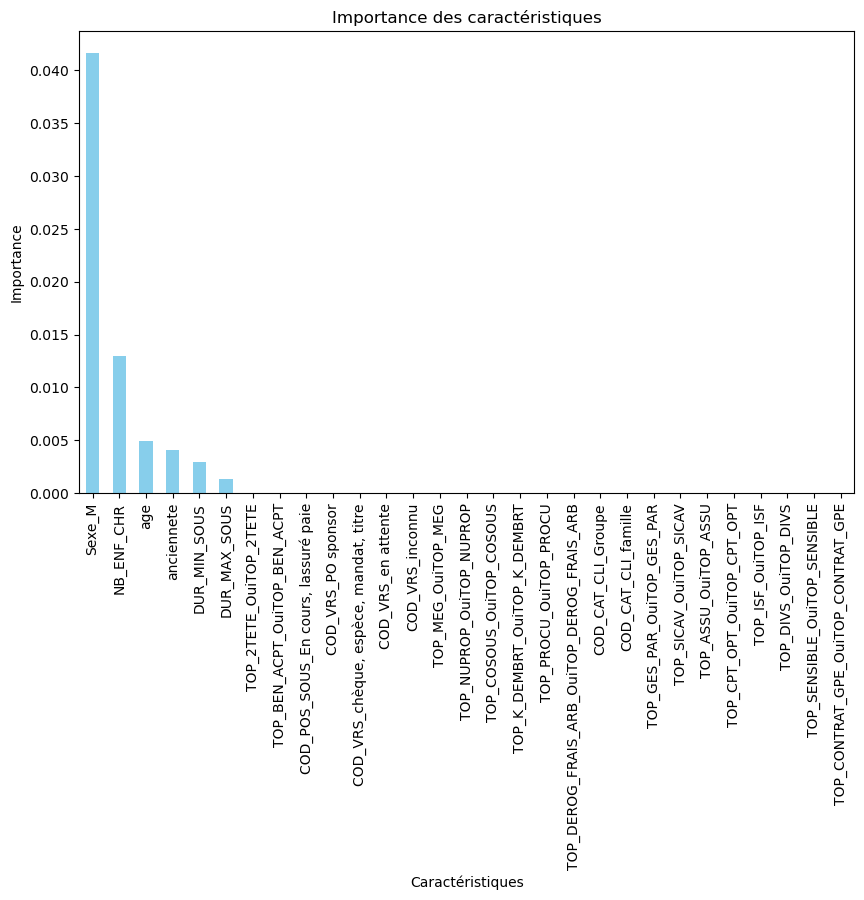

In [188]:
# Obtenez les importances des caractéristiques
importances_des_caracteristiques = pd.Series(np.abs(meilleur_lasso.coef_), index=X.columns)
importances_des_caracteristiques.sort_values(ascending=False, inplace=True)

# Tracez les importances des caractéristiques sur un graphique à barres
plt.figure(figsize=(10, 6))
importances_des_caracteristiques.plot(kind='bar', color='skyblue')
plt.title("Importance des caractéristiques")
plt.xlabel("Caractéristiques")
plt.ylabel("Importance")
plt.show()

# Taux d'arbitrage UC-UC

In [189]:
base_intermittent=base_test[base_test["r_UC_UC_a"]!=0]

In [190]:
one_hot_data = pd.get_dummies(base_intermittent,drop_first=True)

X=one_hot_data.drop(["r_UC_UC_a","r_UC_FG_a","r_FG_a",'r_UC_FG_cat_arbitrage','r_FG_a_cat_arbitrage'], axis=1)
y=one_hot_data["r_UC_UC_a"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Regresseur XGBoost

In [191]:
# Train XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: %.2f" % rmse)


Root Mean Squared Error: 0.14


<Figure size 1000x600 with 0 Axes>

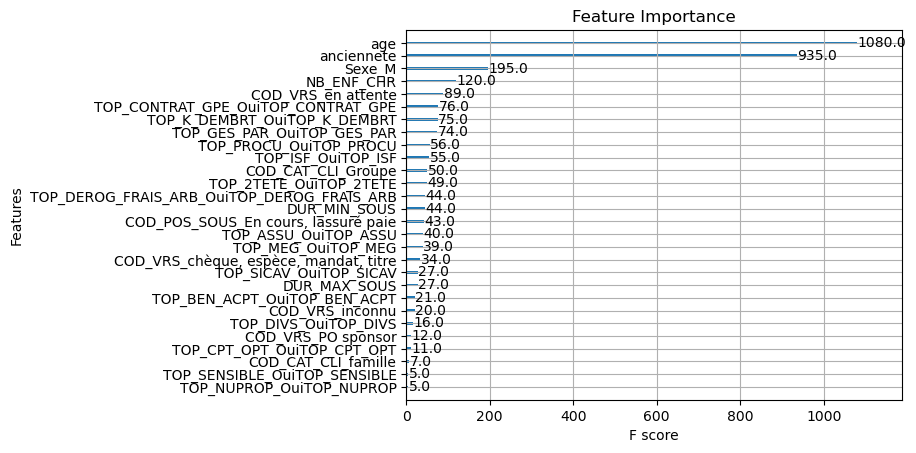

In [192]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(model)
plt.title("Feature Importance")
plt.show()

# Regresseur Lasso

In [193]:
# Set up the parameter grid for grid search
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0]  # Ajustez selon vos besoins
}

# Initialisez le modèle de régression Lasso
lasso = Lasso()

# Initialisez GridSearchCV
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Ajustez la recherche sur grille aux données
grid_search.fit(X_train, y_train)

# Obtenez le meilleur modèle et ses hyperparamètres
meilleur_lasso = grid_search.best_estimator_
meilleur_alpha = grid_search.best_params_['alpha']
# Obtenez les coefficients du modèle
coefficients = meilleur_lasso.coef_

print("Meilleur Alpha:", meilleur_alpha)

Meilleur Alpha: 0.01


<Figure size 1000x600 with 0 Axes>

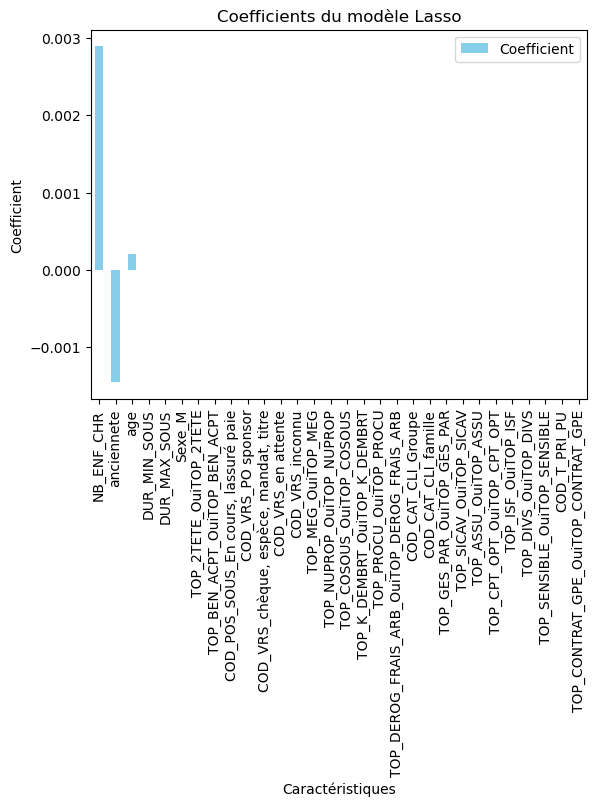

In [194]:
# Obtenez les noms des caractéristiques
noms_caracteristiques = X.columns

# Créez un DataFrame pour stocker les noms des caractéristiques et leurs coefficients correspondants
importance_des_caracteristiques = pd.DataFrame({'Caractéristique': noms_caracteristiques, 'Coefficient': coefficients})

# Triez le DataFrame par les valeurs absolues des coefficients pour identifier les caractéristiques les plus importantes
importance_des_caracteristiques['Coefficient Absolu'] = abs(importance_des_caracteristiques['Coefficient'])
importance_des_caracteristiques = importance_des_caracteristiques.sort_values(by='Coefficient Absolu', ascending=False)

# Affichez les coefficients
#print("Coefficients:")
#print(importance_des_caracteristiques)

# Tracez les importances des caractéristiques sur un graphique à barres
plt.figure(figsize=(10, 6))
importance_des_caracteristiques.plot(kind='bar', x='Caractéristique', y='Coefficient', color='skyblue')
plt.title("Coefficients du modèle Lasso")
plt.xlabel("Caractéristiques")
plt.ylabel("Coefficient")
plt.show()

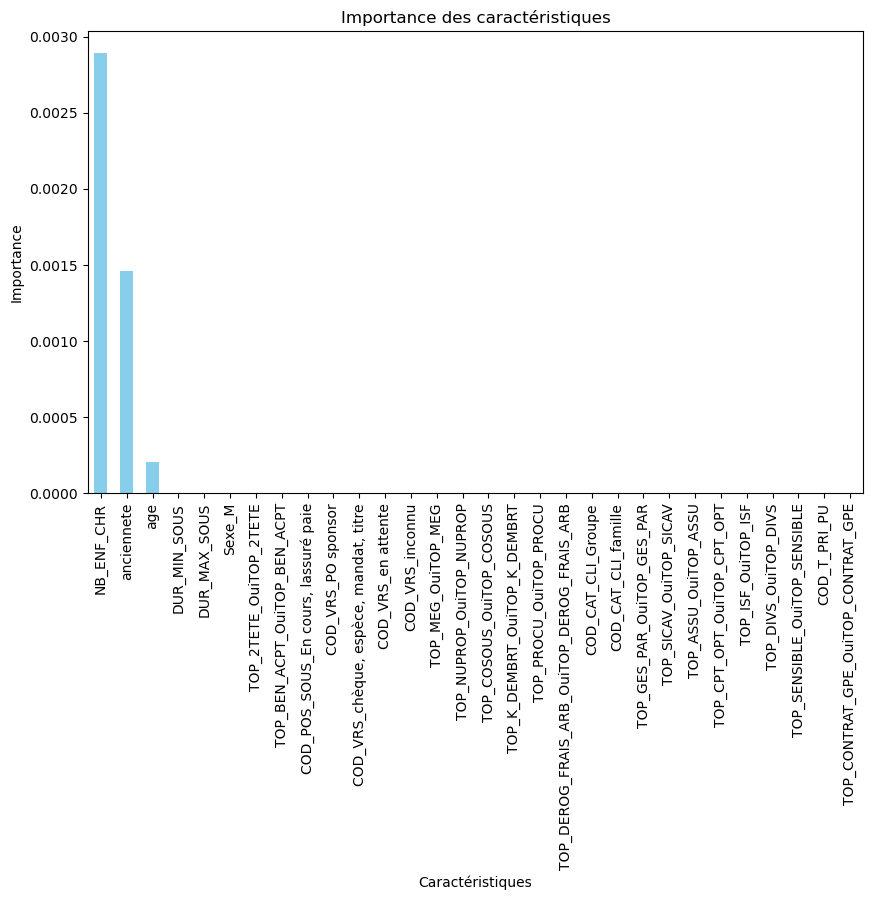

In [195]:
# Obtenez les importances des caractéristiques
importances_des_caracteristiques = pd.Series(np.abs(meilleur_lasso.coef_), index=X.columns)
importances_des_caracteristiques.sort_values(ascending=False, inplace=True)

# Tracez les importances des caractéristiques sur un graphique à barres
plt.figure(figsize=(10, 6))
importances_des_caracteristiques.plot(kind='bar', color='skyblue')
plt.title("Importance des caractéristiques")
plt.xlabel("Caractéristiques")
plt.ylabel("Importance")
plt.show()

# Taux d'arbitrage UC-FG

In [196]:
base_intermittent=base_test[base_test["r_UC_FG_a"]!=0]

In [197]:
one_hot_data = pd.get_dummies(base_intermittent,drop_first=True)

X=one_hot_data.drop(["r_UC_UC_a","r_UC_FG_a","r_FG_a",'r_UC_UC_cat_arbitrage','r_FG_a_cat_arbitrage'], axis=1)
y=one_hot_data["r_UC_FG_a"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Regresseur XGBoost

In [198]:
# Train XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: %.2f" % rmse)


Root Mean Squared Error: 0.19


<Figure size 1000x600 with 0 Axes>

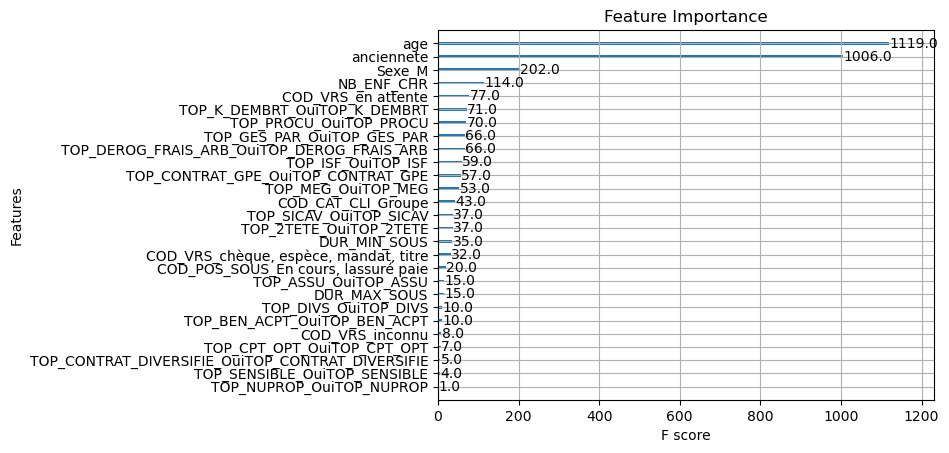

In [199]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(model)
plt.title("Feature Importance")
plt.show()

# Regresseur Lasso

In [200]:
# Set up the parameter grid for grid search
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0]  # Ajustez selon vos besoins
}

# Initialisez le modèle de régression Lasso
lasso = Lasso()

# Initialisez GridSearchCV
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Ajustez la recherche sur grille aux données
grid_search.fit(X_train, y_train)

# Obtenez le meilleur modèle et ses hyperparamètres
meilleur_lasso = grid_search.best_estimator_
meilleur_alpha = grid_search.best_params_['alpha']
# Obtenez les coefficients du modèle
coefficients = meilleur_lasso.coef_

print("Meilleur Alpha:", meilleur_alpha)

Meilleur Alpha: 0.01


<Figure size 1000x600 with 0 Axes>

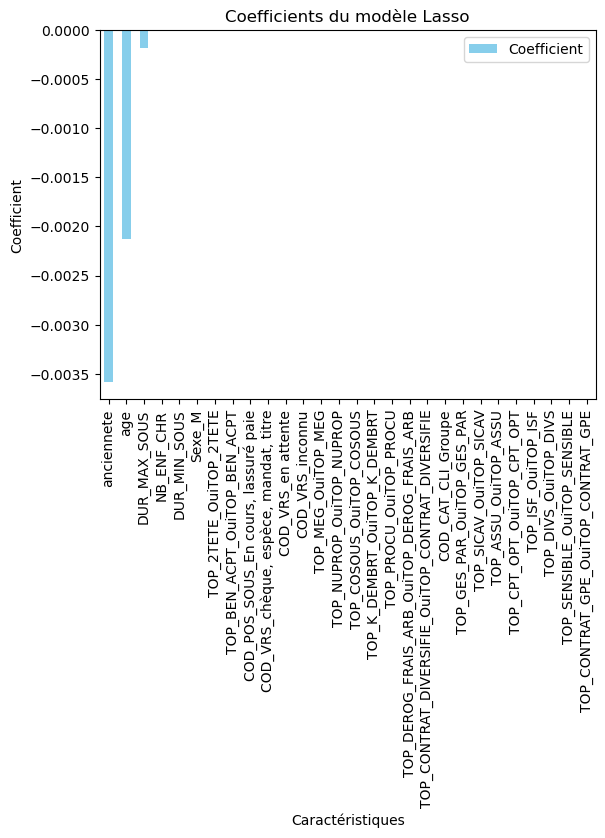

In [201]:
# Obtenez les noms des caractéristiques
noms_caracteristiques = X.columns

# Créez un DataFrame pour stocker les noms des caractéristiques et leurs coefficients correspondants
importance_des_caracteristiques = pd.DataFrame({'Caractéristique': noms_caracteristiques, 'Coefficient': coefficients})

# Triez le DataFrame par les valeurs absolues des coefficients pour identifier les caractéristiques les plus importantes
importance_des_caracteristiques['Coefficient Absolu'] = abs(importance_des_caracteristiques['Coefficient'])
importance_des_caracteristiques = importance_des_caracteristiques.sort_values(by='Coefficient Absolu', ascending=False)

# Affichez les coefficients
#print("Coefficients:")
#print(importance_des_caracteristiques)

# Tracez les importances des caractéristiques sur un graphique à barres
plt.figure(figsize=(10, 6))
importance_des_caracteristiques.plot(kind='bar', x='Caractéristique', y='Coefficient', color='skyblue')
plt.title("Coefficients du modèle Lasso")
plt.xlabel("Caractéristiques")
plt.ylabel("Coefficient")
plt.show()

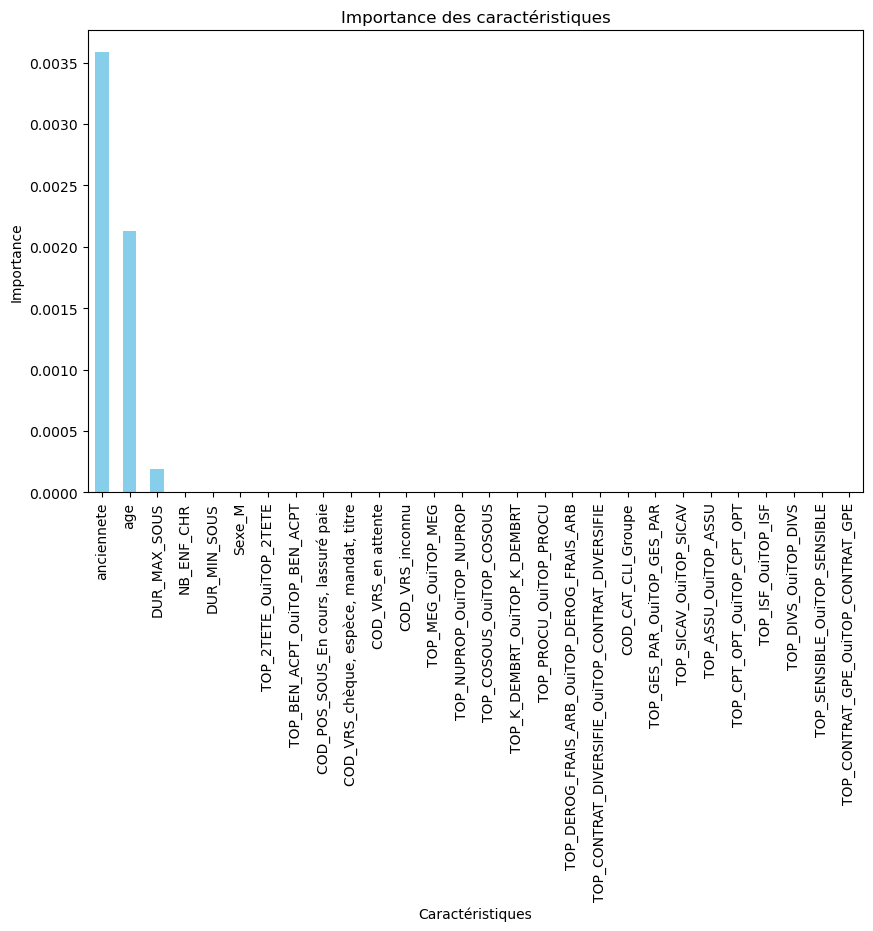

In [202]:
# Obtenez les importances des caractéristiques
importances_des_caracteristiques = pd.Series(np.abs(meilleur_lasso.coef_), index=X.columns)
importances_des_caracteristiques.sort_values(ascending=False, inplace=True)

# Tracez les importances des caractéristiques sur un graphique à barres
plt.figure(figsize=(10, 6))
importances_des_caracteristiques.plot(kind='bar', color='skyblue')
plt.title("Importance des caractéristiques")
plt.xlabel("Caractéristiques")
plt.ylabel("Importance")
plt.show()

In [203]:
base_test=base_multisupport[['n_sous','Sexe','TOP_2TETE','COD_BEN_VIE','TOP_BEN_ACPT','COD_POS_SOUS','COD_VRS','TOP_MEG','TOP_NUPROP','TOP_COSOUS','TOP_K_DEMBRT','TOP_PROCU','TOP_DEROG_FRAIS_ARB','TOP_CONTRAT_DIVERSIFIE','TOP_HANDICAP','NB_ENF_CHR','COD_POS_CLI',
 'COD_T_CLI',
 'COD_CAT_CLI','TOP_2ASS','TOP_GES_PAR',
 'TOP_RENT',
 'TOP_SICAV',
 'TOP_GAR',
 'TOP_ASSU',
 'TOP_ASSU_OTO',
 'TOP_CPT_OPT',
 'TOP_ISF',
 'TOP_DIVS',
 'COD_PAYS',
 'TOP_VIE_ENT','COD_INSEE',
 'COD_PTT_COUR',
 'COD_PAYS_COUR',
 'TOP_SENSIBLE',
 'TOP_NPAI_COUR','COD_T_PRI',
 'TOP_CONTRAT_GPE',
 'DUR_MIN_SOUS',
 'DUR_MAX_SOUS','COD_CAT_CCA_FRC','TOP_EP_PROG','r_FG_a']].drop_duplicates()

In [204]:
base_test=base_test.set_index('n_sous')

In [205]:
value={1:"Oui",0:"Non"}
for i in base_test.columns.tolist():
    if (i[:3]=='TOP'):
            base_test[i]=base_test[i].replace(value)
            base_test[i].astype('str')

In [206]:
base_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4738 entries, 1 to 9507
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sexe                    4738 non-null   object 
 1   TOP_2TETE               4738 non-null   object 
 2   COD_BEN_VIE             4738 non-null   int64  
 3   TOP_BEN_ACPT            4738 non-null   object 
 4   COD_POS_SOUS            4738 non-null   int64  
 5   COD_VRS                 4738 non-null   int64  
 6   TOP_MEG                 4738 non-null   object 
 7   TOP_NUPROP              4738 non-null   object 
 8   TOP_COSOUS              4738 non-null   object 
 9   TOP_K_DEMBRT            4738 non-null   object 
 10  TOP_PROCU               4738 non-null   object 
 11  TOP_DEROG_FRAIS_ARB     4738 non-null   object 
 12  TOP_CONTRAT_DIVERSIFIE  4738 non-null   object 
 13  TOP_HANDICAP            4738 non-null   object 
 14  NB_ENF_CHR              4738 non-null   int64

In [207]:
values={1:'Contrats de capitalisation en euros à prime unique ou versements libres',2:'Contrats de capitalisation en euros à primes périodiques',42:'Autres contrats individuels dassurance vie à prime unique ou versements libres',52:'Autres contrats individuels dassurance vie à primes périodiques',72:'Autres contrats collectifs en cas de vie',111:'Contrats PERP -partie FG'}
base_test['COD_CAT_CCA_FRC']=base_test['COD_CAT_CCA_FRC'].replace(values).astype('str')
value1={1:'bénéficiaire désigné sans clause par défaut',2:'au conjoint à la date de décès, ou à défaut à mes enfants vivants ou représentés, ou à défaut mes héritiers',3:'à ses héritiers',4:'ou à défaut aux héritiers du souscripteur',6:'à son conjoint, ou à défaut, à ses enfants ou ses héritiers',7:'conformément aux souhaits que vous avez exprimés',8:' à ses enfants ou à défaut ses héritiers',11:'à mes enfants vivants ou représentés, ou à défaut mes héritiers'}
#base_test['COD_BEN_DC']=base_test['COD_BEN_DC'].replace(value1)
value2={1:'pas de bénéficiaire',2:'au souscripteur',5:'au conjoint à la date de décès, ou à défaut à mes enfants vivants ou représentés, ou à défaut mes héritiers',6:'à des bénéficiaires selon une liste'}
base_test['COD_BEN_VIE']=base_test['COD_BEN_VIE'].replace(value2).astype('str')
value3={5:'En cours, lassuré paie',6:'En cours, lassuré ne paie plus'}
base_test['COD_POS_SOUS']=base_test['COD_POS_SOUS'].replace(value3).astype('str')
value4={1:'chèque, espèce, mandat, titre',2:'PO sponsor',3:'Carte de crédit',6:'PO banque',7:'PO banque',8:'en attente', 9:'inconnu'}
base_test['COD_VRS']=base_test['COD_VRS'].replace(value4).astype('str')
#value5={0:'présouscription',1:'souscription',2:'modification épargne programmée',3:'changement de produit',4:'rachat partiel',5:'arbitrage', 6:'rachat total', 7:'changement caractéristiques contrat',8:'Versement exceptionnel',9:'Fin de contrat',10:'mouvements combinés',11:'changement/renouvellement de TMG',12:'remboursement sur fin de contrats',13:'décès',14:'création/modification/suppression indexation',15:'tombée prime programmée'}
#base_test['COD_MVT_SC']=base_test['COD_MVT_SC'].replace(value5)
#value6={0:'non renseigné',1:'célibataire',2:'marié',3:'veuf',4:'Divorcé',5:'vie maritale', 9:'Inconnu'}
#base_test['COD_SIT_FAM']=base_test['COD_SIT_FAM'].replace(value6)
value7={1:'actif',2:'prospect',3:'décédé',4:'annulé'}
base_test['COD_POS_CLI']=base_test['COD_POS_CLI'].replace(value7).astype('str')
value8={1:'Anonyme',2:'Personne physique',3:'Personne morale',4:'Mineur',5:'Incapable majeur',6:'Individsion',7:'Incapable majeur'}
base_test['COD_T_CLI']=base_test['COD_T_CLI'].replace(value8).astype('str')
value9={1:'Externe',2:'Groupe',7:'famille',8:'entreprise'}
base_test['COD_CAT_CLI']=base_test['COD_CAT_CLI'].replace(value7).astype('str')

In [208]:
base_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4738 entries, 1 to 9507
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sexe                    4738 non-null   object 
 1   TOP_2TETE               4738 non-null   object 
 2   COD_BEN_VIE             4738 non-null   object 
 3   TOP_BEN_ACPT            4738 non-null   object 
 4   COD_POS_SOUS            4738 non-null   object 
 5   COD_VRS                 4738 non-null   object 
 6   TOP_MEG                 4738 non-null   object 
 7   TOP_NUPROP              4738 non-null   object 
 8   TOP_COSOUS              4738 non-null   object 
 9   TOP_K_DEMBRT            4738 non-null   object 
 10  TOP_PROCU               4738 non-null   object 
 11  TOP_DEROG_FRAIS_ARB     4738 non-null   object 
 12  TOP_CONTRAT_DIVERSIFIE  4738 non-null   object 
 13  TOP_HANDICAP            4738 non-null   object 
 14  NB_ENF_CHR              4738 non-null   int64

In [209]:
X=base_test.drop('r_FG_a',axis=1)
y=base_test['r_FG_a']

In [210]:
from sklearn.linear_model import Lasso,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
import numpy as np
cat=[]
num=[]
for i in X.columns:
    if (X[i].dtypes=="object"):
        cat.append(i)
    else:
        num.append(i)
from sklearn.compose import make_column_transformer
preprocessor = make_column_transformer(
        (StandardScaler(), num),
        (OneHotEncoder(handle_unknown = 'ignore'), cat))

In [211]:
X[cat]=X[cat].astype('str')

In [212]:
# Create the Lasso Regression model
lasso_model = LinearRegression()  # Adjust alpha according to your needs

# Create the final pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', lasso_model)
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['NB_ENF_CHR', 'COD_INSEE',
                                                   'DUR_MIN_SOUS',
                                                   'DUR_MAX_SOUS']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sexe', 'TOP_2TETE',
                                                   'COD_BEN_VIE',
                                                   'TOP_BEN_ACPT',
                                                   'COD_POS_SOUS', 'COD_VRS',
                                                   'TOP_MEG', 'TOP_NUPROP',
                                                   'TOP_COSOUS', 'TOP_K_DEMBRT',
                                                   'TOP_PROCU',
                                                   'TOP_DEROG_FRAIS_ARB',
                                                   'TOP_CONTRAT_DIVERSIFIE',
                                                   'TOP_HANDICAP',
                                                   'COD_POS_CLI', 'COD_T_CLI',
                                                   'COD_CAT_CLI', 'TOP_2ASS',
                                                   'TOP_GES_PAR', 'TOP_RENT',
                                                   'TOP_SICAV', 'TOP_GAR',
                                                   'TOP_ASSU', 'TOP_ASSU_OTO',
                                                   'TOP_CPT_OPT', 'TOP_ISF',
                                                   'TOP_DIVS', 'COD_PAYS',
                                                   'TOP_VIE_ENT',
                                                   'COD_PTT_COUR', ...])])),
                ('lasso', LinearRegression())])

In [213]:
X_test[cat]=X_test[cat].astype('str')
# Make predictions on the test set
y_pred = pipeline.predict(X_test)
# Evaluate the model (e.g., with Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.1172787509703263


Feature: 0, Score: -0.02972
Feature: 1, Score: -0.00240
Feature: 2, Score: -0.04210
Feature: 3, Score: -0.07373
Feature: 4, Score: -0.00911
Feature: 5, Score: 0.00911
Feature: 6, Score: -0.02334
Feature: 7, Score: 0.02334
Feature: 8, Score: -0.02720
Feature: 9, Score: -0.01936
Feature: 10, Score: 0.12888
Feature: 11, Score: 0.05337
Feature: 12, Score: -0.13569
Feature: 13, Score: -0.01744
Feature: 14, Score: 0.01744
Feature: 15, Score: 0.00913
Feature: 16, Score: -0.00913
Feature: 17, Score: -0.06362
Feature: 18, Score: 0.37177
Feature: 19, Score: -0.14387
Feature: 20, Score: -0.05921
Feature: 21, Score: -0.10507
Feature: 22, Score: 0.00780
Feature: 23, Score: -0.00780
Feature: 24, Score: 0.07128
Feature: 25, Score: -0.07128
Feature: 26, Score: -0.07578
Feature: 27, Score: 0.07578
Feature: 28, Score: -0.04412
Feature: 29, Score: 0.04412
Feature: 30, Score: 0.01448
Feature: 31, Score: -0.01448
Feature: 32, Score: -0.04526
Feature: 33, Score: 0.04526
Feature: 34, Score: 0.08585
Feature: 

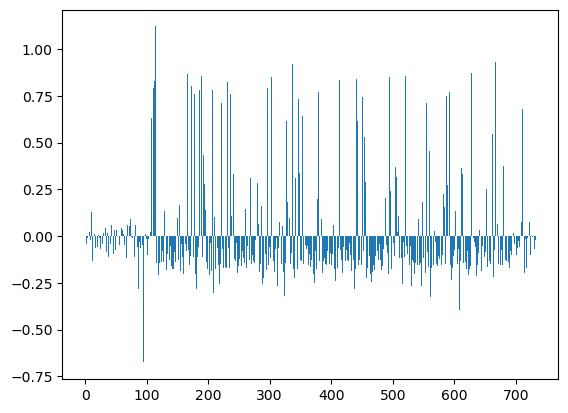

In [214]:
# Récupérer le modèle Lasso du pipeline
lasso_regression_model = pipeline.named_steps['lasso']

# Accéder aux coefficients
coefficients = lasso_regression_model.coef_

# Afficher les coefficients
for i, v in enumerate(coefficients):
    print('Feature: %0d, Score: %.5f' % (i, v))

# Plot feature importance
plt.bar([x for x in range(len(coefficients))], coefficients)
plt.show()

In [215]:
pip install dalex

Note: you may need to restart the kernel to use updated packages.


In [216]:
import dalex as dx
X_test = X_test.reset_index(drop=True)

In [217]:
exp_tree1 = dx.Explainer(pipeline, X_test, y_test, verbose=False)

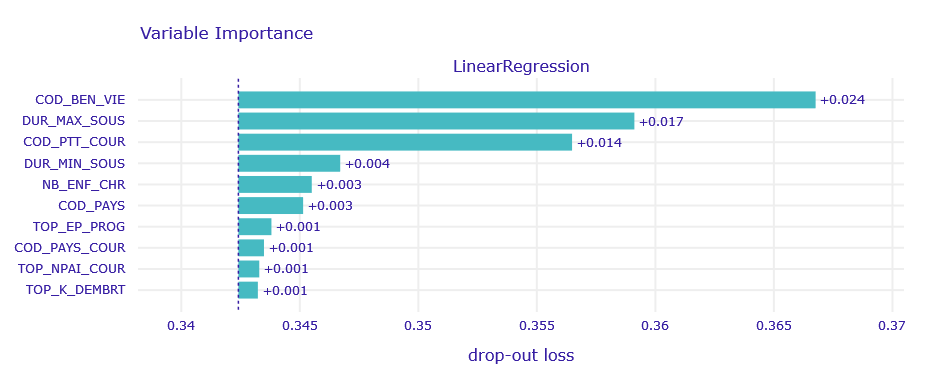

In [218]:
exp_tree1.model_parts().plot()